<a href="https://colab.research.google.com/github/StephenJudeD/Churn-Model-Deep-Survival-Curve-Mobile-Network/blob/main/ThreeMobile_CustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Three Churn Analysis

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
# Load the Excel file
file_path = "/content/drive/My Drive/ThreeChurn/Three Data Science Exercise_202411.xlsx"

# Read the sheets
client_df = pd.read_excel(file_path, sheet_name='1. Client Database')
discount_df = pd.read_excel(file_path, sheet_name='2. Discount Data')
customer_care_df = pd.read_excel(file_path, sheet_name='3. Customer Care Data')
cancellations_df = pd.read_excel(file_path, sheet_name='4. Cancellations Data')

# Exploratory Data Analysis & Transformations

In [ ]:
# Convert CancellationDate to datetime
cancellations_df['CancellationDate'] = pd.to_datetime(cancellations_df['CancellationDate'], dayfirst=True, errors='coerce')

# Merge CancellationDate into client_df
client_df = client_df.merge(
    cancellations_df[['UserID', 'CancellationDate']],
    on='UserID',
    how='left'
)

# Define Churned: 1 if CancellationDate is not null, else 0
client_df['Churned'] = client_df['CancellationDate'].notna().astype(int)

# Verify the merger
print("\nClient Data after merging CancellationDate and Churned:\n", client_df[['UserID', 'CancellationDate', 'Churned']].head())


Client Data after merging CancellationDate and Churned:
    UserID CancellationDate  Churned
0  C10000              NaT        0
1  C10001              NaT        0
2  C10002              NaT        0
3  C10003              NaT        0
4  C10004              NaT        0


In [ ]:
# CORRECT way to define churn
def define_churn(df):
    # Churn is ONLY based on CancellationDate
    df['Churned'] = df['CancellationDate'].notna().astype(int)
    return df

# Verify the logic
verification = client_df.copy()
verification['Churned'] = verification['CancellationDate'].notna().astype(int)

# Show the relationship
print("Churn Definition Verification:")
print("-" * 50)
print("If CancellationDate exists → Churned = 1")
print("If NO CancellationDate → Churned = 0")

# Simple check
assert verification[verification['CancellationDate'].notna()]['Churned'].all() == 1, "All records with CancellationDate should be marked as churned"
assert verification[verification['CancellationDate'].isna()]['Churned'].any() == 0, "All records without CancellationDate should be marked as not churned"

Churn Definition Verification:
--------------------------------------------------
If CancellationDate exists → Churned = 1
If NO CancellationDate → Churned = 0


In [ ]:
def analyze_user_level_churn(df):
    # Check for unique UserIDs
    total_records = len(df)
    unique_users = df['UserID'].nunique()

    print("User Level Analysis:")
    print("-" * 50)
    print(f"Total records: {total_records}")
    print(f"Unique users: {unique_users}")

    if total_records != unique_users:
        print("\nWARNING: Duplicate UserIDs found!")

        # Show duplicate users if any
        duplicates = df[df['UserID'].duplicated(keep=False)].sort_values('UserID')
        print("\nDuplicate Users:")
        print(duplicates[['UserID', 'StatusID', 'CancellationDate', 'Churned']])

    # User level churn analysis
    user_churn = df.groupby('UserID')['Churned'].max().reset_index()

    total_unique_users = len(user_churn)
    churned_users = user_churn['Churned'].sum()
    user_churn_rate = (churned_users / total_unique_users) * 100

    print("\nUser Level Churn Metrics:")
    print("-" * 50)
    print(f"Total unique users: {total_unique_users}")
    print(f"Churned users: {churned_users}")
    print(f"Non-churned users: {total_unique_users - churned_users}")
    print(f"User level churn rate: {user_churn_rate:.2f}%")

    return user_churn

# Perform the analysis
user_level_churn = analyze_user_level_churn(client_df)

User Level Analysis:
--------------------------------------------------
Total records: 25687
Unique users: 2000


Duplicate Users:
       UserID StatusID CancellationDate  Churned
0      C10000        A              NaT        0
4063   C10000        A              NaT        0
8224   C10000        A              NaT        0
10329  C10000        A              NaT        0
12452  C10000        A              NaT        0
...       ...      ...              ...      ...
24500  C11965        A              NaT        0
22255  C11965        A              NaT        0
24519  C11966        A              NaT        0
24520  C11966        C              NaT        0
22258  C11966        A              NaT        0

[25654 rows x 4 columns]

User Level Churn Metrics:
--------------------------------------------------
Total unique users: 2000
Churned users: 200
Non-churned users: 1800
User level churn rate: 10.00%


In [ ]:
# Drop all 'N' records from CurrentRecordInd
client_df = client_df[client_df['CurrentRecordInd'] == 'Y']

# Then drop the CurrentRecordInd column
client_df = client_df.drop('CurrentRecordInd', axis=1)

print("\nUpdated client_df:")
print(client_df.head())


Updated client_df:
   UserID  FiscalPeriod UpdateDate ActiveFlagInd StatusID SegmentName  \
0  C10000        202311 2023-11-30             Y        A    BILL PAY   
1  C10001        202311 2023-11-30             Y        A    BILL PAY   
2  C10002        202311 2023-11-30             Y        A    BILL PAY   
3  C10003        202311 2023-11-30             Y        A    BILL PAY   
4  C10004        202311 2023-11-30             Y        A    BILL PAY   

                   DOB ContractEndDate     ContractType SpendLastMonth  ...  \
0  1959-03-28 00:00:00      2021-10-03  30 DAY                   14.51  ...   
1  1971-07-15 00:00:00      2024-01-23  24 MONTH                 53.37  ...   
2  1966-10-23 00:00:00      2022-06-24  24 MONTH                  18.7  ...   
3  1971-08-11 00:00:00      2024-02-10  24 MONTH                 41.26  ...   
4  1953-06-06 00:00:00      2024-03-06  24 MONTH                 50.97  ...   

  StoreLocation InsuranceInd TenureInMonths  TVInd      DeviceType

In [ ]:
# Drop rows where ActiveFlagInd is 'N'
client_df = client_df[client_df['ActiveFlagInd'] != 'N']

# Then drop the ActiveFlagInd column (optional)
client_df = client_df.drop('ActiveFlagInd', axis=1)

print("\nUpdated client_df:")
print(client_df.tail())


Updated client_df:
       UserID  FiscalPeriod UpdateDate StatusID SegmentName  \
25681  C11774        202410 2024-10-31        A      PREPAY   
25682  C11775        202410 2024-10-31        A    BILL PAY   
25684  C11776        202410 2024-10-31        A    BILL PAY   
25685  C11777        202410 2024-10-31        A      PREPAY   
25686  C11778        202410 2024-10-31        A      PREPAY   

                       DOB ContractEndDate     ContractType SpendLastMonth  \
25681  1975-01-17 00:00:00      2099-12-31  PREPAID                  16.26   
25682  1953-09-25 00:00:00      2025-07-07  24 MONTH                 42.23   
25684  1978-10-23 00:00:00      2026-01-01  24 MONTH                 61.07   
25685           01/01/1895      2099-12-31  PREPAID                      0   
25686  1957-01-15 00:00:00      2099-12-31  PREPAID                  16.26   

       TopupMethod StoreLocation InsuranceInd  TenureInMonths TVInd  \
25681         BANK       UNKNOWN            0              40

In [ ]:
client_df.describe()

FiscalPeriod                     UpdateDate  \
count   21038.000000                          21038   
mean   202390.035079  2024-05-16 17:09:14.767563520   
min    202311.000000            2023-11-30 00:00:00   
25%    202402.000000            2024-02-29 00:00:00   
50%    202405.000000            2024-05-31 00:00:00   
75%    202408.000000            2024-08-31 00:00:00   
max    202410.000000            2024-10-31 00:00:00   
std        34.971993                            NaN   

                     ContractEndDate  TenureInMonths  \
count                          21038    21038.000000   
mean   2041-07-29 22:58:03.296891392       74.809678   
min              2000-11-16 00:00:00        0.000000   
25%              2019-05-08 00:00:00       26.000000   
50%              2024-03-23 00:00:00       64.000000   
75%              2099-12-31 00:00:00       98.000000   
max              2099-12-31 00:00:00      334.000000   
std                              NaN       63.187882   

                    CancellationDate       Churned  
count                           1271  21038.000000  
mean   2024-07-19 22:21:25.916601088      0.060414  
min              2024-01-04 00:00:00      0.000000  
25%              2024-06-02 00:00:00      0.000000  
50%              2024-08-07 00:00:00      0.000000  
75%              2024-09-19 00:00:00      0.000000  
max              2024-10-29 00:00:00      1.000000  
std                              NaN      0.238259

In [ ]:
import numpy as np
import pandas as pd

def clean_numeric_column(df, column):
    """
    Convert column to numeric, handling '?' and other non-numeric values
    Returns the number of values that were converted/cleaned
    """
    # Store original state
    original_non_numeric = df[column].isin(['?', '']).sum()

    # Replace '?' and empty strings with NaN
    df[column] = df[column].replace(['?', ''], np.nan)

    # Remove commas if present
    if df[column].dtype == object:
        df[column] = df[column].str.replace(',', '', regex=True)

    # Convert to numeric
    df[column] = pd.to_numeric(df[column], errors='coerce')

    print(f"Column {column}: Converted {original_non_numeric} non-numeric values to NaN")
    return df[column]

# Apply the cleaning to all specified columns
numeric_cols = ['SpendLastMonth', 'UsageLastMonth', 'FriendReferralsLastMonth',
                'TenureInMonths', 'TVInd', 'InsuranceInd', 'FriendReferralInd']

for col in numeric_cols:
    client_df[col] = clean_numeric_column(client_df, col)

# Verify the data types after cleaning
print("\nNew data types after conversion:")
print(client_df[numeric_cols].dtypes)

# Quick summary statistics to verify the conversion worked
print("\nSummary statistics for converted columns:")
print(client_df[numeric_cols].describe())

Column SpendLastMonth: Converted 654 non-numeric values to NaN
Column UsageLastMonth: Converted 42 non-numeric values to NaN
Column FriendReferralsLastMonth: Converted 42 non-numeric values to NaN
Column TenureInMonths: Converted 0 non-numeric values to NaN
Column TVInd: Converted 42 non-numeric values to NaN
Column InsuranceInd: Converted 42 non-numeric values to NaN
Column FriendReferralInd: Converted 42 non-numeric values to NaN

New data types after conversion:
SpendLastMonth              float64
UsageLastMonth              float64
FriendReferralsLastMonth    float64
TenureInMonths                int64
TVInd                       float64
InsuranceInd                float64
FriendReferralInd           float64
dtype: object

Summary statistics for converted columns:
       SpendLastMonth  UsageLastMonth  FriendReferralsLastMonth  \
count    20384.000000    2.099600e+04              20996.000000   
mean        24.659922    1.125689e+11                  0.341160   
std         18.64679

<ipython-input-10-3ec7460a068f>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(['?', ''], np.nan)


In [ ]:
def analyze_customer_status(df):
    # Convert Churned to boolean for clarity
    df['Churned'] = df['Churned'].astype(bool)

    # Calculate overall statistics
    print("\nOverall Churn Analysis:")
    print("-----------------------")
    total_customers = len(df)
    churned_customers = df['Churned'].sum()
    churn_rate = (churned_customers / total_customers) * 100

    print(f"Total Customers: {total_customers}")
    print(f"Churned Customers: {churned_customers}")
    print(f"Active Customers: {total_customers - churned_customers}")
    print(f"Churn Rate: {churn_rate:.2f}%")

    # Detailed analysis by churn status
    print("\nDetailed Customer Analysis:")
    print("-----------------------")
    stats = df.groupby('Churned').agg({
        'TenureInMonths': ['mean', 'median', 'count'],
        'SpendLastMonth': ['mean', 'median'],
        'SegmentName': lambda x: x.value_counts().to_dict()
    }).round(2)

    # Print statistics for each group
    for is_churned in [False, True]:
        status = "Churned" if is_churned else "Active"
        print(f"\n{status} Customers Statistics:")
        print(f"Number of Customers: {stats.loc[is_churned, ('TenureInMonths', 'count')]}")
        print(f"Average Tenure: {stats.loc[is_churned, ('TenureInMonths', 'mean')]} months")
        print(f"Median Tenure: {stats.loc[is_churned, ('TenureInMonths', 'median')]} months")
        print(f"Average Spend: ${stats.loc[is_churned, ('SpendLastMonth', 'mean')]:.2f}")
        print(f"Median Spend: ${stats.loc[is_churned, ('SpendLastMonth', 'median')]:.2f}")
        print("\nSegment Distribution:")
        segments = stats.loc[is_churned, ('SegmentName', '<lambda>')]
        total = sum(segments.values())
        for segment, count in segments.items():
            percentage = (count/total) * 100
            print(f"{segment}: {percentage:.1f}%")

    return df

# Usage
analyzed_df = analyze_customer_status(client_df)


Overall Churn Analysis:
-----------------------
Total Customers: 21038
Churned Customers: 1271
Active Customers: 19767
Churn Rate: 6.04%

Detailed Customer Analysis:
-----------------------

Active Customers Statistics:
Number of Customers: 19767
Average Tenure: 75.35 months
Median Tenure: 65.0 months
Average Spend: $24.62
Median Spend: $18.95

Segment Distribution:
PREPAY: 57.8%
BILL PAY: 42.2%

Churned Customers Statistics:
Number of Customers: 1271
Average Tenure: 66.39 months
Median Tenure: 61.0 months
Average Spend: $25.29
Median Spend: $24.39

Segment Distribution:
PREPAY: 50.6%
BILL PAY: 49.4%


###Contract End Data

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd

def calculate_months_since_contract_end(df, contract_end_column, cancellation_date_column):
    """
    Calculate the number of months since the contract end date.
    If a cancellation date is present, use it instead of the current date as the reference.
    For prepay customers with a ContractEndDate of '2099-12-31', treat ContractEndDate as NaN.
    """
    # Parse dates
    df[contract_end_column] = pd.to_datetime(df[contract_end_column], errors='coerce')
    df[cancellation_date_column] = pd.to_datetime(df[cancellation_date_column], errors='coerce')

    # Treat '2099-12-31' as NaN for prepay customers
    prepay_mask = (df[contract_end_column] == '2099-12-31') & (df['SegmentName'].str.upper() == 'PREPAY')
    df.loc[prepay_mask, contract_end_column] = np.nan

    # Get the current date
    current_date = datetime.now()

    # Calculate months since contract end
    def calculate_months(row):
        if pd.notnull(row[cancellation_date_column]):  # Use CancellationDate if available
            reference_date = row[cancellation_date_column]
        else:  # Otherwise, use the current date
            reference_date = current_date

        if pd.notnull(row[contract_end_column]):
            return (reference_date.year - row[contract_end_column].year) * 12 + (reference_date.month - row[contract_end_column].month)
        return np.nan

    df['MonthsSinceContractEnd'] = df.apply(calculate_months, axis=1)

    print("Added column MonthsSinceContractEnd based on ContractEndDate and CancellationDate.")
    return df

# Apply the updated calculation
client_df = calculate_months_since_contract_end(client_df, 'ContractEndDate', 'CancellationDate')

Added column MonthsSinceContractEnd based on ContractEndDate and CancellationDate.


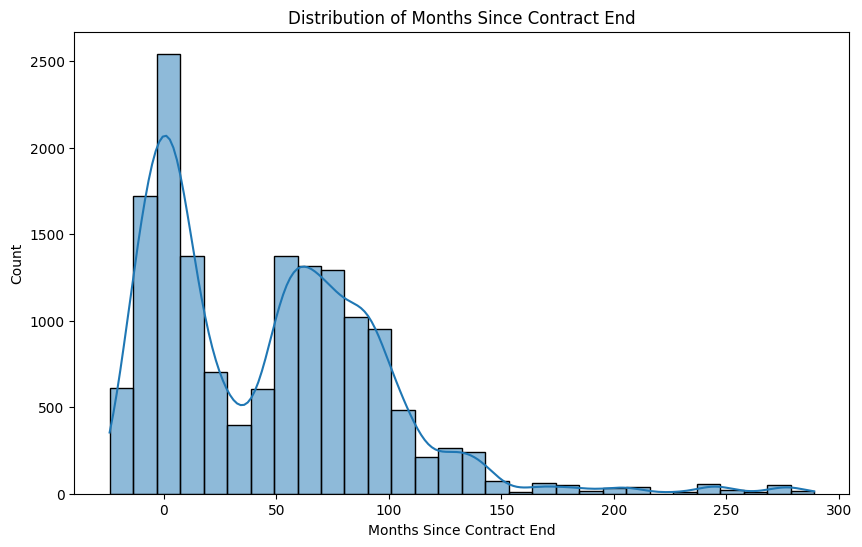

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(client_df['MonthsSinceContractEnd'], bins=30, kde=True)
plt.title('Distribution of Months Since Contract End')
plt.xlabel('Months Since Contract End')
plt.ylabel('Count')
plt.show()

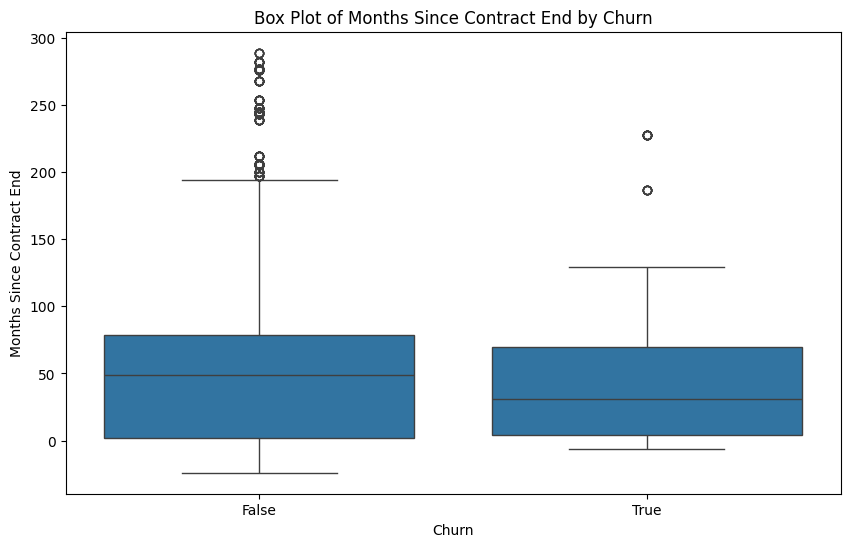

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churned', y='MonthsSinceContractEnd', data=client_df)
plt.title('Box Plot of Months Since Contract End by Churn')
plt.xlabel('Churn')
plt.ylabel('Months Since Contract End')
plt.show()

###Age

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np

def calculate_age(birthdate):
    """
    Calculate the age from a given birthdate.

    Parameters:
    birthdate (str or datetime): The birthdate in a format that pandas can parse.

    Returns:
    int: The calculated age in years, or NaN if the birthdate is invalid.
    """
    try:
        birthdate = pd.to_datetime(birthdate)
        today = pd.Timestamp.today()
        age = (today - birthdate).days / 365.25
        return int(age)
    except (ValueError, TypeError):
        return np.nan

# Calculate age from DOB
client_df['Age'] = client_df['DOB'].apply(calculate_age)

# Inspect the ages
print("Age Description before cleaning:")
print(client_df['Age'].describe())

# Define age bounds (for example, assume realistic ages are between 18 and 100)
lower_bound, upper_bound = 18, 100

# Clean outliers using vectorized operations
client_df['Age'] = np.where((client_df['Age'] < lower_bound) | (client_df['Age'] > upper_bound), np.nan, client_df['Age'])

#Impute missing or erroneous values
# Using median for imputation
median_age = client_df['Age'].median()
client_df['Age'].fillna(median_age, inplace=True)

# Verify the changes
print("\nAge Description after cleaning and imputation:")
print(client_df['Age'].describe())

<ipython-input-15-bdffea3528bd>:16: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  birthdate = pd.to_datetime(birthdate)


Age Description before cleaning:
count    21038.000000
mean        62.728159
std         38.043735
min          5.000000
25%         36.000000
50%         51.000000
75%         72.000000
max        276.000000
Name: Age, dtype: float64

Age Description after cleaning and imputation:
count    21038.000000
mean        47.322131
std         15.058271
min         18.000000
25%         36.000000
50%         46.000000
75%         56.000000
max        100.000000
Name: Age, dtype: float64


<ipython-input-15-bdffea3528bd>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  client_df['Age'].fillna(median_age, inplace=True)


In [ ]:
# To see unique values
for column in client_df.columns:
    print(f"\n{column}:")
    print(f"Unique values: {client_df[column].nunique()}")
    print("Sample of unique values:", client_df[column].unique()[:5])  # Show first 5 unique values

# To identify numerical and non-numerical columns
numerical_columns = client_df.select_dtypes(include=['int64', 'float64']).columns
non_numerical_columns = client_df.select_dtypes(exclude=['int64', 'float64']).columns

print("\nNumerical Columns:")
print(list(numerical_columns))

print("\nNon-Numerical Columns:")
print(list(non_numerical_columns))

# Additional information about data types
print("\nDetailed Data Types:")
print(client_df.dtypes)


UserID:
Unique values: 1994
Sample of unique values: ['C10000' 'C10001' 'C10002' 'C10003' 'C10004']

FiscalPeriod:
Unique values: 12
Sample of unique values: [202311 202312 202401 202402 202403]

UpdateDate:
Unique values: 12
Sample of unique values: <DatetimeArray>
['2023-11-30 00:00:00', '2023-12-31 00:00:00', '2024-01-31 00:00:00',
 '2024-02-29 00:00:00', '2024-03-31 00:00:00']
Length: 5, dtype: datetime64[ns]

StatusID:
Unique values: 2
Sample of unique values: ['A' 'S']

SegmentName:
Unique values: 2
Sample of unique values: ['BILL PAY' 'PREPAY']

DOB:
Unique values: 1499
Sample of unique values: [datetime.datetime(1959, 3, 28, 0, 0) datetime.datetime(1971, 7, 15, 0, 0)
 datetime.datetime(1966, 10, 23, 0, 0)
 datetime.datetime(1971, 8, 11, 0, 0) datetime.datetime(1953, 6, 6, 0, 0)]

ContractEndDate:
Unique values: 1044
Sample of unique values: <DatetimeArray>
['2021-10-03 00:00:00', '2024-01-23 00:00:00', '2022-06-24 00:00:00',
 '2024-02-10 00:00:00', '2024-03-06 00:00:00']
Lengt

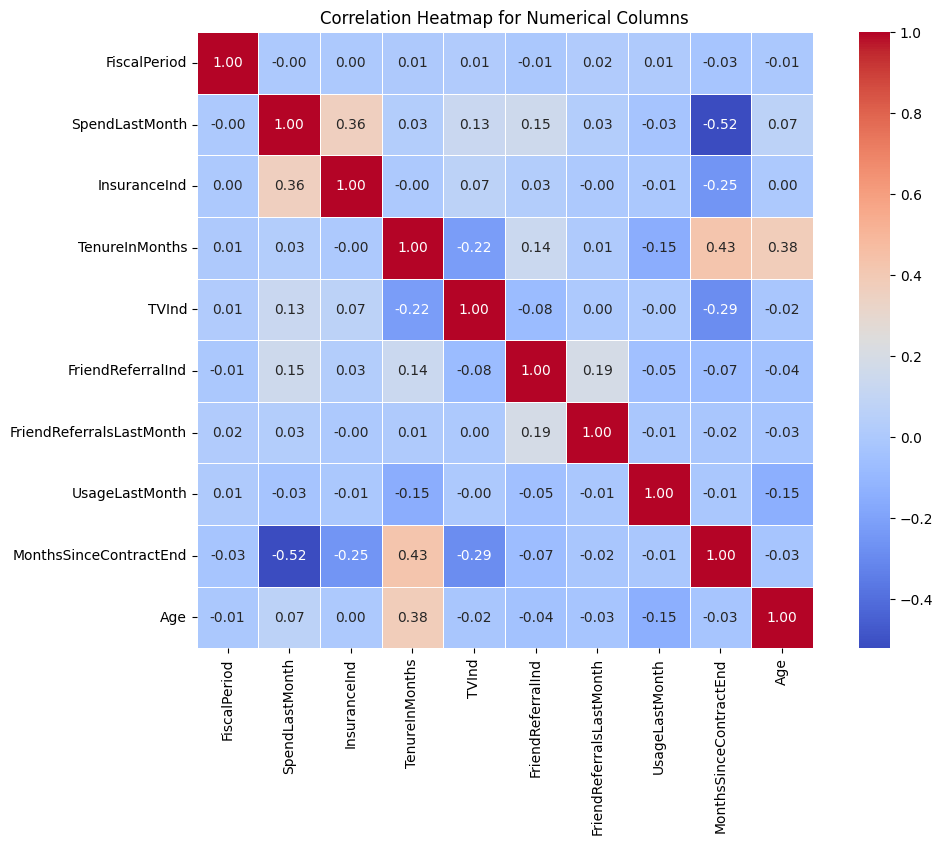

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for the numerical columns
correlation_matrix = client_df[numerical_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True, linewidths=0.5)

# Display the heatmap
plt.title('Correlation Heatmap for Numerical Columns')
plt.show()

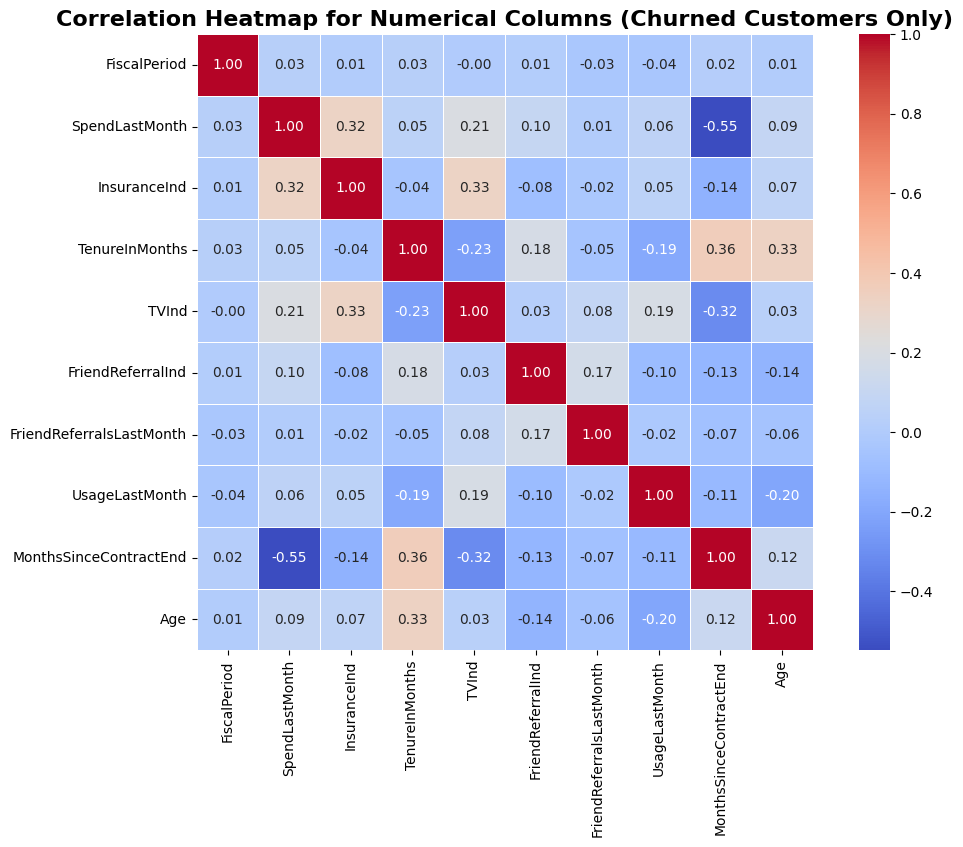

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for churned customers
churned_customers = client_df[client_df['Churned'] == 1]

# Calculate the correlation matrix for numerical columns among churned customers
correlation_matrix_churned = churned_customers[numerical_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create the heatmap for churned customers
sns.heatmap(
    correlation_matrix_churned,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar=True,
    square=True,
    linewidths=0.5
)

# Display the heatmap
plt.title('Correlation Heatmap for Numerical Columns (Churned Customers Only)', fontsize=16, fontweight='bold')
plt.show()

### Visulaising Distributions

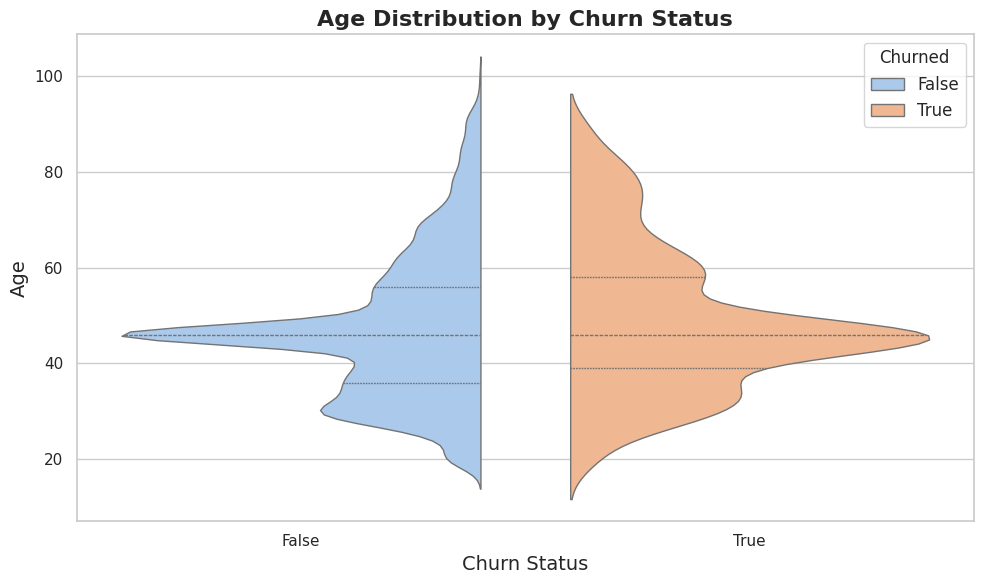

In [ ]:
# Set Seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=client_df,
    x='Churned',
    y='Age',
    hue='Churned',  # Adds color differentiation by Churned
    split=True,  # Splits the violins for comparison
    inner="quartile",  # Shows quartiles inside the violin
    linewidth=1,  # Makes the edges clean and visible
)

# Add title and labels
plt.title("Age Distribution by Churn Status", fontsize=16, fontweight='bold')
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("Age", fontsize=14)

# Add a legend
plt.legend(title="Churned", loc='upper right', fontsize=12)

# Make the plot pretty
plt.tight_layout()
plt.show()

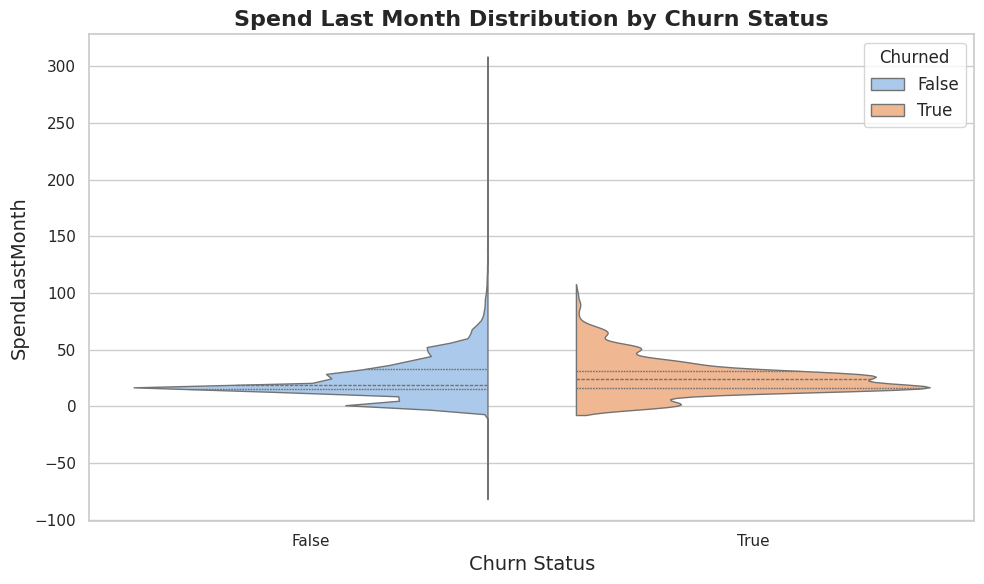

In [ ]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=client_df,
    x='Churned',
    y='SpendLastMonth',
    hue='Churned',  # Adds color differentiation by Churned
    split=True,  # Splits the violins for comparison
    inner="quartile",  # Shows quartiles inside the violin
    linewidth=1,  # Makes the edges clean and visible
)

# Add title and labels
plt.title("Spend Last Month Distribution by Churn Status", fontsize=16, fontweight='bold')
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("SpendLastMonth", fontsize=14)

# Add a legend
plt.legend(title="Churned", loc='upper right', fontsize=12)

# Make the plot pretty
plt.tight_layout()
plt.show()

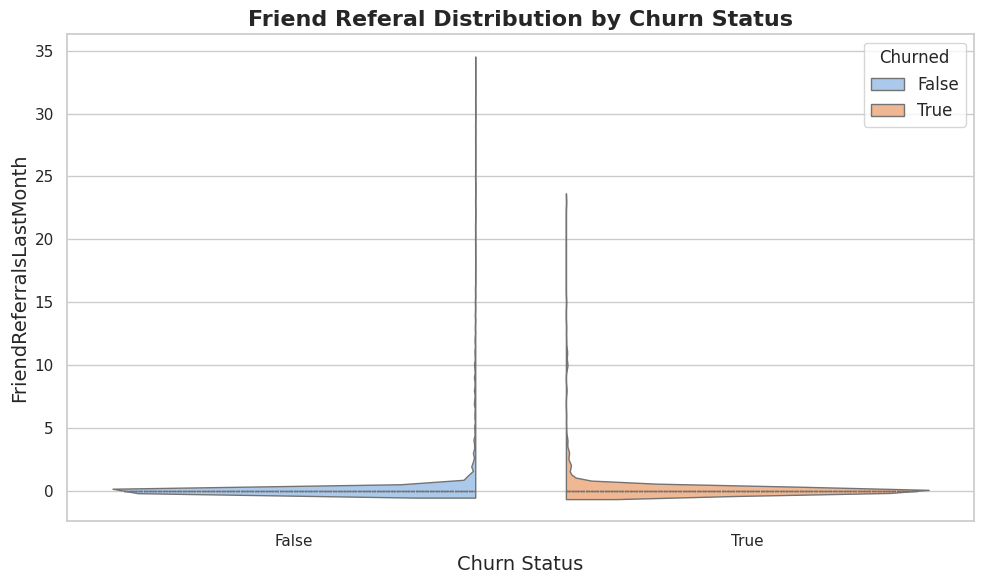

In [ ]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=client_df,
    x='Churned',
    y='FriendReferralsLastMonth',
    hue='Churned',  # Adds color differentiation by Churned
    split=True,  # Splits the violins for comparison
    inner="quartile",  # Shows quartiles inside the violin
    linewidth=1,  # Makes the edges clean and visible
)

# Add title and labels
plt.title("Friend Referal Distribution by Churn Status", fontsize=16, fontweight='bold')
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("FriendReferralsLastMonth", fontsize=14)

# Add a legend
plt.legend(title="Churned", loc='upper right', fontsize=12)

# Make the plot pretty
plt.tight_layout()
plt.show()

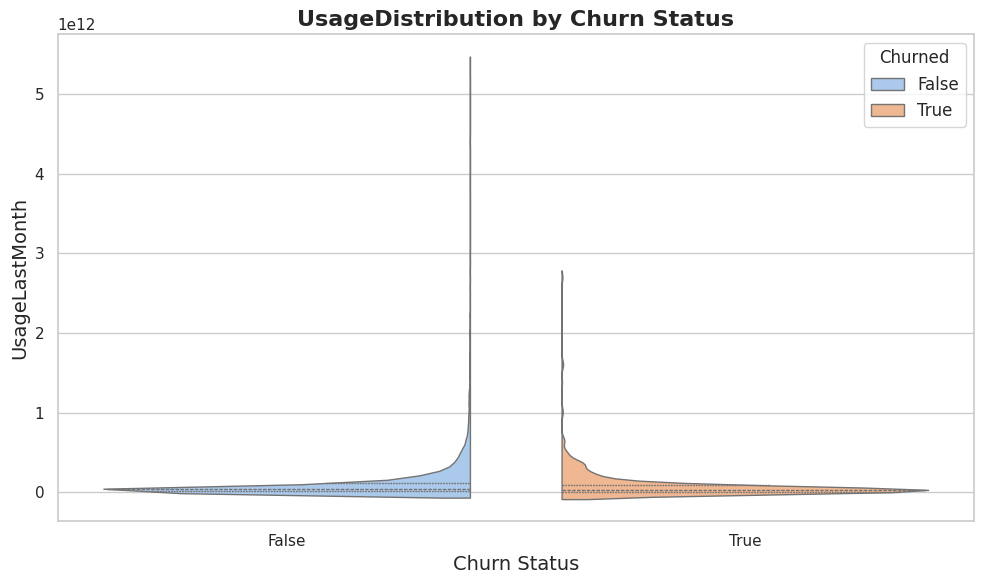

In [ ]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=client_df,
    x='Churned',
    y='UsageLastMonth',
    hue='Churned',  # Adds color differentiation by Churned
    split=True,  # Splits the violins for comparison
    inner="quartile",  # Shows quartiles inside the violin
    linewidth=1,  # Makes the edges clean and visible
)

# Add title and labels
plt.title("UsageDistribution by Churn Status", fontsize=16, fontweight='bold')
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("UsageLastMonth", fontsize=14)

# Add a legend
plt.legend(title="Churned", loc='upper right', fontsize=12)

# Make the plot pretty
plt.tight_layout()
plt.show()

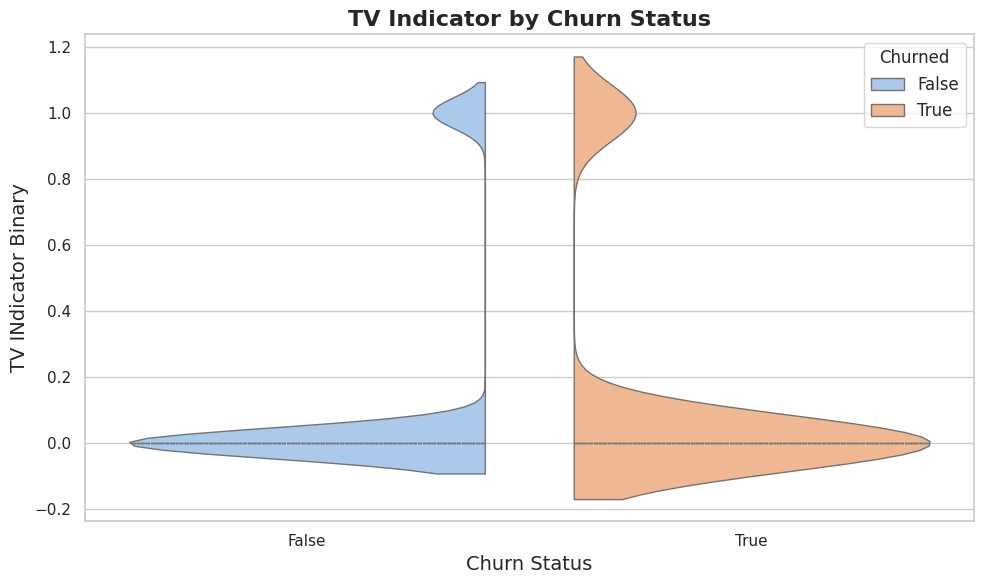

In [ ]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=client_df,
    x='Churned',
    y='TVInd',
    hue='Churned',  # Adds color differentiation by Churned
    split=True,  # Splits the violins for comparison
    inner="quartile",  # Shows quartiles inside the violin
    linewidth=1,  # Makes the edges clean and visible
)

# Add title and labels
plt.title("TV Indicator by Churn Status", fontsize=16, fontweight='bold')
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("TV INdicator Binary", fontsize=14)

# Add a legend
plt.legend(title="Churned", loc='upper right', fontsize=12)

# Make the plot pretty
plt.tight_layout()
plt.show()

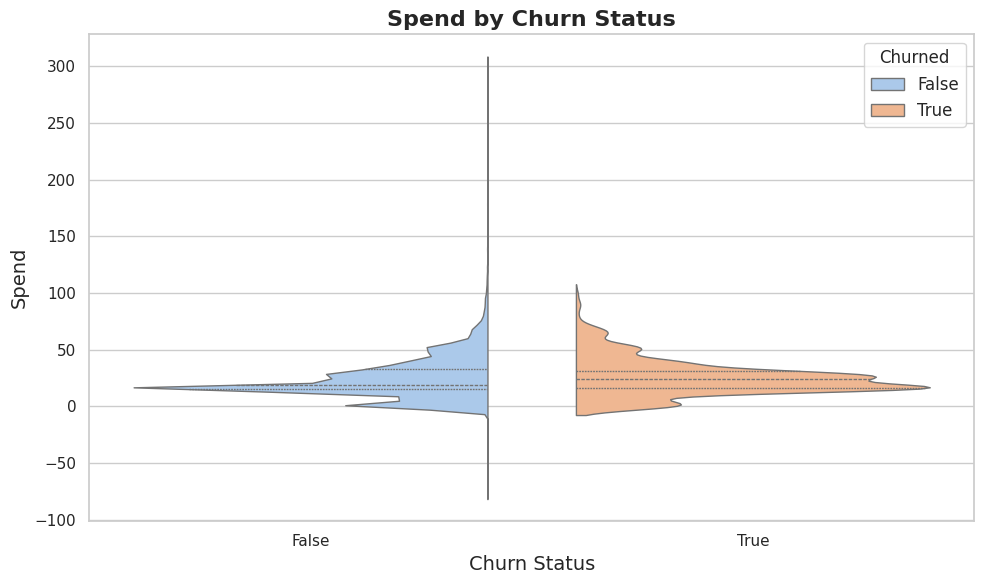

In [ ]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=client_df,
    x='Churned',
    y='SpendLastMonth',
    hue='Churned',  # Adds color differentiation by Churned
    split=True,  # Splits the violins for comparison
    inner="quartile",  # Shows quartiles inside the violin
    linewidth=1,  # Makes the edges clean and visible
)

# Add title and labels
plt.title("Spend by Churn Status", fontsize=16, fontweight='bold')
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("Spend", fontsize=14)

# Add a legend
plt.legend(title="Churned", loc='upper right', fontsize=12)

# Make the plot pretty
plt.tight_layout()
plt.show()

## Customer Care DF

In [ ]:
# Convert CancellationDate to datetime
cancellations_df['CancellationDate'] = pd.to_datetime(cancellations_df['CancellationDate'], dayfirst=True, errors='coerce')

# Merge CancellationDate into client_df
customer_care_df = customer_care_df.merge(
    cancellations_df[['UserID', 'CancellationDate']],
    on='UserID',
    how='left'
)

# Define Churned: 1 if CancellationDate is not null, else 0
customer_care_df['Churned'] = customer_care_df['CancellationDate'].notna().astype(int)

# Verify the merger
print("\nClient Data after merging CancellationDate and Churned:\n", customer_care_df.head())


Client Data after merging CancellationDate and Churned:
    UserID  StartDate Channel    Reason  Duration CancellationDate  Churned
0  C10019 2024-09-23    Call   Upgrade       928              NaT        0
1  C10446 2024-09-20    Call   Billing       261       2024-09-19        1
2  C10208 2024-07-08    Call  Coverage      1554       2024-08-12        1
3  C10276 2024-08-19  Retail   Service         0       2024-08-07        1
4  C11048 2024-08-22  Retail   Service         0       2024-08-22        1


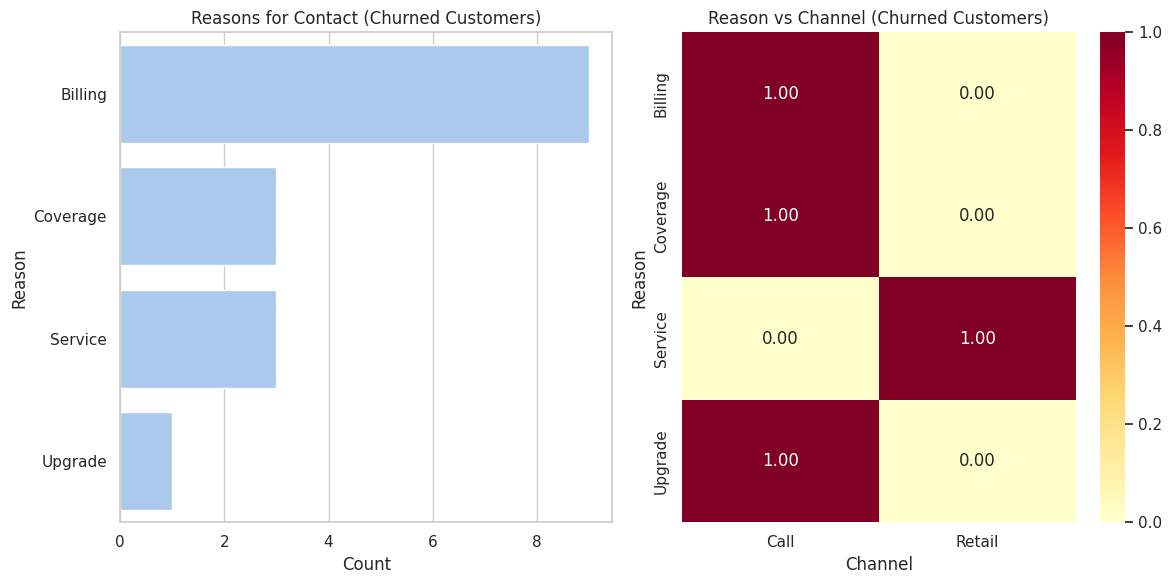


Contact Reason Distribution (%):
Reason
Billing     56.2
Coverage    18.8
Service     18.8
Upgrade      6.2
Name: count, dtype: float64


In [ ]:
def analyze_contact_reasons(df):
    df = df.copy()

    # Basic reason analysis for churned customers
    reason_analysis = df[df['Churned']==1]['Reason'].value_counts()

    # Calculate percentages
    reason_percentages = (reason_analysis / len(df[df['Churned']==1]) * 100).round(1)

    # Visualization
    plt.figure(figsize=(12, 6))

    # Subplot 1: Reason distribution for churned customers
    plt.subplot(1, 2, 1)
    sns.countplot(data=df[df['Churned']==1], y='Reason')
    plt.title('Reasons for Contact (Churned Customers)')
    plt.xlabel('Count')

    # Subplot 2: Reason by Channel
    plt.subplot(1, 2, 2)
    sns.heatmap(pd.crosstab(df[df['Churned']==1]['Reason'],
                           df[df['Churned']==1]['Channel'],
                           normalize='index'),
                annot=True,
                fmt='.2f',
                cmap='YlOrRd')
    plt.title('Reason vs Channel (Churned Customers)')

    plt.tight_layout()
    plt.show()

    return reason_percentages

# Run the analysis
reason_stats = analyze_contact_reasons(customer_care_df)
print("\nContact Reason Distribution (%):")
print(reason_stats)

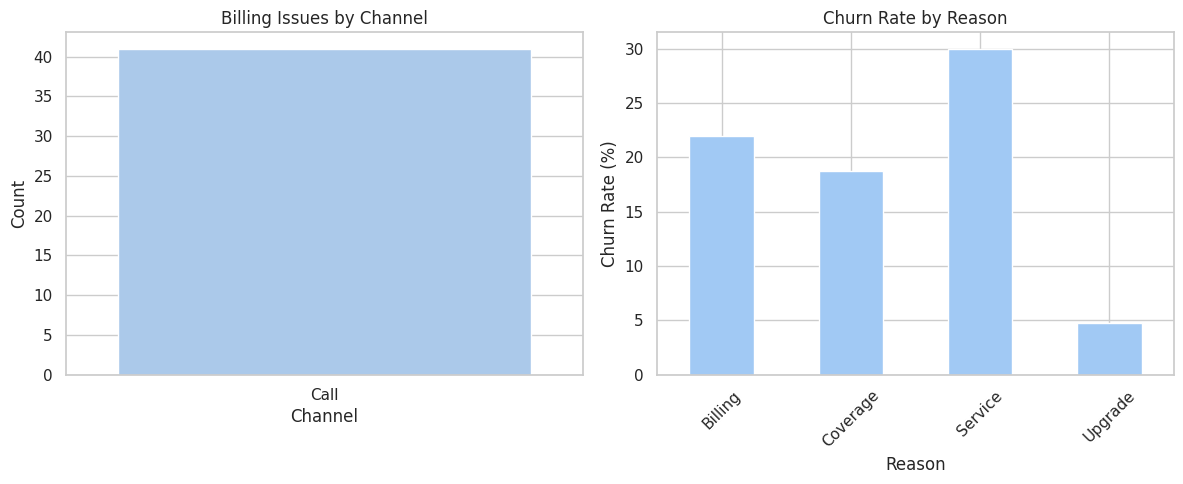


Key Findings:
Billing Issues: 41 customers (46.6% of all contacts)
Churn Rate for Billing Issues: 22.0%


In [ ]:
def analyze_billing_issues(df):
    df = df.copy()

    # Focus on billing issues since they're 56.2% of churns
    billing_df = df[df['Reason'] == 'Billing']

    # Analysis by channel for billing issues
    plt.figure(figsize=(12, 5))

    # Subplot 1: Billing issues by channel
    plt.subplot(1, 2, 1)
    sns.countplot(data=billing_df, x='Channel')
    plt.title('Billing Issues by Channel')
    plt.xlabel('Channel')
    plt.ylabel('Count')

    # Subplot 2: Churn rate for billing vs other reasons
    churn_by_reason = df.groupby('Reason')['Churned'].mean() * 100
    plt.subplot(1, 2, 2)
    churn_by_reason.plot(kind='bar')
    plt.title('Churn Rate by Reason')
    plt.ylabel('Churn Rate (%)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("\nKey Findings:")
    print(f"Billing Issues: {len(billing_df)} customers ({(len(billing_df)/len(df)*100):.1f}% of all contacts)")
    print(f"Churn Rate for Billing Issues: {(billing_df['Churned'].mean()*100):.1f}%")

    return churn_by_reason

# Run the analysis
reason_analysis = analyze_billing_issues(customer_care_df)

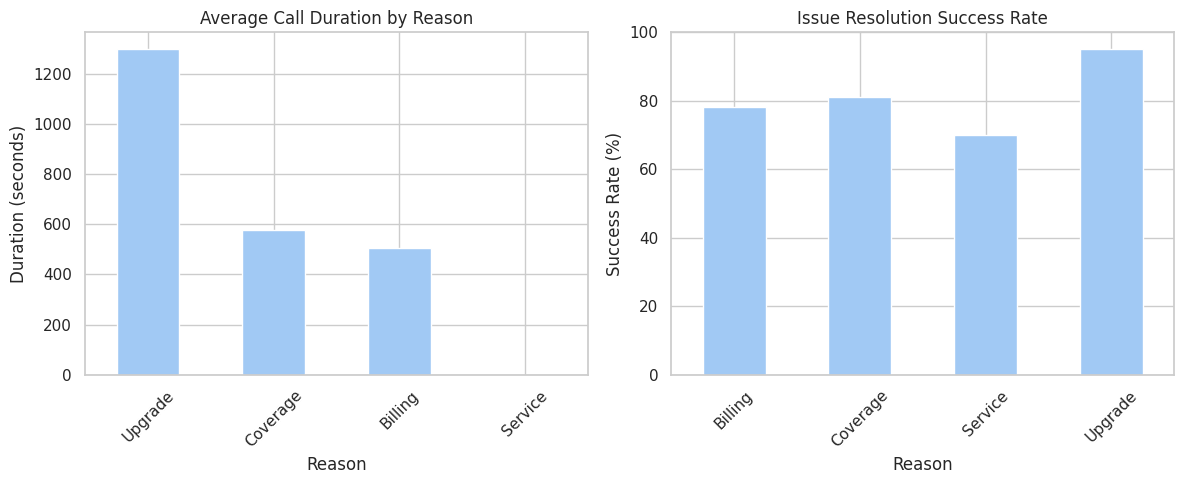

In [ ]:
def analyze_reason_severity(df):
    df = df.copy()

    # Calculate average duration by reason
    avg_duration = df.groupby('Reason')['Duration'].mean().sort_values(ascending=False)

    # Calculate resolution success rate (1 - churn rate)
    resolution_rate = (1 - df.groupby('Reason')['Churned'].mean()) * 100

    plt.figure(figsize=(12, 5))

    # Plot duration by reason
    plt.subplot(1, 2, 1)
    avg_duration.plot(kind='bar')
    plt.title('Average Call Duration by Reason')
    plt.ylabel('Duration (seconds)')
    plt.xticks(rotation=45)

    # Plot resolution success rate
    plt.subplot(1, 2, 2)
    resolution_rate.plot(kind='bar')
    plt.title('Issue Resolution Success Rate')
    plt.ylabel('Success Rate (%)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return avg_duration, resolution_rate

# Run analysis
duration_stats, resolution_stats = analyze_reason_severity(customer_care_df)

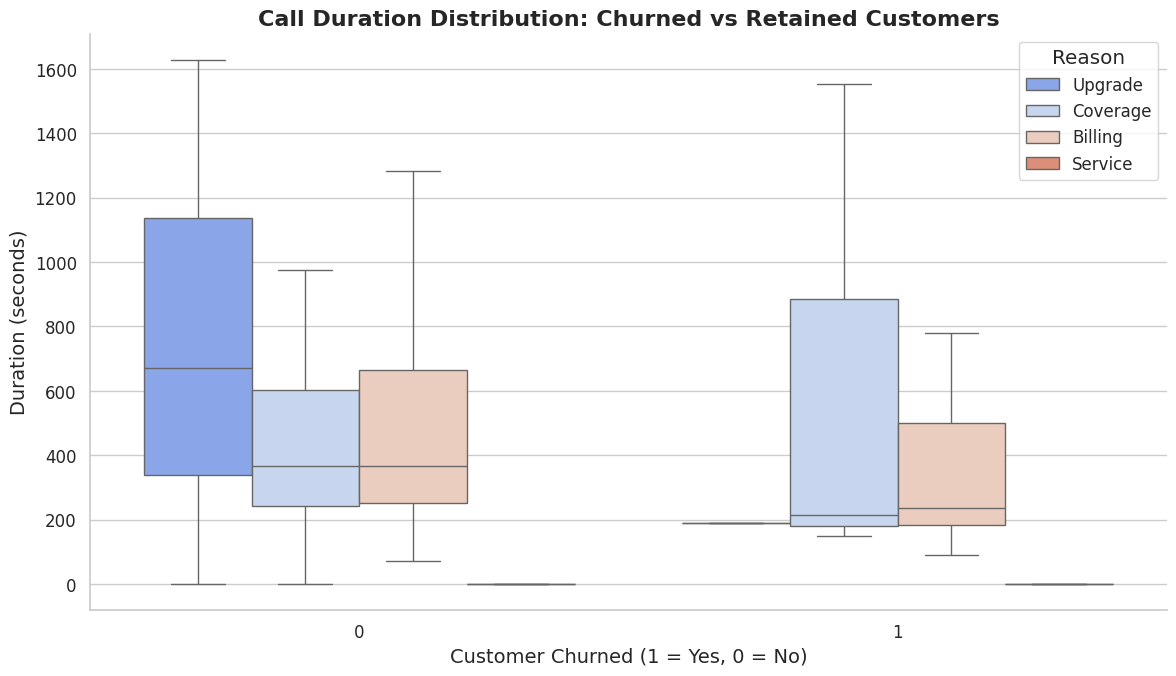

Correlation between Duration and Churn: -0.112


In [ ]:
def analyze_duration_churn_relationship(df):
    # Calculate correlation
    correlation = df['Duration'].corr(df['Churned'])

    # Set Seaborn style
    sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

    # Visualization of duration vs churn
    plt.figure(figsize=(12, 7))
    sns.boxplot(
        x='Churned',
        y='Duration',
        hue='Reason',
        data=df,
        palette="coolwarm",
        showfliers=False  # Hides outliers for a cleaner plot
    )

    # Enhance plot aesthetics
    plt.title('Call Duration Distribution: Churned vs Retained Customers', fontsize=16, fontweight='bold')
    plt.ylabel('Duration (seconds)', fontsize=14)
    plt.xlabel('Customer Churned (1 = Yes, 0 = No)', fontsize=14)
    plt.legend(title='Reason', loc='upper right', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()

    # Show the plot
    plt.tight_layout()
    plt.show()

    print(f"Correlation between Duration and Churn: {correlation:.3f}")

    return correlation

# Run analysis
correlation = analyze_duration_churn_relationship(customer_care_df)

In [ ]:
import pandas as pd

def preprocess_customer_care_data(df):
    # One-hot encode the 'Channel' column
    channel_encoded = pd.get_dummies(df['Channel'], prefix='Channel')

    # One-hot encode the 'Reason' column
    reason_encoded = pd.get_dummies(df['Reason'], prefix='Reason')

    # Calculate the time delta between 'StartDate' and 'CancellationDate'
    df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
    df['CancellationDate'] = pd.to_datetime(df['CancellationDate'], errors='coerce')

    # If there's a CancellationDate, calculate the time difference, otherwise NaN
    df['TimeDelta'] = (df['CancellationDate'] - df['StartDate']).dt.days

    # Group by 'UserID' and calculate max, min, and average durations
    user_duration_stats = df.groupby('UserID')['Duration'].agg(['max', 'min', 'mean']).reset_index()
    user_duration_stats.columns = ['UserID', 'MaxDuration', 'MinDuration', 'AvgDuration']

    # Count the number of interactions for each 'UserID' per 'Channel' and 'Reason'
    user_channel_count = df.groupby('UserID')['Channel'].value_counts().unstack(fill_value=0)
    user_reason_count = df.groupby('UserID')['Reason'].value_counts().unstack(fill_value=0)

    # Merge the counts back into the main dataframe
    df = df.merge(user_channel_count, on='UserID', how='left')
    df = df.merge(user_reason_count, on='UserID', how='left')

    # Merge the duration stats back into the original dataframe
    df = pd.merge(df, user_duration_stats, on='UserID', how='left')

    # Concatenate the one-hot encoded 'Channel' and 'Reason' columns
    df_encoded = pd.concat([df, channel_encoded, reason_encoded], axis=1)

    # Drop the original 'Channel' and 'Reason' columns
    df_encoded = df_encoded.drop(columns=['Channel', 'Reason','CancellationDate','StartDate','Churned','Duration'])

    return df_encoded

# Apply the preprocessing function to your existing DataFrame
customer_care_processed = preprocess_customer_care_data(customer_care_df)

In [ ]:
# Remove duplicates based on 'UserID' and keep the one with the highest 'TimeDelta'
customer_care_processed = customer_care_processed.sort_values(by='TimeDelta', ascending=False).drop_duplicates(subset=['UserID'], keep='first')

# Display the cleaned DataFrame
print(customer_care_processed.head())

    UserID  TimeDelta  Call  Retail  Billing  Coverage  Service  Upgrade  \
2   C10208       35.0     1       0        0         1        0        0   
26  C10681       21.0     1       0        1         0        0        0   
15  C11244       14.0     1       0        1         0        0        0   
74  C10616        6.0     2       0        0         2        0        0   
37  C10863        4.0     1       0        1         0        0        0   

    MaxDuration  MinDuration  AvgDuration  Channel_Call  Channel_Retail  \
2          1554         1554       1554.0          True           False   
26          215          215        215.0          True           False   
15          182          182        182.0          True           False   
74          215          148        181.5          True           False   
37          780          780        780.0          True           False   

    Reason_Billing  Reason_Coverage  Reason_Service  Reason_Upgrade  
2            False    

In [ ]:
# Convert CancellationDate to datetime
cancellations_df['CancellationDate'] = pd.to_datetime(cancellations_df['CancellationDate'], dayfirst=True, errors='coerce')

# Merge CancellationDate into client_df
customer_care_processed  = customer_care_processed .merge(
    cancellations_df[['UserID', 'CancellationDate']],
    on='UserID',
    how='left'
)

# Define Churned: 1 if CancellationDate is not null, else 0
customer_care_processed['Churned'] = customer_care_processed ['CancellationDate'].notna().astype(int)

# Verify the merger
print("\nClient Data after merging CancellationDate and Churned:\n", customer_care_processed[['UserID', 'Churned']].head())


Client Data after merging CancellationDate and Churned:
    UserID  Churned
0  C10208        1
1  C10681        1
2  C11244        1
3  C10616        1
4  C10863        1


Numerical columns identified:
1. TimeDelta
2. Call
3. Retail
4. Billing
5. Coverage
6. Service
7. Upgrade
8. MaxDuration
9. MinDuration
10. AvgDuration
11. Churned


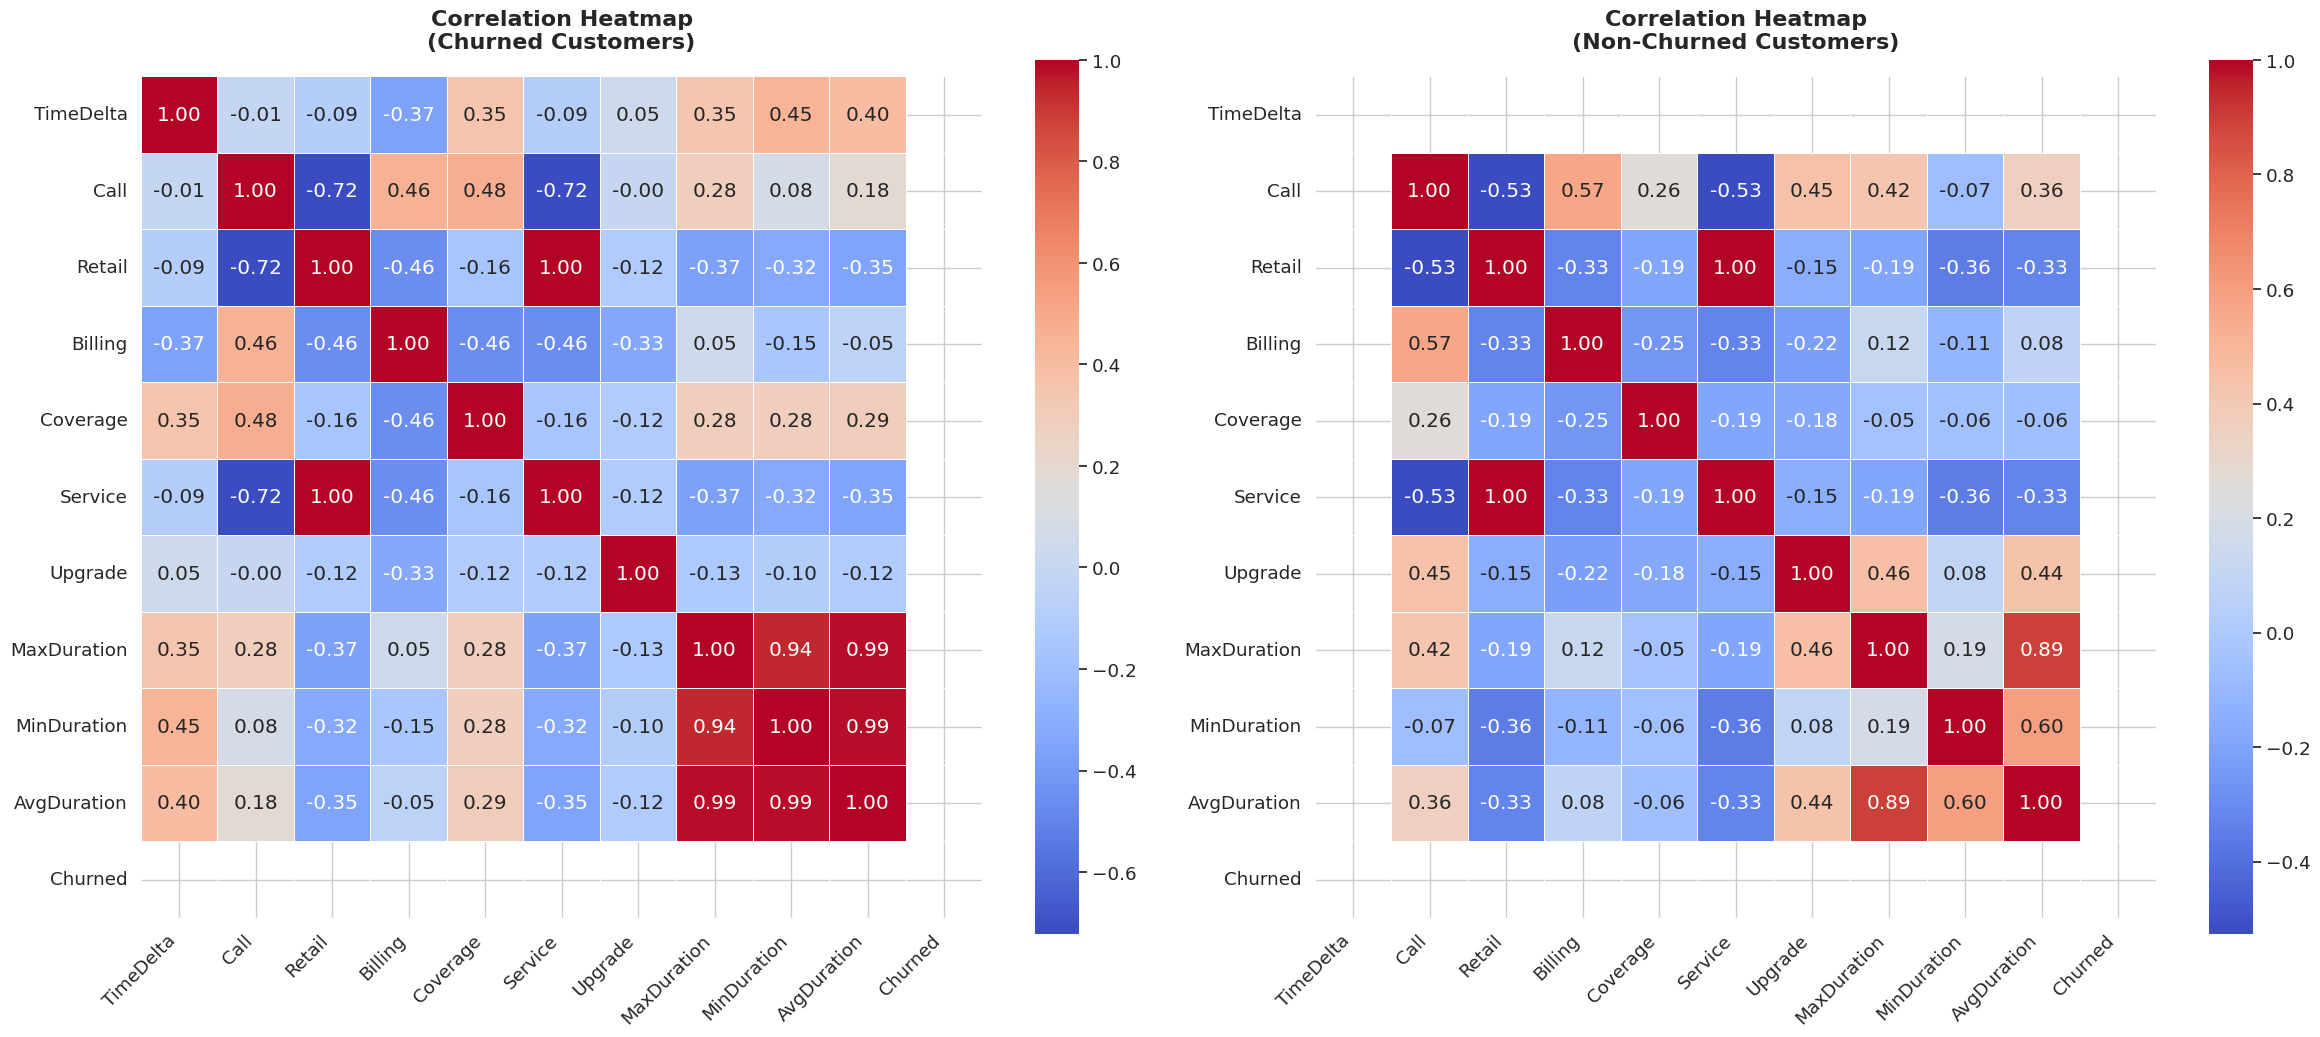


Difference in correlations (Churned - Non-Churned):
             TimeDelta  Call  Retail  Billing  Coverage  Service  Upgrade  \
TimeDelta          NaN   NaN     NaN      NaN       NaN      NaN      NaN   
Call               NaN  0.00   -0.20    -0.11      0.22    -0.20    -0.45   
Retail             NaN -0.20    0.00    -0.13      0.03     0.00     0.04   
Billing            NaN -0.11   -0.13     0.00     -0.20    -0.13    -0.11   
Coverage           NaN  0.22    0.03    -0.20      0.00     0.03     0.06   
Service            NaN -0.20    0.00    -0.13      0.03     0.00     0.04   
Upgrade            NaN -0.45    0.04    -0.11      0.06     0.04     0.00   
MaxDuration        NaN -0.14   -0.18    -0.07      0.33    -0.18    -0.59   
MinDuration        NaN  0.15    0.03    -0.04      0.34     0.03    -0.18   
AvgDuration        NaN -0.17   -0.02    -0.13      0.35    -0.02    -0.55   
Churned            NaN   NaN     NaN      NaN       NaN      NaN      NaN   

             MaxDurati

In [ ]:
# First, let's identify numerical columns
numerical_columns = customer_care_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Numerical columns identified:")
for i, col in enumerate(numerical_columns, 1):
    print(f"{i}. {col}")

# Filter DataFrames for churned and non-churned customers
churned_customers = customer_care_processed[customer_care_processed['Churned'] == 1]
non_churned_customers = customer_care_processed[customer_care_processed['Churned'] == 0]

# Calculate correlation matrices
correlation_matrix_churned = churned_customers[numerical_columns].corr()
correlation_matrix_non_churned = non_churned_customers[numerical_columns].corr()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Create heatmap for churned customers
sns.heatmap(
    correlation_matrix_churned,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar=True,
    square=True,
    linewidths=0.5,
    ax=ax1
)
ax1.set_title('Correlation Heatmap\n(Churned Customers)',
              fontsize=16,
              fontweight='bold',
              pad=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Create heatmap for non-churned customers
sns.heatmap(
    correlation_matrix_non_churned,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar=True,
    square=True,
    linewidths=0.5,
    ax=ax2
)
ax2.set_title('Correlation Heatmap\n(Non-Churned Customers)',
              fontsize=16,
              fontweight='bold',
              pad=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()

# Print the difference in correlations (optional)
correlation_difference = correlation_matrix_churned - correlation_matrix_non_churned
print("\nDifference in correlations (Churned - Non-Churned):")
print(correlation_difference.round(2))

In [ ]:
# Drop the redundant numeric columns since we already have boolean indicators
columns_to_drop = ['Call', 'Retail', 'Billing', 'Coverage', 'Service', 'Upgrade','AvgDuration']
customer_care_processed = customer_care_processed.drop(columns=columns_to_drop)

In [ ]:
customer_care_processed.head()

UserID  TimeDelta  MaxDuration  MinDuration  Channel_Call  Channel_Retail  \
0  C10208       35.0         1554         1554          True           False   
1  C10681       21.0          215          215          True           False   
2  C11244       14.0          182          182          True           False   
3  C10616        6.0          215          148          True           False   
4  C10863        4.0          780          780          True           False   

   Reason_Billing  Reason_Coverage  Reason_Service  Reason_Upgrade  \
0           False             True           False           False   
1            True            False           False           False   
2            True            False           False           False   
3           False             True           False           False   
4            True            False           False           False   

  CancellationDate  Churned  
0       2024-08-12        1  
1       2024-06-28        1  
2       2024-08-22        1  
3       2024-09-30        1  
4       2024-05-11        1

In [ ]:
# Drop the redundant numeric columns since we already have boolean indicators
columns_to_drop = ['Churned','CancellationDate']
customer_care_processed = customer_care_processed.drop(columns=columns_to_drop)

## Discount DF

In [ ]:
# Convert CancellationDate to datetime
cancellations_df['CancellationDate'] = pd.to_datetime(cancellations_df['CancellationDate'], dayfirst=True, errors='coerce')

# Merge CancellationDate into client_df
discount_df = discount_df.merge(
    cancellations_df[['UserID', 'CancellationDate']],
    on='UserID',
    how='left'
)

# Define Churned: 1 if CancellationDate is not null, else 0
discount_df['Churned'] = discount_df['CancellationDate'].notna().astype(int)

# Verify the merger
print("\nClient Data after merging CancellationDate and Churned:\n", discount_df.head())


Client Data after merging CancellationDate and Churned:
    UserID  StartDate EndDate                    DiscountName CancellationDate  \
0  C11586 2024-10-24       ?  EUR15 Discount x12 month                    NaT   
1  C11291 2024-03-01       ?  EUR10 Discount x12 month                    NaT   
2  C11434 2024-07-23       ?  EUR5 Discount x12 month                     NaT   
3  C11289 2024-04-16       ?  EUR15 Discount x12 month                    NaT   
4  C11805 2024-01-04       ?  EUR20 Discount x12 month                    NaT   

   Churned  
0        0  
1        0  
2        0  
3        0  
4        0  


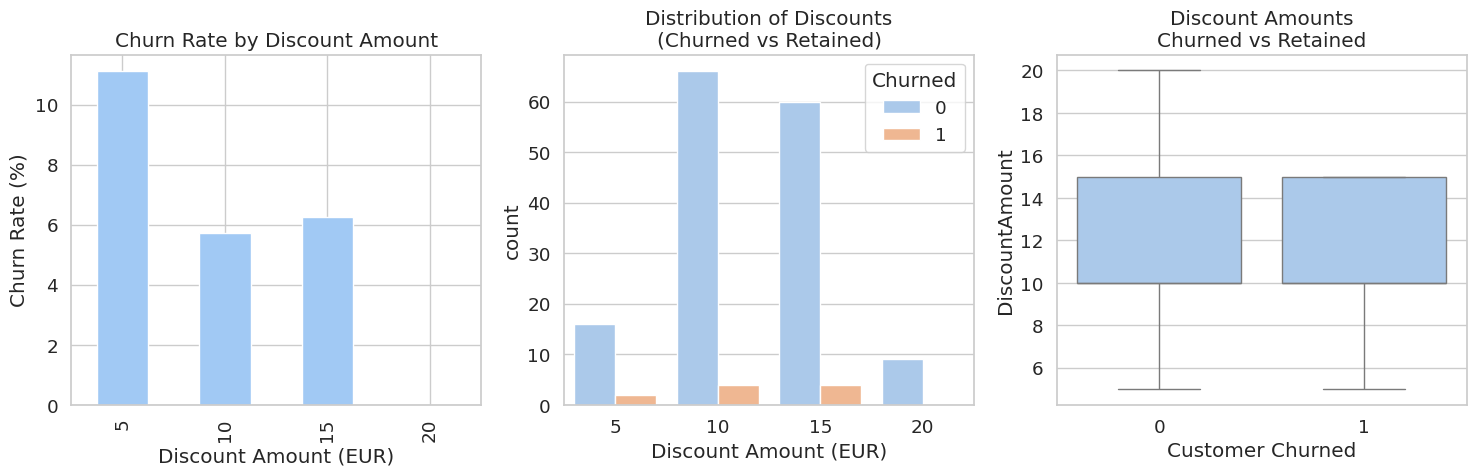


Churn Rate by Discount Amount:
€5 Discount: 11.1% churn rate (18 customers)
€10 Discount: 5.7% churn rate (70 customers)
€15 Discount: 6.2% churn rate (64 customers)
€20 Discount: 0.0% churn rate (9 customers)

Chi-square p-value: 0.7131


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

def analyze_discount_impact(df):
    df = df.copy()

    # Extract discount amount from DiscountName
    df['DiscountAmount'] = df['DiscountName'].str.extract('(\d+)').astype(int)

    # Analysis plots
    plt.figure(figsize=(15, 5))

    # 1. Churn rate by discount amount
    plt.subplot(1, 3, 1)
    churn_by_discount = df.groupby('DiscountAmount')['Churned'].mean() * 100
    churn_by_discount.plot(kind='bar')
    plt.title('Churn Rate by Discount Amount')
    plt.ylabel('Churn Rate (%)')
    plt.xlabel('Discount Amount (EUR)')

    # 2. Distribution of discounts
    plt.subplot(1, 3, 2)
    sns.countplot(data=df, x='DiscountAmount', hue='Churned')
    plt.title('Distribution of Discounts\n(Churned vs Retained)')
    plt.xlabel('Discount Amount (EUR)')

    # 3. Box plot of discount amounts
    plt.subplot(1, 3, 3)
    sns.boxplot(data=df, x='Churned', y='DiscountAmount')
    plt.title('Discount Amounts\nChurned vs Retained')
    plt.xlabel('Customer Churned')

    plt.tight_layout()
    plt.show()

    # Statistical summary
    print("\nChurn Rate by Discount Amount:")
    for amount in sorted(df['DiscountAmount'].unique()):
        subset = df[df['DiscountAmount'] == amount]
        churn_rate = (subset['Churned'].mean() * 100).round(1)
        count = len(subset)
        print(f"€{amount} Discount: {churn_rate}% churn rate ({count} customers)")

    # Chi-square test for independence
    contingency = pd.crosstab(df['DiscountAmount'], df['Churned'])
    chi2, p_value = chi2_contingency(contingency)[:2]
    print(f"\nChi-square p-value: {p_value:.4f}")

# Run the analysis
analyze_discount_impact(discount_df)

<ipython-input-39-e938fbd19203>:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IsCurrentDiscount'] = df['EndDate'].str.contains('\?').fillna(False)


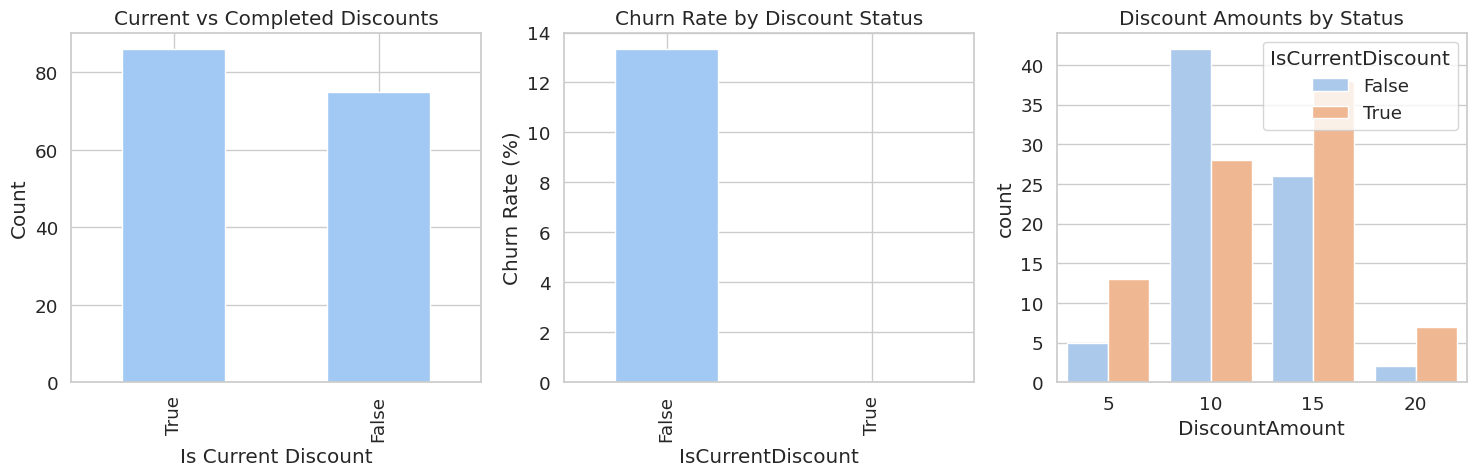


Discount Analysis:

Current Discounts:
Count: 86
Average Amount: €12.3
Churn Rate: 0.0%

Detailed Breakdown:
                                  UserID  Churned
DiscountAmount IsCurrentDiscount                 
5              False                   5    0.400
               True                   13    0.000
10             False                  42    0.095
               True                   28    0.000
15             False                  26    0.154
               True                   38    0.000
20             False                   2    0.000
               True                    7    0.000


In [ ]:
def analyze_discount_details(df):
    df = df.copy()

    # Extract discount amount and duration
    df['DiscountAmount'] = df['DiscountName'].str.extract('(\d+)').astype(int)
    df['DiscountDuration'] = df['DiscountName'].str.extract('x(\d+)').astype(int)
    df['IsCurrentDiscount'] = df['EndDate'].str.contains('\?').fillna(False)

    # Analysis
    plt.figure(figsize=(15, 5))

    # 1. Current vs Completed Discounts
    plt.subplot(1, 3, 1)
    current_vs_completed = df['IsCurrentDiscount'].value_counts()
    current_vs_completed.plot(kind='bar')
    plt.title('Current vs Completed Discounts')
    plt.xlabel('Is Current Discount')
    plt.ylabel('Count')

    # 2. Churn Rate by Discount Status
    plt.subplot(1, 3, 2)
    churn_by_status = df.groupby('IsCurrentDiscount')['Churned'].mean() * 100
    churn_by_status.plot(kind='bar')
    plt.title('Churn Rate by Discount Status')
    plt.ylabel('Churn Rate (%)')

    # 3. Discount Amount Distribution
    plt.subplot(1, 3, 3)
    sns.countplot(data=df, x='DiscountAmount', hue='IsCurrentDiscount')
    plt.title('Discount Amounts by Status')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nDiscount Analysis:")
    print("\nCurrent Discounts:")
    current = df[df['IsCurrentDiscount']]
    print(f"Count: {len(current)}")
    print(f"Average Amount: €{current['DiscountAmount'].mean():.1f}")
    print(f"Churn Rate: {(current['Churned'].mean() * 100):.1f}%")

    # Group by amount and current status
    grouped = df.groupby(['DiscountAmount', 'IsCurrentDiscount']).agg({
        'UserID': 'count',
        'Churned': 'mean'
    }).round(3)

    print("\nDetailed Breakdown:")
    print(grouped)

# Run the analysis
analyze_discount_details(discount_df)

In [ ]:
# Parse `DiscountAmount` and `DurationMonths` from `DiscountName`
discount_df['DiscountAmount'] = discount_df['DiscountName'].str.extract(r'(\d+)').astype(int)  # Extract numerical amount
discount_df['DurationMonths'] = discount_df['DiscountName'].str.extract(r'x(\d+)').astype(int)  # Extract numerical duration

# Convert `StartDate` to datetime
discount_df['StartDate'] = pd.to_datetime(discount_df['StartDate'])

# Sort by UserID and StartDate to identify the most recent discount for each customer
discount_df = discount_df.sort_values(by=['UserID', 'StartDate'], ascending=[True, False])

# Keep only the most recent discount for each customer
discount_df = discount_df.drop_duplicates(subset=['UserID'], keep='first')

# Count the number of discounts for each customer
discount_count = discount_df.groupby('UserID').size().reset_index(name='DiscountCount')

# Merge the discount count data back into the DataFrame
discount_df = pd.merge(discount_df, discount_count, on='UserID', how='left')

# Adjust logic for `IsCurrentDiscount` and `PreviousDiscount`
discount_df['IsCurrentDiscount'] = np.where(discount_df['EndDate'] == '?', 1, 0)
discount_df['PreviousDiscount'] = np.where(discount_df['EndDate'] != '?', 1, 0)

In [ ]:
# Check for duplicate UserIDs
duplicates = discount_df[discount_df.duplicated(subset=['UserID'], keep=False)]

# View the rows with duplicate UserIDs
if not duplicates.empty:
    print("Duplicate UserIDs found:")
    print(duplicates)
else:
    print("No duplicate UserIDs found.")

No duplicate UserIDs found.


In [ ]:
# Drop the original  columns
discount_df = discount_df.drop(columns=['StartDate', 'EndDate','DiscountName'])

In [ ]:
discount_df.head()

UserID CancellationDate  Churned  DiscountAmount  DurationMonths  \
0  C10000              NaT        0              10              12   
1  C10007              NaT        0              10              12   
2  C10015              NaT        0              10              12   
3  C10017              NaT        0              10              12   
4  C10031              NaT        0              15              12   

   DiscountCount  IsCurrentDiscount  PreviousDiscount  
0              1                  1                 0  
1              1                  1                 0  
2              1                  0                 1  
3              1                  1                 0  
4              1                  1                 0

In [ ]:
discount_df.head()

UserID CancellationDate  Churned  DiscountAmount  DurationMonths  \
0  C10000              NaT        0              10              12   
1  C10007              NaT        0              10              12   
2  C10015              NaT        0              10              12   
3  C10017              NaT        0              10              12   
4  C10031              NaT        0              15              12   

   DiscountCount  IsCurrentDiscount  PreviousDiscount  
0              1                  1                 0  
1              1                  1                 0  
2              1                  0                 1  
3              1                  1                 0  
4              1                  1                 0

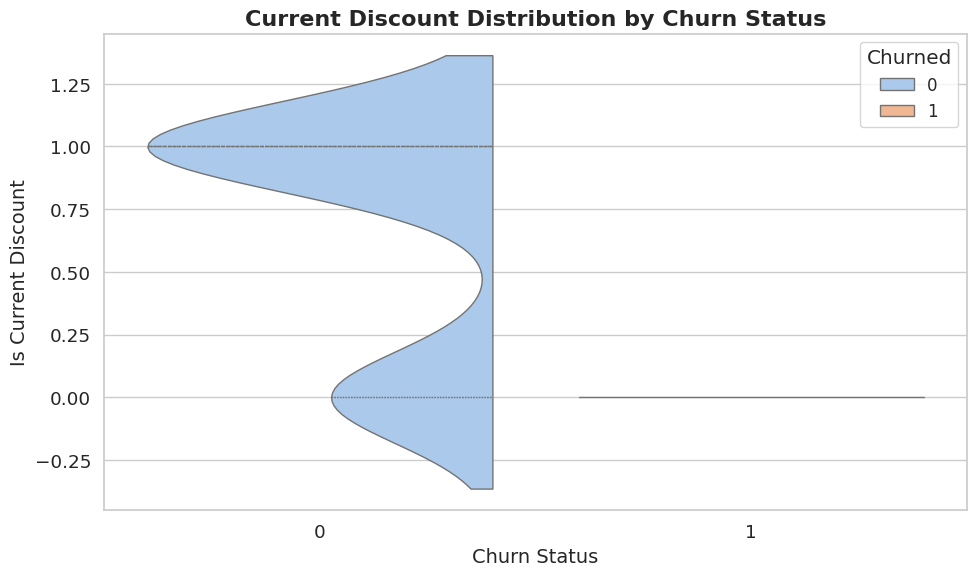


Distribution Statistics:
         count      mean       std  min  25%  50%  75%  max
Churned                                                    
0        113.0  0.681416  0.468003  0.0  0.0  1.0  1.0  1.0
1          9.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0


In [ ]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=discount_df,
    x='Churned',
    y='IsCurrentDiscount',  # Removed the extra tab character
    hue='Churned',
    split=True,
    inner="quartile",
    linewidth=1,
)

# Add title and labels
plt.title("Current Discount Distribution by Churn Status", fontsize=16, fontweight='bold')
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("Is Current Discount", fontsize=14)

# Add a legend
plt.legend(title="Churned", loc='upper right', fontsize=12)

# Make the plot pretty
plt.tight_layout()
plt.show()

# Let's also print the distribution statistics
print("\nDistribution Statistics:")
print(discount_df.groupby('Churned')['IsCurrentDiscount'].describe())

<ipython-input-46-b95d0e5d74c9>:22: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


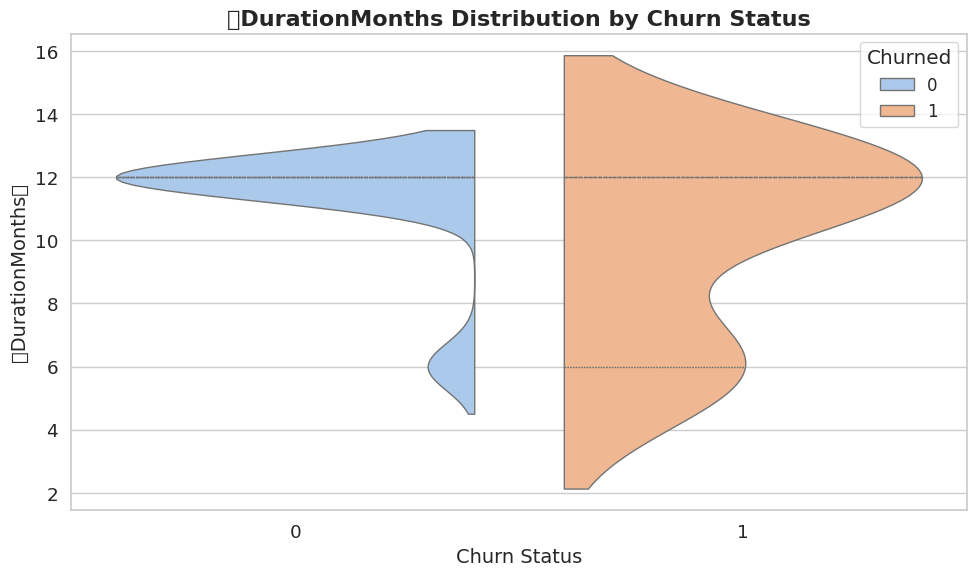

In [ ]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=discount_df,
    x='Churned',
    y='DurationMonths',  # Removed the extra tab character
    hue='Churned',
    split=True,
    inner="quartile",
    linewidth=1,
)

# Add title and labels
plt.title("	DurationMonths Distribution by Churn Status", fontsize=16, fontweight='bold')
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("	DurationMonths	", fontsize=14)

# Add a legend
plt.legend(title="Churned", loc='upper right', fontsize=12)

# Make the plot pretty
plt.tight_layout()
plt.show()

Numerical columns identified:
1. Churned
2. DiscountAmount
3. DurationMonths
4. DiscountCount
5. IsCurrentDiscount
6. PreviousDiscount


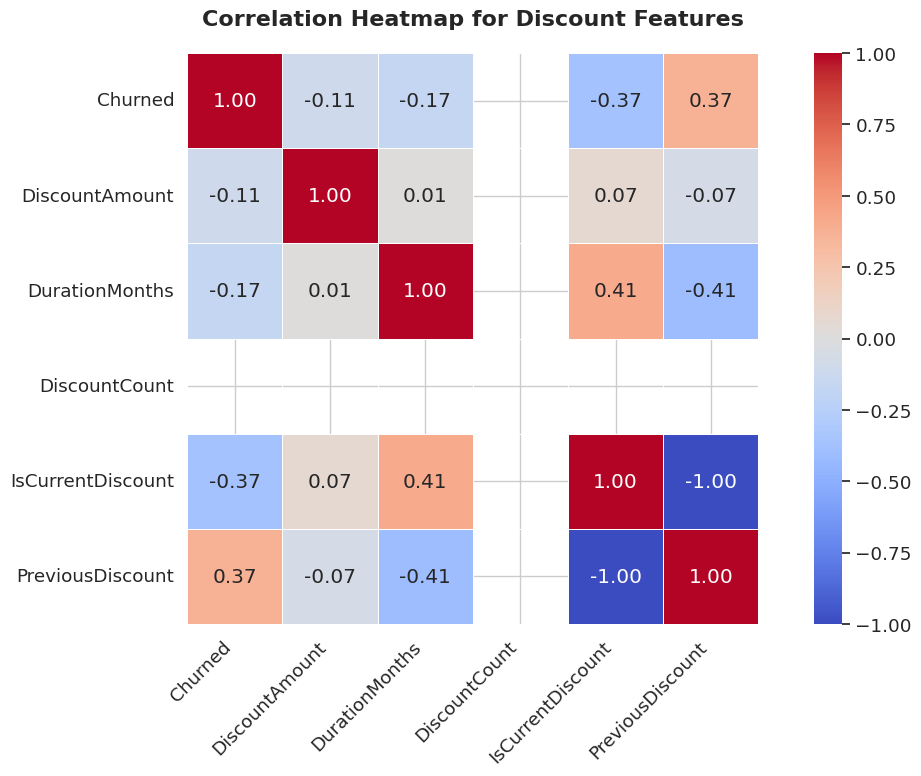

In [ ]:
# First, let's identify numerical columns
numerical_columns = discount_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Numerical columns identified:")
for i, col in enumerate(numerical_columns, 1):
    print(f"{i}. {col}")

# Calculate correlation matrix
correlation_matrix = discount_df[numerical_columns].corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar=True,
    square=True,
    linewidths=0.5
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add title and adjust layout
plt.title('Correlation Heatmap for Discount Features',
          fontsize=16,
          fontweight='bold',
          pad=20)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# Exploratory Data Analysis & Transformations = Client DF


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 21038 entries, 0 to 25686
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   UserID                    21038 non-null  object        
 1   FiscalPeriod              21038 non-null  int64         
 2   UpdateDate                21038 non-null  datetime64[ns]
 3   StatusID                  21038 non-null  object        
 4   SegmentName               21038 non-null  object        
 5   DOB                       21038 non-null  object        
 6   ContractEndDate           15567 non-null  datetime64[ns]
 7   ContractType              21038 non-null  object        
 8   SpendLastMonth            20384 non-null  float64       
 9   TopupMethod               21038 non-null  object        
 10  StoreLocation             21038 non-null  object        
 11  InsuranceInd              20996 non-null  float64       
 12  Tenure

<ipython-input-48-b6796abb80da>:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
<ipython-input-48-b6796abb80da>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


<Figure size 1500x800 with 0 Axes>

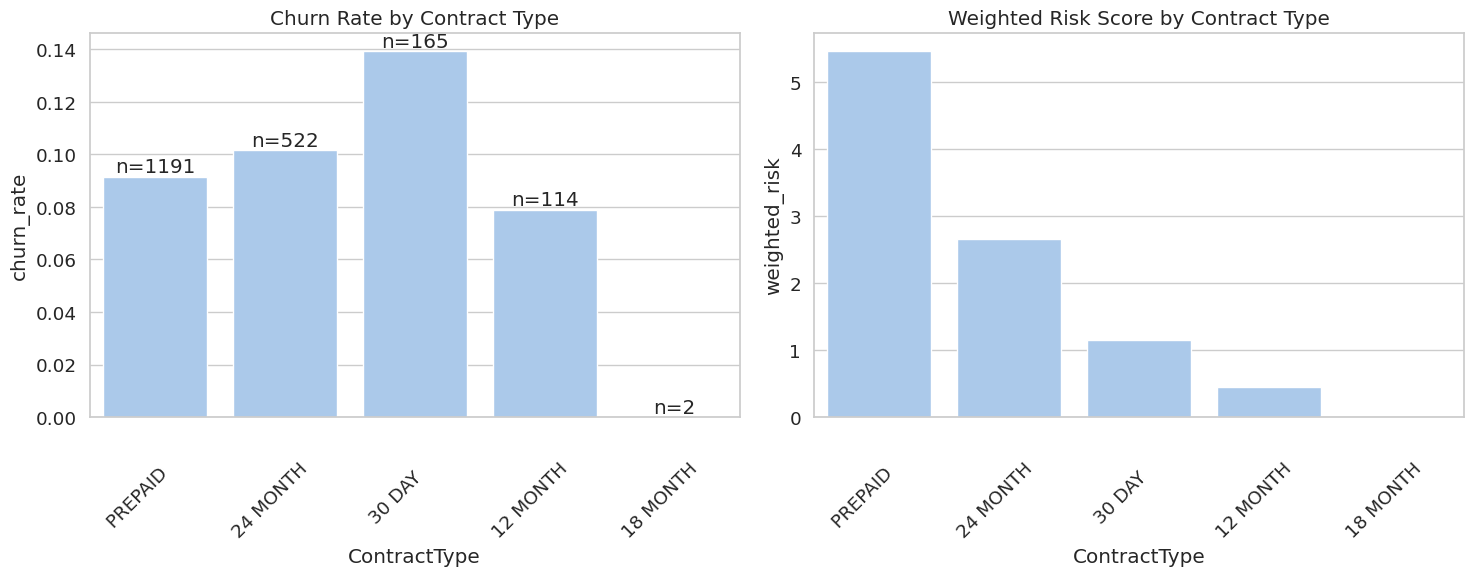


Detailed Proportional Analysis:
                 total_customers  churned_customers  churn_rate  customer_proportion  weighted_risk
ContractType                                                                                       
PREPAID                     1191              109.0      0.0915               0.5973         5.4664
24 MONTH                     522               53.0      0.1015               0.2618         2.6580
30 DAY                       165               23.0      0.1394               0.0827         1.1535
12 MONTH                     114                9.0      0.0789               0.0572         0.4514
18 MONTH                       2                0.0      0.0000               0.0010         0.0000

Contract Type Risk Hierarchy (0 = Lowest Risk, 4 = Highest Risk):
PREPAID        : 0
24 MONTH       : 1
30 DAY         : 2
12 MONTH       : 3
18 MONTH       : 4

Risk Segments:
High Risk (>75th percentile):
                 churn_rate  weighted_risk
ContractType    

In [ ]:
# Calculate proportional metrics
def analyze_contract_churn_proportionally(df):
    # First, let's check the actual column names in your DataFrame
    print("Available columns:", df.columns.tolist())

    # Assuming your contract type column might be named differently
    # Let's use 'ContractType' if that's the actual column name
    contract_column = 'ContractType'  # Adjust this to match your actual column name

    # Get the latest records
    latest_records = df.sort_values('UpdateDate').groupby('UserID').last().reset_index()

    # Calculate metrics
    contract_analysis = pd.DataFrame({
        'total_customers': latest_records[contract_column].value_counts(),
        'churned_customers': latest_records[latest_records['Churned']==1][contract_column].value_counts()
    }).fillna(0)

    # Calculate additional metrics
    contract_analysis['churn_rate'] = contract_analysis['churned_customers'] / contract_analysis['total_customers']
    contract_analysis['customer_proportion'] = contract_analysis['total_customers'] / len(latest_records)

    # Calculate weighted risk score
    contract_analysis['weighted_risk'] = (
        contract_analysis['churn_rate'] *
        contract_analysis['customer_proportion'] *
        100
    )

    return contract_analysis.sort_values('weighted_risk', ascending=False)

# Before running the analysis, let's examine the DataFrame
print("\nDataFrame Info:")
print(client_df.info())

# Run the analysis with error handling
try:
    proportional_analysis = analyze_contract_churn_proportionally(client_df)

    # Create visualization
    plt.figure(figsize=(15, 8))

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Churn Rates with sample sizes
    sns.barplot(x=proportional_analysis.index,
                y='churn_rate',
                data=proportional_analysis,
                ax=ax1)
    ax1.set_title('Churn Rate by Contract Type')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

    # Add sample size annotations
    for i, v in enumerate(proportional_analysis['total_customers']):
        ax1.text(i, proportional_analysis['churn_rate'].iloc[i],
                 f'n={int(v)}',
                 ha='center', va='bottom')

    # Plot 2: Weighted Risk Score
    sns.barplot(x=proportional_analysis.index,
                y='weighted_risk',
                data=proportional_analysis,
                ax=ax2)
    ax2.set_title('Weighted Risk Score by Contract Type')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\nDetailed Proportional Analysis:")
    print(proportional_analysis.round(4).to_string())

    # Create contract type hierarchy
    hierarchy = dict(zip(
        proportional_analysis.index,
        range(len(proportional_analysis))
    ))

    print("\nContract Type Risk Hierarchy (0 = Lowest Risk, {} = Highest Risk):".format(len(hierarchy)-1))
    for contract, risk_level in hierarchy.items():
        print(f"{contract}: {risk_level}")

    # Calculate risk segments
    print("\nRisk Segments:")
    print("High Risk (>75th percentile):")
    high_risk = proportional_analysis[proportional_analysis['weighted_risk'] >
                                    proportional_analysis['weighted_risk'].quantile(0.75)]
    print(high_risk[['churn_rate', 'weighted_risk']].round(4).to_string())

    print("\nLow Risk (<25th percentile):")
    low_risk = proportional_analysis[proportional_analysis['weighted_risk'] <
                                   proportional_analysis['weighted_risk'].quantile(0.25)]
    print(low_risk[['churn_rate', 'weighted_risk']].round(4).to_string())

except KeyError as e:
    print(f"Column not found: {e}")
    print("Please check your DataFrame columns and adjust the column names accordingly.")

In [ ]:
def add_contract_risk_weights(df):
    # First, calculate the contract risk analysis as before
    latest_records = df.sort_values('UpdateDate').groupby('UserID').last().reset_index()

    contract_analysis = pd.DataFrame({
        'total_customers': latest_records['ContractType'].value_counts(),
        'churned_customers': latest_records[latest_records['Churned']==1]['ContractType'].value_counts()
    }).fillna(0)

    # Calculate the risk metrics
    contract_analysis['churn_rate'] = contract_analysis['churned_customers'] / contract_analysis['total_customers']
    contract_analysis['customer_proportion'] = contract_analysis['total_customers'] / len(latest_records)
    contract_analysis['weighted_risk'] = (
        contract_analysis['churn_rate'] *
        contract_analysis['customer_proportion'] *
        100
    )

    # Create a dictionary mapping contract types to their weighted risk
    risk_mapping = contract_analysis['weighted_risk'].to_dict()

    # Add the weighted risk to the original dataframe
    df['ContractRiskScore'] = df['ContractType'].map(risk_mapping)

    return df

# Apply the function to add the new column
client_df = add_contract_risk_weights(client_df)

<ipython-input-50-0b37d4ed9472>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
<ipython-input-50-0b37d4ed9472>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_by_churn.index, y=avg_by_churn.values, ax=ax2,
<ipython-input-50-0b37d4ed9472>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['No', 'Yes'])


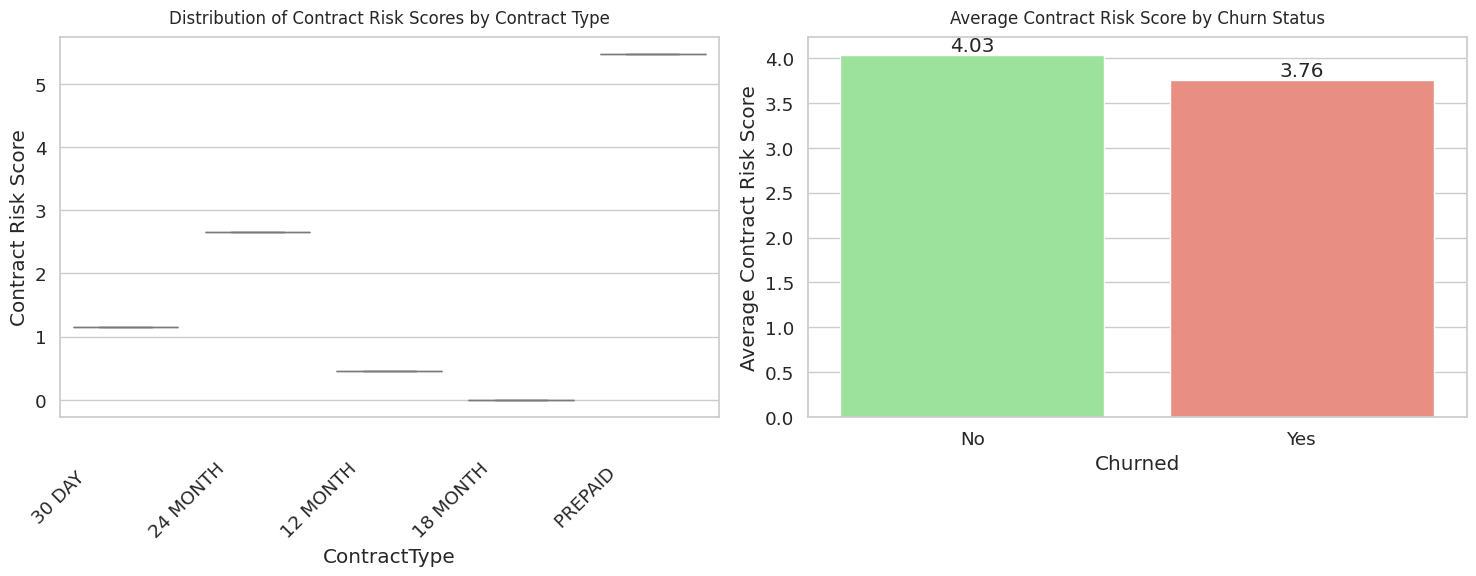

In [ ]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: Distribution by Contract Type (boxplot)
sns.boxplot(x='ContractType', y='ContractRiskScore', data=client_df, ax=ax1)
ax1.set_title('Distribution of Contract Risk Scores by Contract Type', fontsize=12, pad=10)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylabel('Contract Risk Score')

# Second subplot: Average by Churn Status (bar plot)
avg_by_churn = client_df.groupby('Churned')['ContractRiskScore'].mean()
sns.barplot(x=avg_by_churn.index, y=avg_by_churn.values, ax=ax2,
           palette=['lightgreen', 'salmon'])  # Green for non-churned, Red for churned

# Add value labels on top of bars
for i, v in enumerate(avg_by_churn.values):
    ax2.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Customize second subplot
ax2.set_title('Average Contract Risk Score by Churn Status', fontsize=12, pad=10)
ax2.set_xlabel('Churned')
ax2.set_ylabel('Average Contract Risk Score')
ax2.set_xticklabels(['No', 'Yes'])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Client DF: Spend & Usage

In [ ]:
def calculate_user_trends(df):
    """
    Calculate usage and spend trends per user over time
    Returns two dataframes with trend metrics per user
    """
    # Convert UpdateDate to datetime if not already
    df['UpdateDate'] = pd.to_datetime(df['UpdateDate'])

    def calculate_metric_trend(data, metric_column):
        # Sort by date and remove zeros/NaNs
        valid_data = data[data[metric_column] > 0].sort_values('UpdateDate')

        if len(valid_data) < 2:  # Need at least 2 points for a trend
            return None

        # Calculate period-over-period changes
        changes = valid_data[metric_column].pct_change()
        avg_change = changes.mean()

        # Calculate linear regression for more sophisticated trend
        x = (valid_data['UpdateDate'] - valid_data['UpdateDate'].min()).dt.days
        y = valid_data[metric_column]
        if len(x) > 1:  # Ensure we have enough points
            slope = np.polyfit(x, y, 1)[0]
        else:
            slope = 0

        return {
            'user_id': data['UserID'].iloc[0],
            'num_records': len(valid_data),
            'first_date': valid_data['UpdateDate'].min(),
            'last_date': valid_data['UpdateDate'].max(),
            'first_value': valid_data[metric_column].iloc[0],
            'last_value': valid_data[metric_column].iloc[-1],
            'avg_change': avg_change,
            'trend_slope': slope,
            'trend_direction': 'Decreasing' if slope < 0 else 'Increasing' if slope > 0 else 'Stable'
        }

    # Calculate trends for each metric
    spend_trends = []
    usage_trends = []

    for user_id, user_data in df.groupby('UserID'):
        # Calculate spend trends
        spend_result = calculate_metric_trend(user_data, 'SpendLastMonth')
        if spend_result:
            spend_trends.append(spend_result)

        # Calculate usage trends
        usage_result = calculate_metric_trend(user_data, 'UsageLastMonth')
        if usage_result:
            usage_trends.append(usage_result)

    # Convert to DataFrames
    spend_df = pd.DataFrame(spend_trends)
    usage_df = pd.DataFrame(usage_trends)

    return spend_df, usage_df

# Function to summarize trends
def summarize_trends(trend_df, metric_name):
    print(f"\n{metric_name} Trend Summary:")
    print("-" * 50)
    print(f"Total users analyzed: {len(trend_df)}")
    print(f"Users with decreasing trend: {(trend_df['trend_direction'] == 'Decreasing').sum()}")
    print(f"Users with increasing trend: {(trend_df['trend_direction'] == 'Increasing').sum()}")
    print(f"Users with stable trend: {(trend_df['trend_direction'] == 'Stable').sum()}")
    print(f"\nAverage % change: {trend_df['avg_change'].mean():.2%}")

# Run the analysis
spend_trends, usage_trends = calculate_user_trends(client_df)

# Display summaries
summarize_trends(spend_trends, "Spend")
summarize_trends(usage_trends, "Usage")

# Display detailed example for a few users
print("\nDetailed Example (First 5 users with significant trends):")
print("-" * 50)
significant_trends = spend_trends[abs(spend_trends['trend_slope']) > spend_trends['trend_slope'].std()]
print(significant_trends.head().to_string())


Spend Trend Summary:
--------------------------------------------------
Total users analyzed: 1837
Users with decreasing trend: 869
Users with increasing trend: 968
Users with stable trend: 0

Average % change: 178.71%

Usage Trend Summary:
--------------------------------------------------
Total users analyzed: 1847
Users with decreasing trend: 661
Users with increasing trend: 1186
Users with stable trend: 0

Average % change: 13962405.29%

Detailed Example (First 5 users with significant trends):
--------------------------------------------------
   user_id  num_records first_date  last_date  first_value  last_value  avg_change  trend_slope trend_direction
2   C10002           12 2023-11-30 2024-10-31       18.700      18.700    0.260471     0.091895      Increasing
10  C10010           12 2023-11-30 2024-10-31       18.700      20.810    0.297892     0.081988      Increasing
17  C10017           12 2023-11-30 2024-10-31       20.320     109.190    0.345427     0.114172      Increas


Spend Trends Analysis - Churned vs Non-Churned

Churned Customers:
----------------------------------------
Total customers: 176
Decreasing trend: 69 (39.2%)
Increasing trend: 107 (60.8%)
Stable trend: 0 (0.0%)
Average % change: 42.30%
Average trend slope: 0.01
Median last value: 24.39

Non-Churned Customers:
----------------------------------------
Total customers: 1661
Decreasing trend: 800 (48.2%)
Increasing trend: 861 (51.8%)
Stable trend: 0 (0.0%)
Average % change: 193.17%
Average trend slope: 0.00
Median last value: 18.46

Risk Indicators:
----------------------------------------
Decreasing trend churn ratio: 0.81x
Relative change difference: -150.87%

Usage Trends Analysis - Churned vs Non-Churned

Churned Customers:
----------------------------------------
Total customers: 186
Decreasing trend: 90 (48.4%)
Increasing trend: 96 (51.6%)
Stable trend: 0 (0.0%)
Average % change: 1006559.34%
Average trend slope: -38107250.86
Median last value: 39088610727.45

Non-Churned Customers:


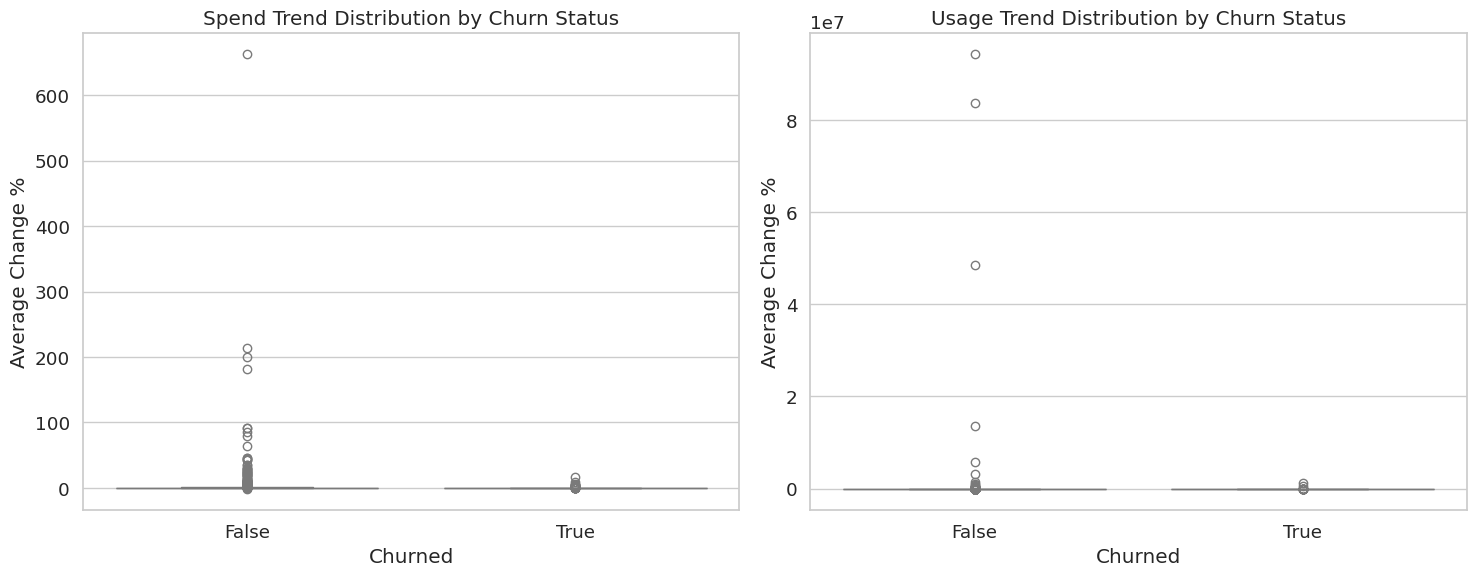

In [ ]:
def analyze_trends_by_churn(df):
    """
    Analyze and compare trends between churned and non-churned customers
    """
    spend_trends, usage_trends = calculate_user_trends(df)

    # Merge churn information back to trend dataframes
    churn_data = df[['UserID', 'Churned']].drop_duplicates()
    spend_trends = spend_trends.merge(churn_data, left_on='user_id', right_on='UserID', how='left')
    usage_trends = usage_trends.merge(churn_data, left_on='user_id', right_on='UserID', how='left')

    def print_comparative_analysis(trends_df, metric_name):
        print(f"\n{metric_name} Trends Analysis - Churned vs Non-Churned")
        print("=" * 70)

        # Separate churned and non-churned
        churned = trends_df[trends_df['Churned'] == 1]
        non_churned = trends_df[trends_df['Churned'] == 0]

        # Calculate statistics
        stats = {
            'Churned': {
                'count': len(churned),
                'decreasing': (churned['trend_direction'] == 'Decreasing').sum(),
                'increasing': (churned['trend_direction'] == 'Increasing').sum(),
                'stable': (churned['trend_direction'] == 'Stable').sum(),
                'avg_change': churned['avg_change'].mean(),
                'avg_slope': churned['trend_slope'].mean(),
                'median_last_value': churned['last_value'].median()
            },
            'Non-Churned': {
                'count': len(non_churned),
                'decreasing': (non_churned['trend_direction'] == 'Decreasing').sum(),
                'increasing': (non_churned['trend_direction'] == 'Increasing').sum(),
                'stable': (non_churned['trend_direction'] == 'Stable').sum(),
                'avg_change': non_churned['avg_change'].mean(),
                'avg_slope': non_churned['trend_slope'].mean(),
                'median_last_value': non_churned['last_value'].median()
            }
        }

        # Print detailed comparison
        for category in ['Churned', 'Non-Churned']:
            print(f"\n{category} Customers:")
            print("-" * 40)
            print(f"Total customers: {stats[category]['count']}")
            if stats[category]['count'] > 0:  # Avoid division by zero
                print(f"Decreasing trend: {stats[category]['decreasing']} "
                      f"({stats[category]['decreasing']/stats[category]['count']:.1%})")
                print(f"Increasing trend: {stats[category]['increasing']} "
                      f"({stats[category]['increasing']/stats[category]['count']:.1%})")
                print(f"Stable trend: {stats[category]['stable']} "
                      f"({stats[category]['stable']/stats[category]['count']:.1%})")
                print(f"Average % change: {stats[category]['avg_change']:.2%}")
                print(f"Average trend slope: {stats[category]['avg_slope']:.2f}")
                print(f"Median last value: {stats[category]['median_last_value']:.2f}")

        # Calculate and print risk indicators
        if stats['Churned']['count'] > 0 and stats['Non-Churned']['count'] > 0:
            print("\nRisk Indicators:")
            print("-" * 40)
            decreasing_churn_ratio = (stats['Churned']['decreasing']/stats['Churned']['count']) / \
                                   (stats['Non-Churned']['decreasing']/stats['Non-Churned']['count'])
            print(f"Decreasing trend churn ratio: {decreasing_churn_ratio:.2f}x")
            print(f"Relative change difference: "
                  f"{stats['Churned']['avg_change'] - stats['Non-Churned']['avg_change']:.2%}")

        return stats

    # Run analysis for both metrics
    spend_stats = print_comparative_analysis(spend_trends, "Spend")
    usage_stats = print_comparative_analysis(usage_trends, "Usage")

    # Create visualization
    plt.figure(figsize=(15, 6))

    # Spend trends distribution
    plt.subplot(1, 2, 1)
    sns.boxplot(data=spend_trends, x='Churned', y='avg_change')
    plt.title('Spend Trend Distribution by Churn Status')
    plt.ylabel('Average Change %')

    # Usage trends distribution
    plt.subplot(1, 2, 2)
    sns.boxplot(data=usage_trends, x='Churned', y='avg_change')
    plt.title('Usage Trend Distribution by Churn Status')
    plt.ylabel('Average Change %')

    plt.tight_layout()
    plt.show()

    return spend_stats, usage_stats

# Run the analysis
spend_stats, usage_stats = analyze_trends_by_churn(client_df)

In [ ]:
def validate_data_points(df):
    """
    Validate how many actual data points we're using per customer
    """
    results = []
    for user_id, user_data in df.groupby('UserID'):
        usage_points = len(user_data[user_data['UsageLastMonth'] > 0])
        spend_points = len(user_data[user_data['SpendLastMonth'] > 0])
        total_records = len(user_data)

        results.append({
            'UserID': user_id,
            'Total_Records': total_records,
            'Valid_Usage_Points': usage_points,
            'Valid_Spend_Points': spend_points,
            'Usage_Coverage': usage_points/total_records,
            'Spend_Coverage': spend_points/total_records
        })

    return pd.DataFrame(results)

# Run validation
validation_df = validate_data_points(client_df)
print("\nData Coverage Statistics:")
print(validation_df[['Valid_Usage_Points', 'Valid_Spend_Points',
                    'Usage_Coverage', 'Spend_Coverage']].describe())

# Show examples of partial coverage
print("\nExamples of Partial Coverage:")
partial_coverage = validation_df[
    (validation_df['Usage_Coverage'] < 1) |
    (validation_df['Spend_Coverage'] < 1)
].head()
print(partial_coverage)


Data Coverage Statistics:
       Valid_Usage_Points  Valid_Spend_Points  Usage_Coverage  Spend_Coverage
count         1994.000000         1994.000000     1994.000000     1994.000000
mean             9.711635            9.543631        0.889155        0.885543
std              3.886058            3.777206        0.259493        0.238646
min              0.000000            0.000000        0.000000        0.000000
25%              9.000000            8.000000        0.916667        0.916667
50%             12.000000           12.000000        1.000000        1.000000
75%             12.000000           12.000000        1.000000        1.000000
max             12.000000           12.000000        1.000000        1.000000

Examples of Partial Coverage:
    UserID  Total_Records  Valid_Usage_Points  Valid_Spend_Points  \
5   C10005             12                   0                  12   
22  C10022             12                   1                  12   
30  C10030             12        

In [ ]:
def create_client_trends_df(df):
    """
    Create a simplified client_trends DataFrame with ONLY trend metrics
    """
    spend_trends, usage_trends = calculate_user_trends(df)

    # Select only needed columns and rename
    spend_trends = spend_trends[['user_id', 'avg_change', 'trend_slope', 'trend_direction', 'last_value']]
    usage_trends = usage_trends[['user_id', 'avg_change', 'trend_slope', 'trend_direction', 'last_value']]

    # Rename columns to be more descriptive
    spend_trends.columns = ['UserID', 'spend_avg_change', 'spend_trend_slope', 'spend_trend_direction', 'spend_last_value']
    usage_trends.columns = ['UserID', 'usage_avg_change', 'usage_trend_slope', 'usage_trend_direction', 'usage_last_value']

    # Merge spend and usage trends
    client_trends = pd.merge(spend_trends, usage_trends, on='UserID', how='outer')

    return client_trends

# Create the pure trends DataFrame
client_trends = create_client_trends_df(client_df)

print("Client Trends Shape:", client_trends.shape)
print("\nColumns in client_trends:")
print(client_trends.columns.tolist())
print("\nSample of client_trends:")
print(client_trends.head())

Client Trends Shape: (1930, 9)

Columns in client_trends:
['UserID', 'spend_avg_change', 'spend_trend_slope', 'spend_trend_direction', 'spend_last_value', 'usage_avg_change', 'usage_trend_slope', 'usage_trend_direction', 'usage_last_value']

Sample of client_trends:
   UserID  spend_avg_change  spend_trend_slope spend_trend_direction  \
0  C10000          0.033847           0.021348            Increasing   
1  C10001          0.003899           0.009011            Increasing   
2  C10002          0.260471           0.091895            Increasing   
3  C10003          0.004172           0.009953            Increasing   
4  C10004         -0.003502          -0.010474            Decreasing   

   spend_last_value  usage_avg_change  usage_trend_slope  \
0             20.32          0.227437       1.129606e+07   
1             55.64         -0.020788      -6.006369e+07   
2             18.70          0.113311       1.840499e+07   
3             43.07          0.062374      -6.030238e+07   


### Client DF: Inidicator Columns

In [ ]:
# Drop trend-related columns from client_df
columns_to_drop = ['SpendLastMonth', 'UsageLastMonth', 'UpdateDate']
client_df = client_df.drop(columns=columns_to_drop)

In [ ]:
client_df_copy = client_df

In [ ]:
# Step 1: Select relevant columns for indicators
indicator_cols = [
    'UserID', 'FiscalPeriod', 'InsuranceInd', 'TVInd',
    'FriendReferralInd', 'FriendReferralsLastMonth'
]
client_indicators = client_df_copy[indicator_cols].copy()

# Step 2: Fill NaNs with 0 and convert to integers for relevant columns
for col in ['InsuranceInd', 'TVInd', 'FriendReferralInd']:
    client_indicators[col] = client_indicators[col].fillna(0).astype(int)

# Step 3: Aggregate indicators by UserID and FiscalPeriod
client_indicators = client_indicators.groupby(['UserID', 'FiscalPeriod'], as_index=False).agg({
    'InsuranceInd': 'max',
    'TVInd': 'max',
    'FriendReferralInd': 'max',
    'FriendReferralsLastMonth': 'sum'
})

print("\nShape after aggregation:", client_indicators.shape)

# Step 4: Merge churn data after aggregation to ensure no duplication
churn_data = client_df_copy[['UserID', 'FiscalPeriod', 'Churned']].drop_duplicates()
client_indicators = client_indicators.merge(churn_data, on=['UserID', 'FiscalPeriod'], how='left')

# Check merged data
print("\nData after merging churn data:")
print(client_indicators.head(5))


Shape after aggregation: (21038, 6)

Data after merging churn data:
   UserID  FiscalPeriod  InsuranceInd  TVInd  FriendReferralInd  \
0  C10000        202311             0      0                  1   
1  C10000        202312             0      0                  1   
2  C10000        202401             0      0                  1   
3  C10000        202402             0      0                  1   
4  C10000        202403             0      0                  1   

   FriendReferralsLastMonth  Churned  
0                       0.0    False  
1                       0.0    False  
2                       0.0    False  
3                       0.0    False  
4                       0.0    False  


In [ ]:
client_indicators.head()

UserID  FiscalPeriod  InsuranceInd  TVInd  FriendReferralInd  \
0  C10000        202311             0      0                  1   
1  C10000        202312             0      0                  1   
2  C10000        202401             0      0                  1   
3  C10000        202402             0      0                  1   
4  C10000        202403             0      0                  1   

   FriendReferralsLastMonth  Churned  
0                       0.0    False  
1                       0.0    False  
2                       0.0    False  
3                       0.0    False  
4                       0.0    False

<ipython-input-59-eb496dd12d72>:22: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


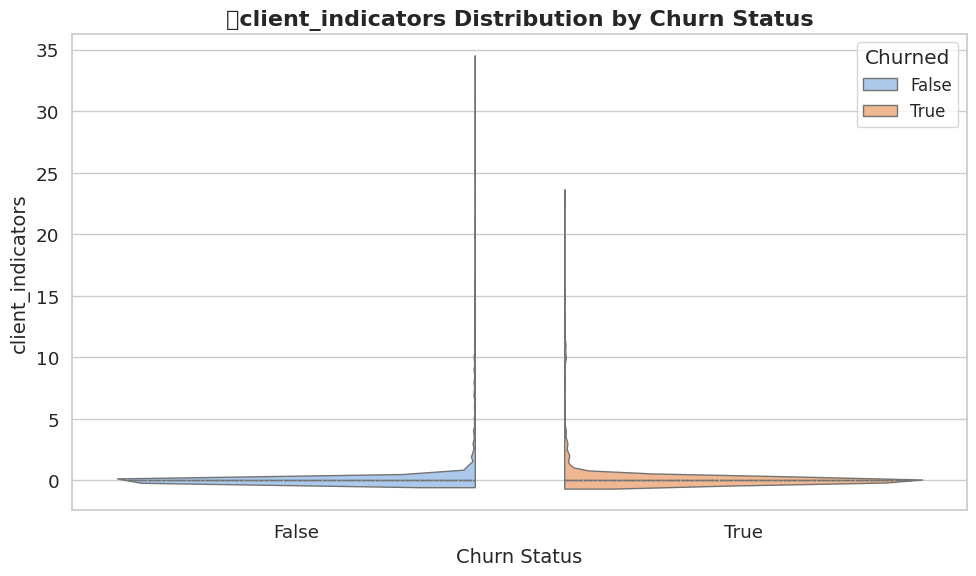

In [ ]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=client_indicators,
    x='Churned',
    y='FriendReferralsLastMonth',  # Removed the extra tab character
    hue='Churned',
    split=True,
    inner="quartile",
    linewidth=1,
)

# Add title and labels
plt.title("	client_indicators Distribution by Churn Status", fontsize=16, fontweight='bold')
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("client_indicators", fontsize=14)

# Add a legend
plt.legend(title="Churned", loc='upper right', fontsize=12)

# Make the plot pretty
plt.tight_layout()
plt.show()

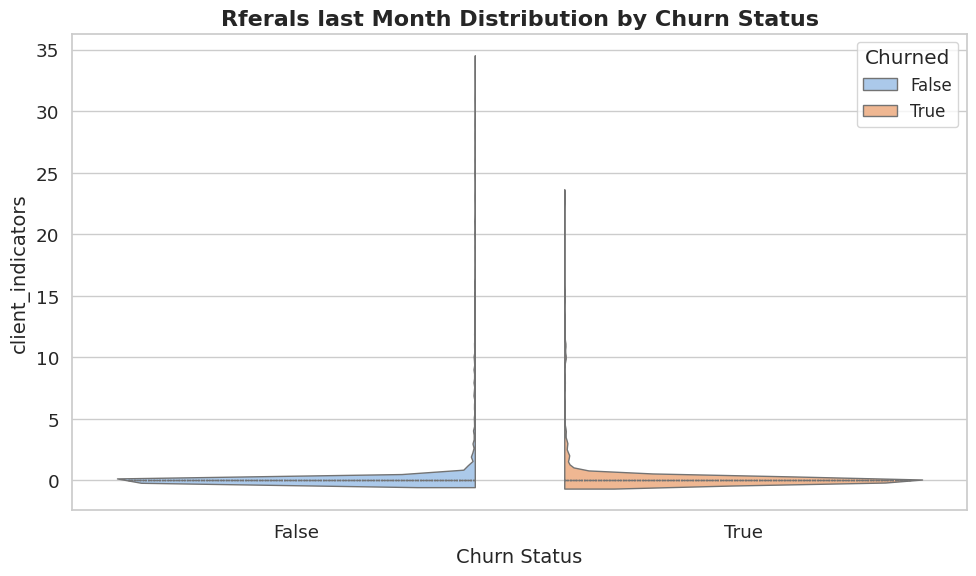

In [ ]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=client_indicators,
    x='Churned',
    y='FriendReferralsLastMonth',  # Removed the extra tab character
    hue='Churned',
    split=True,
    inner="quartile",
    linewidth=1,
)

# Add title and labels
plt.title("Rferals last Month Distribution by Churn Status", fontsize=16, fontweight='bold')
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("client_indicators", fontsize=14)

# Add a legend
plt.legend(title="Churned", loc='upper right', fontsize=12)

# Make the plot pretty
plt.tight_layout()
plt.show()

<ipython-input-61-97e6615313b9>:22: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


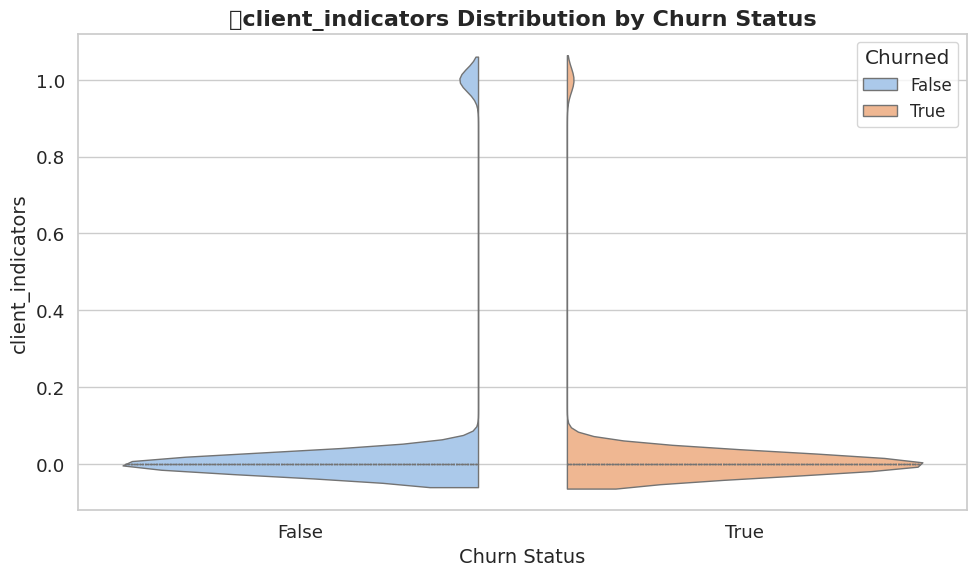

In [ ]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=client_indicators,
    x='Churned',
    y='InsuranceInd',  # Removed the extra tab character
    hue='Churned',
    split=True,
    inner="quartile",
    linewidth=1,
)

# Add title and labels
plt.title("	client_indicators Distribution by Churn Status", fontsize=16, fontweight='bold')
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("client_indicators", fontsize=14)

# Add a legend
plt.legend(title="Churned", loc='upper right', fontsize=12)

# Make the plot pretty
plt.tight_layout()
plt.show()

<ipython-input-62-2c4243227d02>:22: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


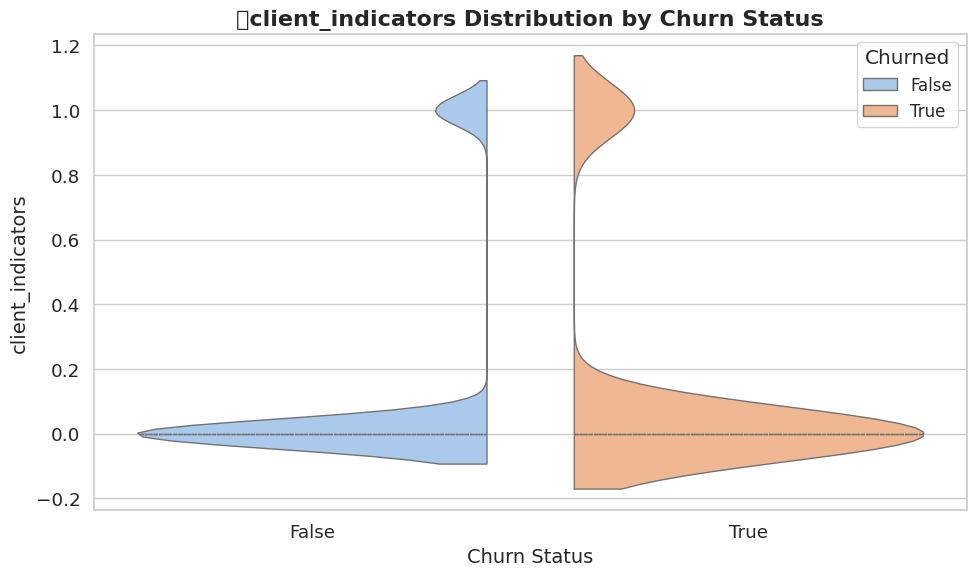

In [ ]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=client_indicators,
    x='Churned',
    y='TVInd',  # Removed the extra tab character
    hue='Churned',
    split=True,
    inner="quartile",
    linewidth=1,
)

# Add title and labels
plt.title("	client_indicators Distribution by Churn Status", fontsize=16, fontweight='bold')
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("client_indicators", fontsize=14)

# Add a legend
plt.legend(title="Churned", loc='upper right', fontsize=12)

# Make the plot pretty
plt.tight_layout()
plt.show()

In [ ]:
# Drop the 'FiscalPeriod' column
client_indicators_cleaned = client_indicators.drop(columns=['FiscalPeriod', 'Churned'])

# Remove duplicates based on 'UserID'
client_indicators_cleaned = client_indicators_cleaned.drop_duplicates(subset=['UserID'])

# Display the cleaned dataset
print(client_indicators_cleaned.head())

    UserID  InsuranceInd  TVInd  FriendReferralInd  FriendReferralsLastMonth
0   C10000             0      0                  1                       0.0
12  C10001             0      0                  0                       0.0
24  C10002             0      0                  1                       0.0
36  C10003             0      0                  1                       0.0
48  C10004             0      0                  1                       0.0


### Client DF - Final Transformations

In [ ]:
# Drop trend-related columns from client_df
columns_to_drop = ['TVInd', 'InsuranceInd', 'FriendReferralInd','FriendReferralsLastMonth','DOB', 'ContractEndDate']
client_df = client_df.drop(columns=columns_to_drop)

In [ ]:
client_df.head()

UserID  FiscalPeriod StatusID SegmentName     ContractType TopupMethod  \
0  C10000        202311        A    BILL PAY  30 DAY              UNKNOWN   
1  C10001        202311        A    BILL PAY  24 MONTH            UNKNOWN   
2  C10002        202311        A    BILL PAY  24 MONTH            UNKNOWN   
3  C10003        202311        A    BILL PAY  24 MONTH            UNKNOWN   
4  C10004        202311        A    BILL PAY  24 MONTH            UNKNOWN   

  StoreLocation  TenureInMonths      DeviceType CancellationDate  Churned  \
0        Dublin             125  4TH GENERATION              NaT    False   
1       UNKNOWN             283  5TH GENERATION              NaT    False   
2       UNKNOWN             280  4TH GENERATION              NaT    False   
3       UNKNOWN             278  4TH GENERATION              NaT    False   
4       UNKNOWN             265  5TH GENERATION              NaT    False   

   MonthsSinceContractEnd   Age  ContractRiskScore  
0                    38.0  65.0           1.153460  
1                    11.0  53.0           2.657974  
2                    30.0  58.0           2.657974  
3                    10.0  53.0           2.657974  
4                     9.0  71.0           2.657974

In [ ]:
# Function to categorize store locations
def categorize_location(location):
    if location == 'Dublin':
        return 'Dublin'
    elif location == 'UNKNOWN':
        return 'UNKNOWN'
    else:
        return 'Other'

# Apply the categorization
client_df['StoreLocation'] = client_df['StoreLocation'].apply(categorize_location)

# Let's verify the changes
print("Updated Store Location Distribution:")
print(client_df['StoreLocation'].value_counts())

Updated Store Location Distribution:
StoreLocation
UNKNOWN    14691
Dublin      3266
Other       3081
Name: count, dtype: int64


In [ ]:
#loyalty_df = client_df.tail()
#loyalty_df = loyalty_df[loyalty_df['StatusID'] != 'C']

In [ ]:
def prepare_user_level_features(client_df):
    # Clean ContractType - strip whitespace
    client_df['ContractType'] = client_df['ContractType'].str.strip()

    # Base aggregations
    user_features_df = client_df.groupby('UserID').agg({
        'FiscalPeriod': 'max',
        'TenureInMonths': 'max',
        'SegmentName': 'max',
        'MonthsSinceContractEnd': 'max',
        'Churned': 'any',
        'Age': 'max',
        'ContractRiskScore': 'max'
    }).reset_index()

    # Most Recent Values
    latest_values = client_df.sort_values('FiscalPeriod').groupby('UserID').last()
    user_features_df['latest_device'] = user_features_df['UserID'].map(latest_values['DeviceType'])
    user_features_df['latest_topup'] = user_features_df['UserID'].map(latest_values['TopupMethod'])

    # Most Frequent (Dominant) Values
    dominant_device = client_df.groupby('UserID')['DeviceType'].agg(lambda x: x.mode().iloc[0])
    dominant_topup = client_df.groupby('UserID')['TopupMethod'].agg(lambda x: x.mode().iloc[0])
    user_features_df['dominant_device'] = user_features_df['UserID'].map(dominant_device)
    user_features_df['dominant_topup'] = user_features_df['UserID'].map(dominant_topup)

    # Device and Topup Counts (unique values)
    device_counts = client_df.groupby('UserID')['DeviceType'].nunique()
    topup_counts = client_df.groupby('UserID')['TopupMethod'].nunique()
    user_features_df['device_count'] = user_features_df['UserID'].map(device_counts)
    user_features_df['topup_count'] = user_features_df['UserID'].map(topup_counts)

    # Change Counts (only actual changes)
    device_changes = client_df.sort_values(['UserID', 'FiscalPeriod']).groupby('UserID')['DeviceType'].apply(
        lambda x: (x != x.shift()).sum() if len(x) > 1 else 0
    )
    topup_changes = client_df.sort_values(['UserID', 'FiscalPeriod']).groupby('UserID')['TopupMethod'].apply(
        lambda x: (x != x.shift()).sum() if len(x) > 1 else 0
    )
    user_features_df['device_changes'] = user_features_df['UserID'].map(device_changes)
    user_features_df['topup_changes'] = user_features_df['UserID'].map(topup_changes)

    # Device change indicator (binary)
    device_changed = client_df.groupby('UserID')['DeviceType'].apply(
        lambda x: (x != x.iloc[0]).any() if len(x) > 1 else False
    )
    user_features_df['has_device_changed'] = user_features_df['UserID'].map(device_changed)

    # Count unique topup methods
    unique_topup_methods = client_df.groupby('UserID')['TopupMethod'].apply(lambda x: len(set(x)))
    user_features_df['unique_topup_methods'] = user_features_df['UserID'].map(unique_topup_methods)

    # Contract and Segment Change Indicators
    contract_changed = client_df.groupby('UserID')['ContractType'].apply(
        lambda x: (x != x.iloc[0]).any() if len(x) > 1 else False
    )
    user_features_df['has_contract_changed'] = user_features_df['UserID'].map(contract_changed)

    segment_changed = client_df.groupby('UserID')['SegmentName'].apply(
        lambda x: (x != x.iloc[0]).any() if len(x) > 1 else False
    )
    user_features_df['has_segment_changed'] = user_features_df['UserID'].map(segment_changed)

    # Contract Type History
    all_contracts = client_df.groupby('UserID')['ContractType'].apply(
        lambda x: list(set(x.str.strip()))
    )

    # Create contract type columns (initialized as False)
    unique_contracts = client_df['ContractType'].str.strip().unique()
    for contract in unique_contracts:
        user_features_df[f'contract_{contract}'] = False

    # Set True for each contract type the customer has had
    for user_id, contracts in all_contracts.items():
        for contract in contracts:
            user_features_df.loc[user_features_df['UserID'] == user_id, f'contract_{contract}'] = True

    return user_features_df

In [ ]:
user_features_df = prepare_user_level_features(client_df)

In [ ]:
user_features_df.head()

UserID  FiscalPeriod  TenureInMonths SegmentName  MonthsSinceContractEnd  \
0  C10000        202410             136    BILL PAY                    38.0   
1  C10001        202410             294    BILL PAY                    11.0   
2  C10002        202410             291    BILL PAY                    30.0   
3  C10003        202410             289    BILL PAY                    10.0   
4  C10004        202410             277    BILL PAY                     9.0   

   Churned   Age  ContractRiskScore   latest_device latest_topup  ...  \
0    False  65.0           1.153460  4TH GENERATION      UNKNOWN  ...   
1    False  53.0           2.657974  5TH GENERATION      UNKNOWN  ...   
2    False  58.0           2.657974  4TH GENERATION      UNKNOWN  ...   
3    False  53.0           2.657974  4TH GENERATION      UNKNOWN  ...   
4    False  71.0           2.657974  5TH GENERATION      UNKNOWN  ...   

  topup_changes has_device_changed  unique_topup_methods  \
0             1              False                     1   
1             1              False                     1   
2             1              False                     1   
3             1              False                     1   
4             1              False                     1   

   has_contract_changed  has_segment_changed  contract_30 DAY  \
0                 False                False             True   
1                 False                False            False   
2                 False                False            False   
3                 False                False            False   
4                 False                False            False   

   contract_24 MONTH  contract_12 MONTH  contract_18 MONTH  contract_PREPAID  
0              False              False              False             False  
1               True              False              False             False  
2               True              False              False             False  
3               True              False              False             False  
4               True              False              False             False  

[5 rows x 25 columns]

In [ ]:
client_trends.head(10)

UserID  spend_avg_change  spend_trend_slope spend_trend_direction  \
0  C10000          0.033847       2.134833e-02            Increasing   
1  C10001          0.003899       9.010684e-03            Increasing   
2  C10002          0.260471       9.189480e-02            Increasing   
3  C10003          0.004172       9.952643e-03            Increasing   
4  C10004         -0.003502      -1.047367e-02            Decreasing   
5  C10005          0.000000      -1.425845e-17            Decreasing   
6  C10006          0.000000      -6.733519e-17            Decreasing   
7  C10007          0.041153       5.885178e-03            Increasing   
8  C10008          0.130278       2.194351e-02            Increasing   
9  C10009          0.057396       2.839651e-02            Increasing   

   spend_last_value  usage_avg_change  usage_trend_slope  \
0             20.32          0.227437       1.129606e+07   
1             55.64         -0.020788      -6.006369e+07   
2             18.70          0.113311       1.840499e+07   
3             43.07          0.062374      -6.030238e+07   
4             48.78          0.544959      -5.021297e+07   
5             14.84               NaN                NaN   
6             28.44          0.028195       6.813885e+06   
7             20.56          0.271636       6.039057e+06   
8             68.57          0.202436       2.511655e+07   
9             65.98          0.097527      -8.019222e+06   

  usage_trend_direction  usage_last_value  
0            Increasing      5.930183e+09  
1            Decreasing      1.663467e+10  
2            Increasing      2.331649e+09  
3            Decreasing      7.092875e+09  
4            Decreasing      4.635302e+09  
5                   NaN               NaN  
6            Increasing      7.703039e+09  
7            Increasing      2.742318e+09  
8            Increasing      8.295636e+09  
9            Decreasing      2.119132e+10

In [ ]:
client_indicators_cleaned.head()

UserID  InsuranceInd  TVInd  FriendReferralInd  FriendReferralsLastMonth
0   C10000             0      0                  1                       0.0
12  C10001             0      0                  0                       0.0
24  C10002             0      0                  1                       0.0
36  C10003             0      0                  1                       0.0
48  C10004             0      0                  1                       0.0

In [ ]:
discount_df.head(5)

UserID CancellationDate  Churned  DiscountAmount  DurationMonths  \
0  C10000              NaT        0              10              12   
1  C10007              NaT        0              10              12   
2  C10015              NaT        0              10              12   
3  C10017              NaT        0              10              12   
4  C10031              NaT        0              15              12   

   DiscountCount  IsCurrentDiscount  PreviousDiscount  
0              1                  1                 0  
1              1                  1                 0  
2              1                  0                 1  
3              1                  1                 0  
4              1                  1                 0

In [ ]:
# To see unique values in each column
for column in discount_df.columns:
    print(f"\n{column}:")
    print(f"Unique values: {discount_df[column].nunique()}")
    print("Sample of unique values:", discount_df[column].unique()[:5])  # Show first 5 unique values

customer_care_processed


UserID:
Unique values: 122
Sample of unique values: ['C10000' 'C10007' 'C10015' 'C10017' 'C10031']

CancellationDate:
Unique values: 9
Sample of unique values: <DatetimeArray>
[                'NaT', '2024-07-03 00:00:00', '2024-07-06 00:00:00',
 '2024-10-11 00:00:00', '2024-08-27 00:00:00']
Length: 5, dtype: datetime64[ns]

Churned:
Unique values: 2
Sample of unique values: [0 1]

DiscountAmount:
Unique values: 4
Sample of unique values: [10 15  5 20]

DurationMonths:
Unique values: 2
Sample of unique values: [12  6]

DiscountCount:
Unique values: 1
Sample of unique values: [1]

IsCurrentDiscount:
Unique values: 2
Sample of unique values: [1 0]

PreviousDiscount:
Unique values: 2
Sample of unique values: [0 1]


UserID  TimeDelta  MaxDuration  MinDuration  Channel_Call  Channel_Retail  \
0   C10208       35.0         1554         1554          True           False   
1   C10681       21.0          215          215          True           False   
2   C11244       14.0          182          182          True           False   
3   C10616        6.0          215          148          True           False   
4   C10863        4.0          780          780          True           False   
..     ...        ...          ...          ...           ...             ...   
60  C11537        NaN         1281            0          True           False   
61  C11322        NaN          365          365          True           False   
62  C11310        NaN          349          349          True           False   
63  C10857        NaN          173          173          True           False   
64  C11008        NaN         1898          391          True           False   

    Reason_Billing  Reason_Coverage  Reason_Service  Reason_Upgrade  
0            False             True           False           False  
1             True            False           False           False  
2             True            False           False           False  
3            False             True           False           False  
4             True            False           False           False  
..             ...              ...             ...             ...  
60            True            False           False           False  
61            True            False           False           False  
62            True            False           False           False  
63           False             True           False           False  
64            True            False           False           False  

[65 rows x 10 columns]

In [ ]:
customer_care_processed.head()

UserID  TimeDelta  MaxDuration  MinDuration  Channel_Call  Channel_Retail  \
0  C10208       35.0         1554         1554          True           False   
1  C10681       21.0          215          215          True           False   
2  C11244       14.0          182          182          True           False   
3  C10616        6.0          215          148          True           False   
4  C10863        4.0          780          780          True           False   

   Reason_Billing  Reason_Coverage  Reason_Service  Reason_Upgrade  
0           False             True           False           False  
1            True            False           False           False  
2            True            False           False           False  
3           False             True           False           False  
4            True            False           False           False

# Merge All Df's

In [ ]:
def merge_all_dataframes(user_features_df, client_trends, client_indicators_cleaned, discount_df, customer_care_processed):
    """
    Merges all dataframes preserving ALL records including NaNs
    """
    # Start with loyalty_df as our base
    merged_df = user_features_df.copy()

    # Print initial counts
    print("Initial Record Counts:")
    print(f"Loyalty records: {len(user_features_df)}")
    print(f"Customer Care records: {len(customer_care_processed)}")
    print(f"Discount records: {len(discount_df)}")

    # Merge with customer_care_processed - preserve ALL records
    merged_df = merged_df.merge(
        customer_care_processed,
        on='UserID',
        how='left',
    )


    # Merge with discount_df
    merged_df = merged_df.merge(
        discount_df,
        on='UserID',
        how='left'
    )


    # Merge with remaining dataframes
    merged_df = merged_df.merge(client_trends, on='UserID', how='left')
    merged_df = merged_df.merge(client_indicators_cleaned, on='UserID', how='left')

    return merged_df

# Let's run with the fixed version
merged_df = merge_all_dataframes(user_features_df, client_trends, client_indicators_cleaned, discount_df, customer_care_processed)

Initial Record Counts:
Loyalty records: 1994
Customer Care records: 65
Discount records: 122


In [ ]:
merged_df.columns

Index(['UserID', 'FiscalPeriod', 'TenureInMonths', 'SegmentName',
       'MonthsSinceContractEnd', 'Churned_x', 'Age', 'ContractRiskScore',
       'latest_device', 'latest_topup', 'dominant_device', 'dominant_topup',
       'device_count', 'topup_count', 'device_changes', 'topup_changes',
       'has_device_changed', 'unique_topup_methods', 'has_contract_changed',
       'has_segment_changed', 'contract_30 DAY', 'contract_24 MONTH',
       'contract_12 MONTH', 'contract_18 MONTH', 'contract_PREPAID',
       'TimeDelta', 'MaxDuration', 'MinDuration', 'Channel_Call',
       'Channel_Retail', 'Reason_Billing', 'Reason_Coverage', 'Reason_Service',
       'Reason_Upgrade', 'CancellationDate', 'Churned_y', 'DiscountAmount',
       'DurationMonths', 'DiscountCount', 'IsCurrentDiscount',
       'PreviousDiscount', 'spend_avg_change', 'spend_trend_slope',
       'spend_trend_direction', 'spend_last_value', 'usage_avg_change',
       'usage_trend_slope', 'usage_trend_direction', 'usage_last_valu

In [ ]:
# Drop all churn-related columns first
columns_to_drop = ['Churned_x', 'Churned_y', 'CancellationDate']
merged_df = merged_df.drop(columns_to_drop, axis=1)

In [ ]:

# Now do a clean merge with cancellations_df
merged_df = merged_df.merge(
    cancellations_df[['UserID', 'CancellationDate']],
    on='UserID',
    how='left'
)

# Create fresh Churned column
merged_df['Churned'] = merged_df['CancellationDate'].notna().astype(int)

# Verify our new churn distribution
print("New Churn Distribution:")
print(merged_df['Churned'].value_counts())
print("\nChurn Rate (%):")
print(merged_df['Churned'].value_counts(normalize=True) * 100)

New Churn Distribution:
Churned
0    1800
1     194
Name: count, dtype: int64

Churn Rate (%):
Churned
0    90.270812
1     9.729188
Name: proportion, dtype: float64


In [ ]:
# Method 1: Basic export to Excel
merged_df.to_excel('merged_data.xlsx', index=False)

# Method 2: Save to Google Drive (recommended for Colab)
from google.colab import drive
drive.mount('/content/drive')

# Save to your Google Drive
merged_df.to_excel('/content/drive/My Drive/merged_data.xlsx', index=False)

# Method 3: Create download link (if you want to download directly)
from google.colab import files

# Save locally first
merged_df.to_excel('merged_data.xlsx', index=False)
# Create download
files.download('merged_data.xlsx')

# Method 4: If you have multiple sheets/tabs
with pd.ExcelWriter('merged_data.xlsx') as writer:
    merged_df.to_excel(writer, sheet_name='Main Data', index=False)
    # You can add more sheets if needed
    # df2.to_excel(writer, sheet_name='Sheet2', index=False)
files.download('merged_data.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

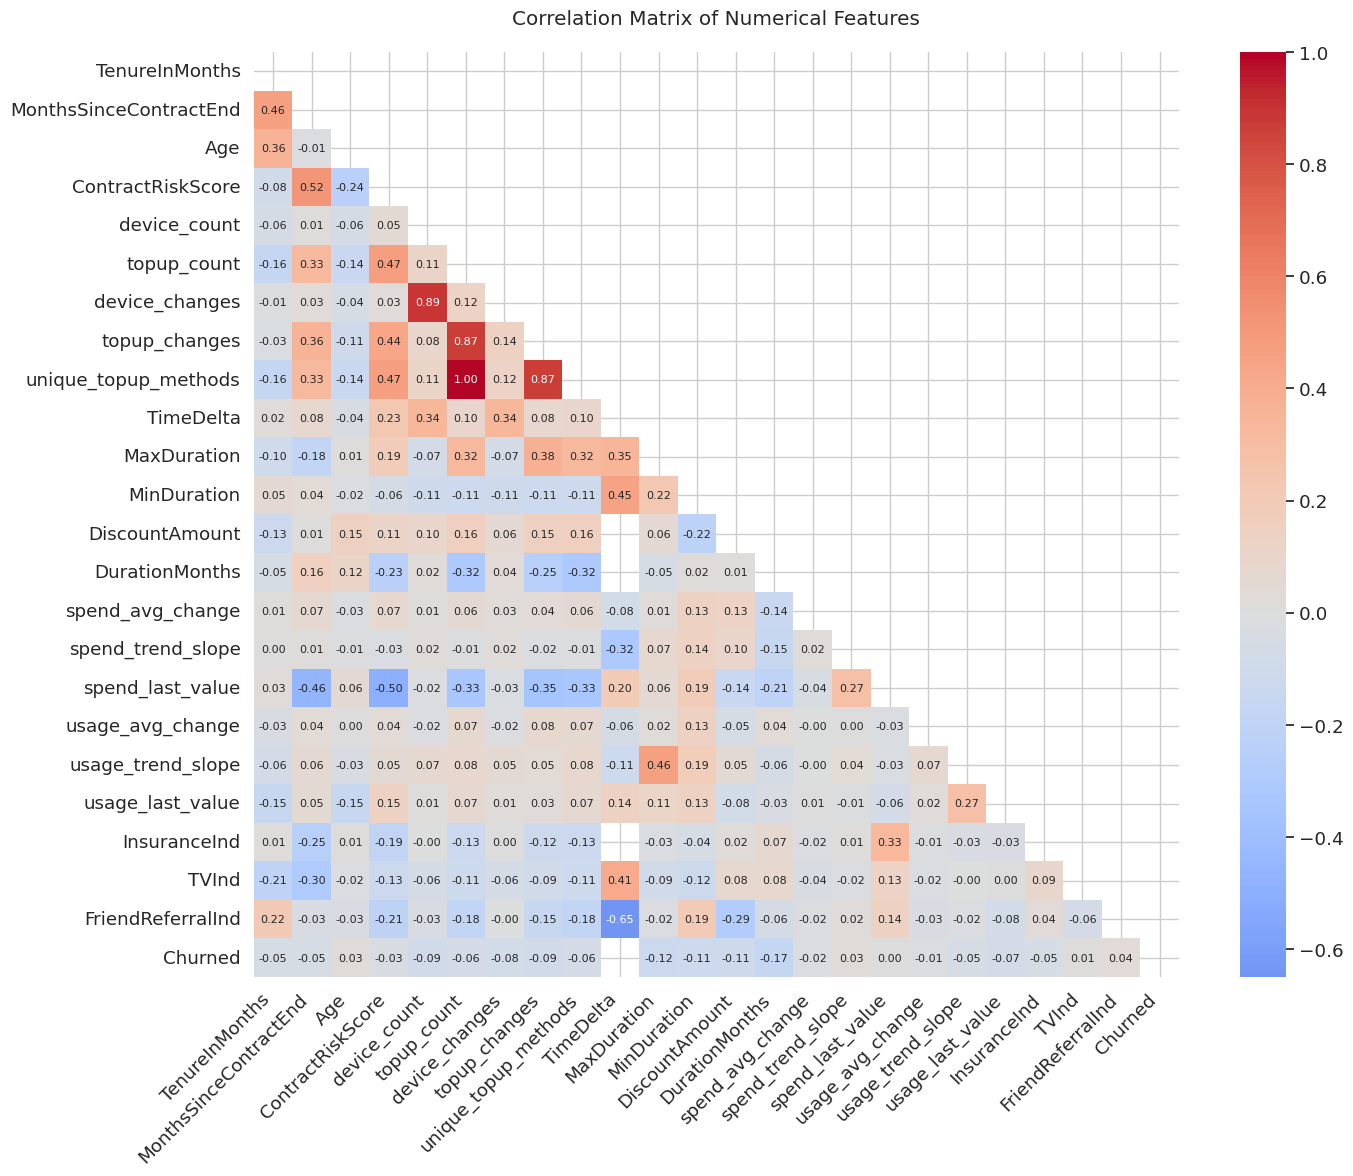


Strong Correlations (|correlation| > 0.2):
unique_topup_methods ~ topup_count: 1.000
device_changes ~ device_count: 0.892
unique_topup_methods ~ topup_changes: 0.866
topup_changes ~ topup_count: 0.866
FriendReferralInd ~ TimeDelta: -0.650
ContractRiskScore ~ MonthsSinceContractEnd: 0.522
spend_last_value ~ ContractRiskScore: -0.502
topup_count ~ ContractRiskScore: 0.471
unique_topup_methods ~ ContractRiskScore: 0.471
spend_last_value ~ MonthsSinceContractEnd: -0.465
MonthsSinceContractEnd ~ TenureInMonths: 0.460
usage_trend_slope ~ MaxDuration: 0.459
MinDuration ~ TimeDelta: 0.447
topup_changes ~ ContractRiskScore: 0.438
TVInd ~ TimeDelta: 0.410
MaxDuration ~ topup_changes: 0.375
Age ~ TenureInMonths: 0.364
topup_changes ~ MonthsSinceContractEnd: 0.361
spend_last_value ~ topup_changes: -0.348
MaxDuration ~ TimeDelta: 0.346
TimeDelta ~ device_count: 0.343
TimeDelta ~ device_changes: 0.343
spend_last_value ~ topup_count: -0.333
spend_last_value ~ unique_topup_methods: -0.333
InsuranceIn

In [ ]:
# Select numerical features (excluding binary/categorical and ID columns)
numerical_features = [
    'TenureInMonths',
    'MonthsSinceContractEnd',
    'Age',
    'ContractRiskScore',
    'device_count',
    'topup_count',
    'device_changes',
    'topup_changes',
    'unique_topup_methods',
    'TimeDelta',
    'MaxDuration',
    'MinDuration',
    'DiscountAmount',
    'DurationMonths',
    'spend_avg_change',
    'spend_trend_slope',
    'spend_last_value',
    'usage_avg_change',
    'usage_trend_slope',
    'usage_last_value',
    'InsuranceInd',
    'TVInd',
    'FriendReferralInd',
    'Churned'

]

# Create correlation matrix
correlation_matrix = merged_df[numerical_features].corr()

# Create heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            square=True,
            mask=np.triu(correlation_matrix),
            annot_kws={'size': 8})

plt.title('Correlation Matrix of Numerical Features', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print strongest correlations (|correlation| > 0.2)
print("\nStrong Correlations (|correlation| > 0.2):")
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.2:
            strong_corr.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

# Sort by absolute correlation value
strong_corr.sort(key=lambda x: abs(x[2]), reverse=True)
for feat1, feat2, corr in strong_corr:
    print(f"{feat1} ~ {feat2}: {corr:.3f}")

In [ ]:
# Quick check of your data distribution
print(merged_df[['spend_last_value', 'usage_last_value', 'ContractRiskScore']].describe())

# Check skewness
print("\nSkewness:")
print(merged_df[['spend_last_value', 'usage_last_value', 'ContractRiskScore']].skew())

       spend_last_value  usage_last_value  ContractRiskScore
count       1837.000000      1.847000e+03        1994.000000
mean          25.659594      1.281112e+11           4.153282
std           19.274565      2.482757e+11           1.711351
min            0.008100      3.108600e+02           0.000000
25%           16.260000      1.627830e+10           2.657974
50%           18.700000      5.209981e+10           5.466399
75%           32.670000      1.371720e+11           5.466399
max          303.320000      3.979612e+12           5.466399

Skewness:
spend_last_value     3.640727
usage_last_value     6.333713
ContractRiskScore   -0.741336
dtype: float64


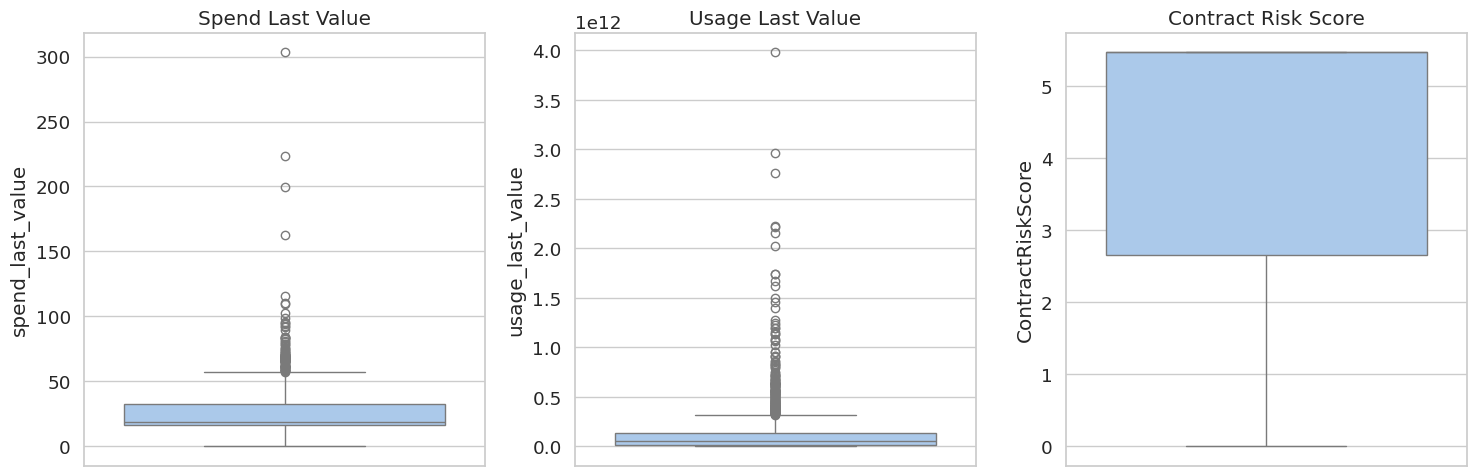

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=merged_df['spend_last_value'], ax=axes[0])
axes[0].set_title('Spend Last Value')
sns.boxplot(data=merged_df['usage_last_value'], ax=axes[1])
axes[1].set_title('Usage Last Value')
sns.boxplot(data=merged_df['ContractRiskScore'], ax=axes[2])
axes[2].set_title('Contract Risk Score')
plt.tight_layout()
plt.show()

# DEEP Survival Curves

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, RobustScaler  # Added RobustScaler
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer

class SurvivalDataset(Dataset):
    def __init__(self, X, durations, events):
        self.X = torch.FloatTensor(X.values)
        self.durations = torch.FloatTensor(durations.values)
        self.events = torch.FloatTensor(events.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.durations[idx], self.events[idx]

class DeepSurv(nn.Module):
    def __init__(self, input_dim):
        super(DeepSurv, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

def negative_log_likelihood(risk_pred, durations, events):
    hazard_ratio = torch.exp(risk_pred)
    log_risk = torch.log(torch.cumsum(hazard_ratio, dim=0))
    uncensored_likelihood = risk_pred.squeeze() - log_risk
    censored_likelihood = uncensored_likelihood * events
    neg_likelihood = -torch.sum(censored_likelihood)
    return neg_likelihood

def enhanced_survival_analysis(merged_df):
    # Select important features
    features = [
        'UserID', 'TenureInMonths', 'Churned', 'Age',
        'ContractRiskScore', 'spend_last_value', 'usage_last_value',
        'MonthsSinceContractEnd', 'usage_trend_slope','TimeDelta','unique_topup_methods',
        'TimeDelta','ContractRiskScore','FriendReferralsLastMonth'
    ]

    df = merged_df[features].copy()

    # Store UserIDs separately
    user_ids = df['UserID'].copy()

    # Drop UserID before imputation
    df_numeric = df.drop('UserID', axis=1)

    # Initialize KNN imputer
    imputer = KNNImputer(n_neighbors=15, weights='uniform')

    # Separate target variables before imputation
    target_cols = ['Churned', 'TenureInMonths']
    X = df_numeric.drop(target_cols, axis=1)
    y = df_numeric[target_cols]

    # Perform KNN imputation on features
    print("Performing KNN imputation...")
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Perform separate KNN imputation on target variables if needed
    y_imputed = pd.DataFrame(
        imputer.fit_transform(y),
        columns=y.columns,
        index=y.index
    )

    # Recombine the data
    df_numeric = pd.concat([X_imputed, y_imputed], axis=1)

    # Prepare features and target
    X = df_numeric.drop(target_cols, axis=1)
    durations = y_imputed['TenureInMonths']
    events = y_imputed['Churned']

    # Scale features
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns
    )

    # Create dataset and dataloader
    dataset = SurvivalDataset(X_scaled, durations, events)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Initialize model
    model = DeepSurv(input_dim=X_scaled.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    print("Training DeepSurv model...")
    for epoch in range(150):
        model.train()
        epoch_loss = 0

        for batch_X, batch_durations, batch_events in dataloader:
            optimizer.zero_grad()
            risk_pred = model(batch_X)
            loss = negative_log_likelihood(risk_pred, batch_durations, batch_events)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {epoch_loss/len(dataloader):.4f}")

    # Prepare output dataframe
    analysis_df = X_scaled.copy()
    analysis_df['UserID'] = user_ids.values

    return model, analysis_df

def get_survival_predictions(model, analysis_df):
    predictions = pd.DataFrame()
    predictions['UserID'] = analysis_df['UserID']

    # Convert to tensor
    X = torch.FloatTensor(analysis_df.drop('UserID', axis=1).values)

    # Get risk scores
    model.eval()
    with torch.no_grad():
        risk_scores = model(X).numpy()

    # Calculate survival probabilities
    time_points = [90, 180, 365]
    for time_point in time_points:
        baseline_hazard = np.exp(-time_point / 365)
        survival_prob = np.exp(-np.exp(risk_scores) * baseline_hazard)
        predictions[f'survival_prob_{time_point}d'] = survival_prob.ravel()
        predictions[f'churn_risk_{time_point}d'] = 1 - survival_prob.ravel()

    return predictions

# Now run this shit with your merged_df:
deep_surv_model, analysis_df = enhanced_survival_analysis(merged_df)
predictions = get_survival_predictions(deep_surv_model, analysis_df)
print(predictions.head())

Performing KNN imputation...
Training DeepSurv model...
Epoch 0: Loss = 1256.6918
Epoch 10: Loss = 1201.0835
Epoch 20: Loss = 1165.9291
Epoch 30: Loss = 1161.6345
Epoch 40: Loss = 1133.5561
Epoch 50: Loss = 1134.2885
Epoch 60: Loss = 1102.4156
Epoch 70: Loss = 1091.8091
Epoch 80: Loss = 1109.2963
Epoch 90: Loss = 1096.1411
Epoch 100: Loss = 1085.6344
Epoch 110: Loss = 1090.1600
Epoch 120: Loss = 1057.1031
Epoch 130: Loss = 1053.6879
Epoch 140: Loss = 1078.7319
   UserID  survival_prob_90d  churn_risk_90d  survival_prob_180d  \
0  C10000           0.676717        0.323283            0.737001   
1  C10001           0.845747        0.154253            0.877284   
2  C10002           0.691082        0.308918            0.749199   
3  C10003           0.799830        0.200170            0.839838   
4  C10004           0.869067        0.130933            0.896131   

   churn_risk_180d  survival_prob_365d  churn_risk_365d  
0         0.262999            0.832078         0.167922  
1         

In [ ]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 8.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=ff09aa9f28797972fb40dceb0a2afa9bbdbae37a50bd267450e50b044b48ddb9
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


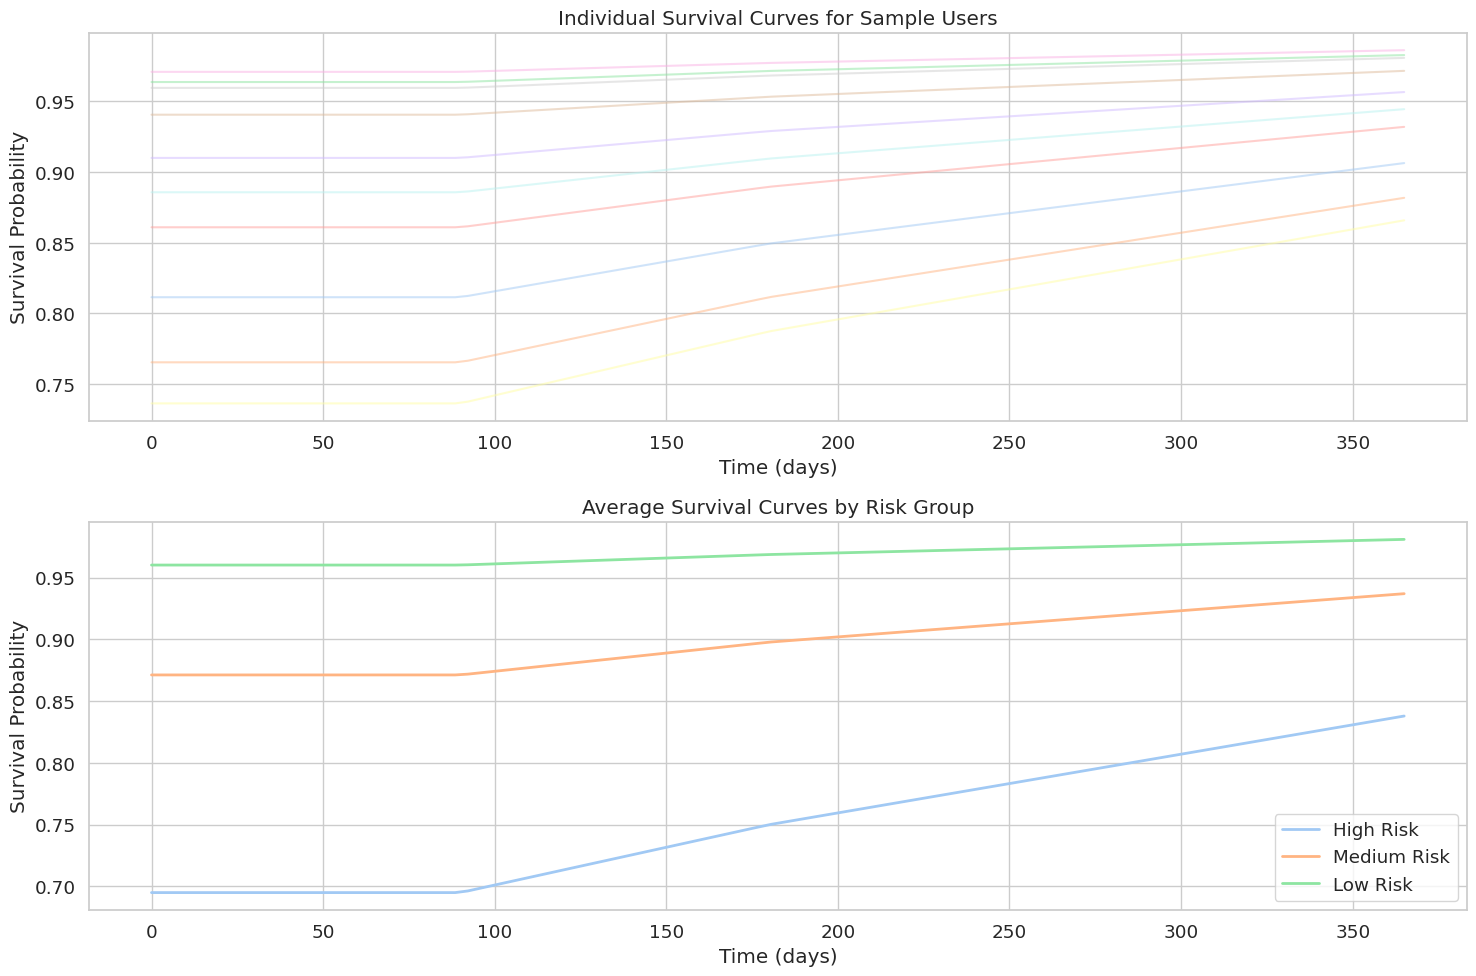

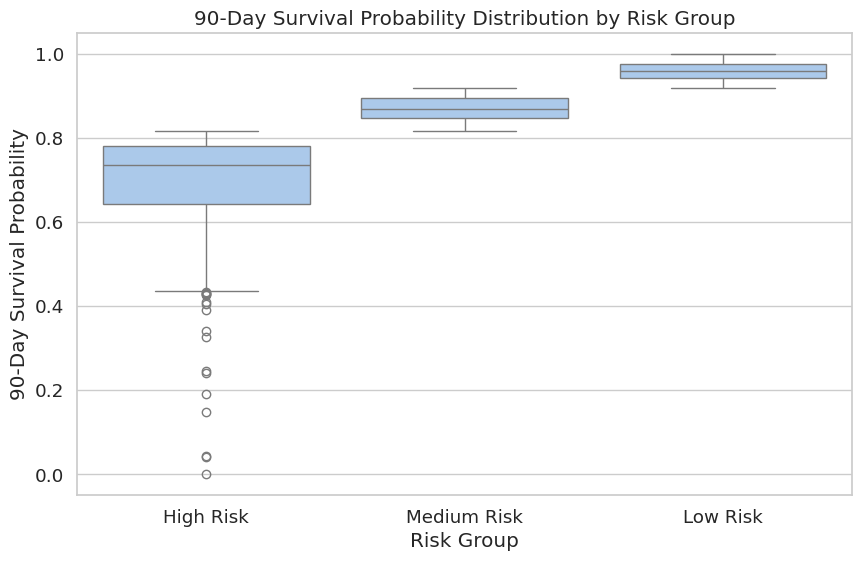


Risk Group Summary Statistics:
             count      mean       std       min       25%       50%  \
risk_group                                                             
High Risk    665.0  0.694906  0.121128  0.000482  0.643093  0.736414   
Medium Risk  664.0  0.871225  0.028439  0.818083  0.847256  0.870842   
Low Risk     665.0  0.960241  0.021615  0.919570  0.943082  0.961222   

                  75%       max  
risk_group                       
High Risk    0.780677  0.818059  
Medium Risk  0.894808  0.919429  
Low Risk     0.976618  1.000000  


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

def plot_survival_curves(predictions, merged_df, n_samples=10):
    # Create time points for smoother curves
    time_points = np.linspace(0, 365, 100)

    plt.figure(figsize=(15, 10))

    # Plot 1: Individual Survival Curves
    plt.subplot(2, 1, 1)
    sample_ids = predictions['UserID'].sample(n=n_samples).values

    for user_id in sample_ids:
        user_pred = predictions[predictions['UserID'] == user_id]
        survival_probs = [
            user_pred['survival_prob_90d'].values[0],
            user_pred['survival_prob_180d'].values[0],
            user_pred['survival_prob_365d'].values[0]
        ]
        time_points_plot = [90, 180, 365]

        # Interpolate for smoother curves
        survival_curve = np.interp(time_points, time_points_plot, survival_probs)
        plt.plot(time_points, survival_curve, alpha=0.5, label=f'User {user_id}')

    plt.title('Individual Survival Curves for Sample Users')
    plt.xlabel('Time (days)')
    plt.ylabel('Survival Probability')
    plt.grid(True)

    # Plot 2: Average Survival Curves by Risk Groups
    plt.subplot(2, 1, 2)

    # Create risk groups based on 90-day survival probability
    predictions['risk_group'] = pd.qcut(predictions['survival_prob_90d'],
                                      q=3,
                                      labels=['High Risk', 'Medium Risk', 'Low Risk'])

    for risk_group in ['High Risk', 'Medium Risk', 'Low Risk']:
        group_preds = predictions[predictions['risk_group'] == risk_group]
        mean_survival = [
            group_preds['survival_prob_90d'].mean(),
            group_preds['survival_prob_180d'].mean(),
            group_preds['survival_prob_365d'].mean()
        ]

        # Interpolate for smoother curves
        mean_curve = np.interp(time_points, time_points_plot, mean_survival)
        plt.plot(time_points, mean_curve, label=risk_group, linewidth=2)

    plt.title('Average Survival Curves by Risk Group')
    plt.xlabel('Time (days)')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Additional visualization: Risk Distribution
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='risk_group', y='survival_prob_90d', data=predictions)
    plt.title('90-Day Survival Probability Distribution by Risk Group')
    plt.xlabel('Risk Group')
    plt.ylabel('90-Day Survival Probability')
    plt.show()

# Call the function
plot_survival_curves(predictions, merged_df)

# Print summary statistics
print("\nRisk Group Summary Statistics:")
print(predictions.groupby('risk_group')['survival_prob_90d'].describe())

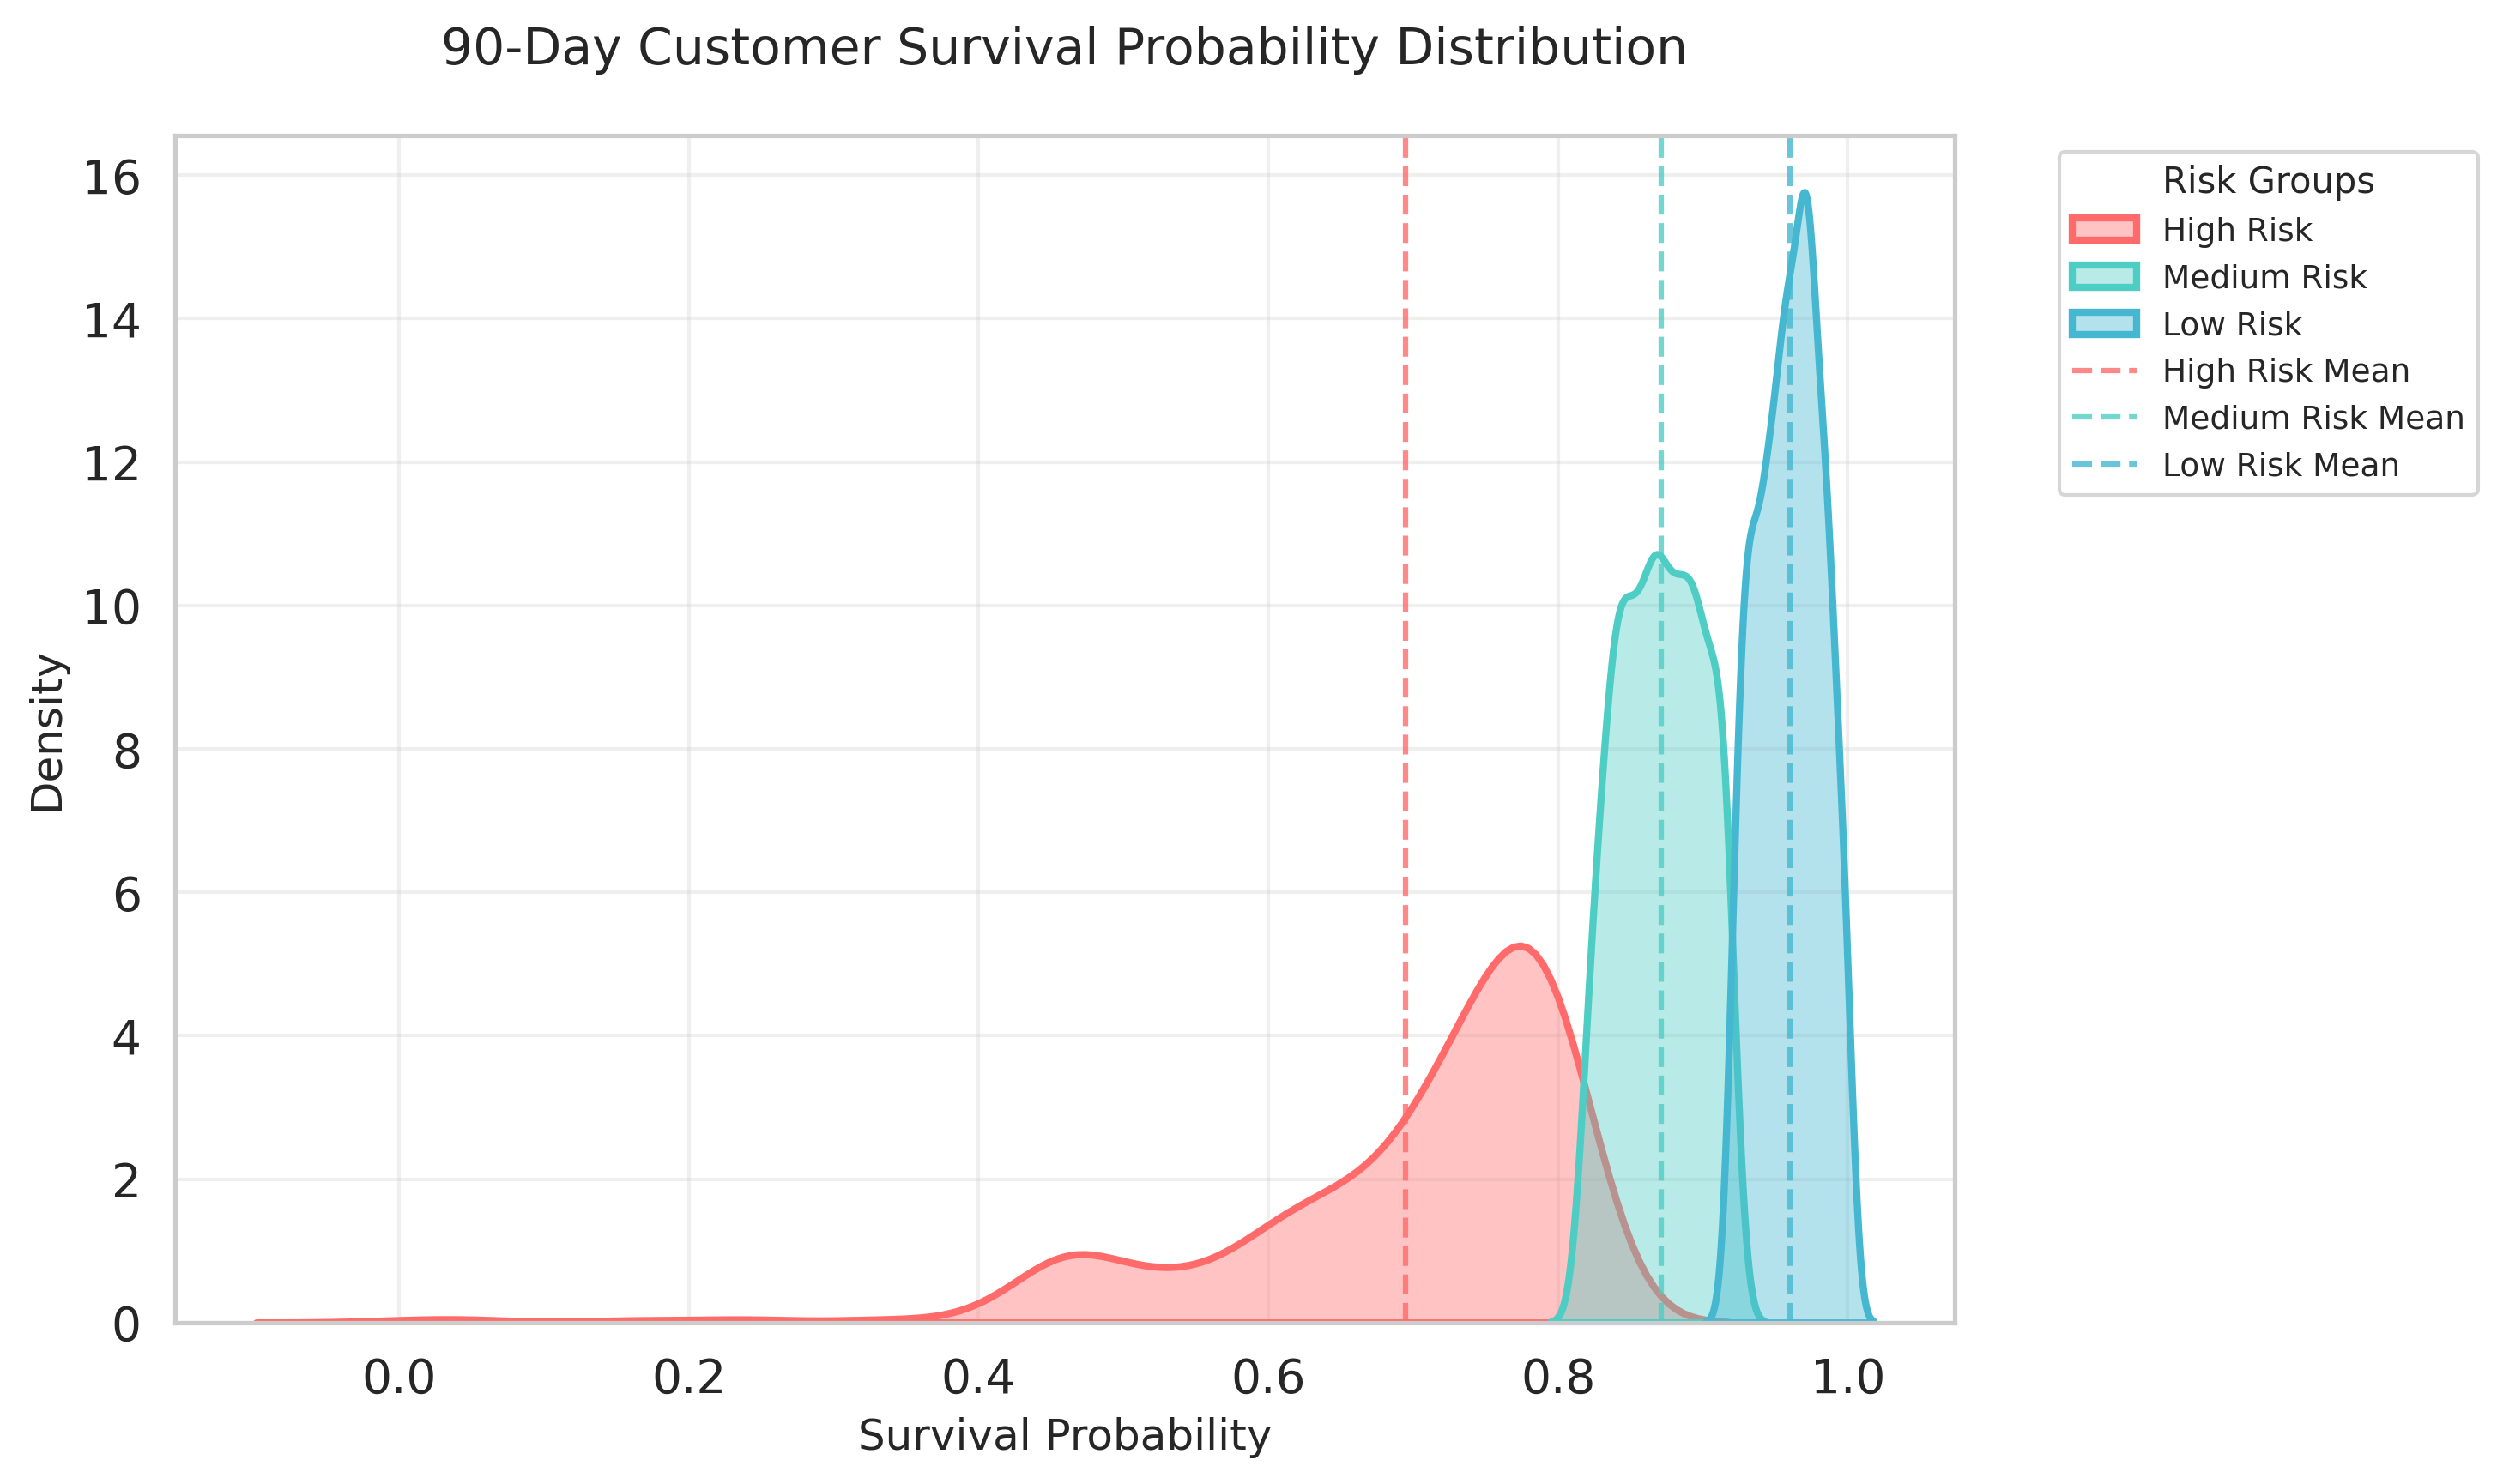

In [ ]:
def plot_simple_survival_distribution(predictions):
    plt.figure(figsize=(10, 6), dpi=300)

    # Better colors for presentation
    colors = {
        'High Risk': '#FF6B6B',  # Warm red
        'Medium Risk': '#4ECDC4', # Teal
        'Low Risk': '#45B7D1'    # Sky blue
    }

    # Plot single distribution for 90 days
    for risk_group in ['High Risk', 'Medium Risk', 'Low Risk']:
        data = predictions[predictions['risk_group'] == risk_group]['survival_prob_90d']
        sns.kdeplot(data=data,
                   label=risk_group,
                   color=colors[risk_group],
                   fill=True,
                   alpha=0.4,
                   linewidth=2)

    plt.title('90-Day Customer Survival Probability Distribution',
             fontsize=14,
             pad=20)
    plt.xlabel('Survival Probability', fontsize=12)
    plt.ylabel('Density', fontsize=12)

    # Add mean lines
    for risk_group in ['High Risk', 'Medium Risk', 'Low Risk']:
        mean_val = predictions[predictions['risk_group'] == risk_group]['survival_prob_90d'].mean()
        plt.axvline(mean_val,
                   color=colors[risk_group],
                   linestyle='--',
                   alpha=0.8,
                   label=f'{risk_group} Mean')

    plt.grid(True, alpha=0.3)
    plt.legend(title='Risk Groups',
              title_fontsize=10,
              fontsize=9,
              bbox_to_anchor=(1.05, 1),
              loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function
plot_simple_survival_distribution(predictions)

In [ ]:
# First let's merge the churned flag into our predictions to validate:
predictions = predictions.merge(
    client_df[['UserID', 'Churned']],
    on='UserID',
    how='left'
)

# Now let's look at the last 50 rows with the actual churn status
print("\nPredictions vs Actual Churn:")
print(predictions[['UserID',
                  'survival_prob_90d',
                  'churn_risk_90d',
                  'churn_risk_180d',
                  'churn_risk_365d',
                  'Churned']].tail(5))

# Let's also see how well our predictions match reality
print("\nSummary Stats:")
print("Average 90-day churn risk for churned customers:",
      predictions[predictions['Churned']==1]['churn_risk_90d'].mean())
print("Average 90-day churn risk for active customers:",
      predictions[predictions['Churned']==0]['churn_risk_90d'].mean())


Predictions vs Actual Churn:
       UserID  survival_prob_90d  churn_risk_90d  churn_risk_180d  \
21033  C11995           0.798789        0.201211         0.161017   
21034  C11996           0.838287        0.161713         0.128768   
21035  C11997           0.891180        0.108820         0.086099   
21036  C11998           0.773519        0.226481         0.181831   
21037  C11999           0.901789        0.098211         0.077607   

       churn_risk_365d  Churned  
21033         0.100358    False  
21034         0.079684    False  
21035         0.052790    False  
21036         0.113870    False  
21037         0.047499    False  

Summary Stats:
Average 90-day churn risk for churned customers: 0.30736035
Average 90-day churn risk for active customers: 0.13891995


In [ ]:
def categorize_risk(risk_score):
    if risk_score < 0.25:
        return 'Low Risk'
    elif risk_score < 0.4:
        return 'Medium Risk'
    else:
        return 'High Risk'

predictions['risk_category'] = predictions['churn_risk_90d'].apply(categorize_risk)

# Let's see the distribution
print("\nRisk Distribution:")
print(predictions.groupby(['risk_category', 'Churned']).size().unstack())

# Percentage of actual churns in each risk category
print("\nChurn Rate by Risk Category:")
churn_rates = predictions.groupby('risk_category')['Churned'].mean() * 100
print(churn_rates.round(2), "% Churned")


Risk Distribution:
Churned        False  True 
risk_category              
High Risk        638    336
Low Risk       16845    602
Medium Risk     2284    333

Churn Rate by Risk Category:
risk_category
High Risk      34.50
Low Risk        3.45
Medium Risk    12.72
Name: Churned, dtype: float64 % Churned


In [ ]:
predictions.head()

UserID  survival_prob_90d  churn_risk_90d  survival_prob_180d  \
0  C10000           0.676717        0.323283            0.737001   
1  C10000           0.676717        0.323283            0.737001   
2  C10000           0.676717        0.323283            0.737001   
3  C10000           0.676717        0.323283            0.737001   
4  C10000           0.676717        0.323283            0.737001   

   churn_risk_180d  survival_prob_365d  churn_risk_365d risk_group  Churned  \
0         0.262999            0.832078         0.167922  High Risk    False   
1         0.262999            0.832078         0.167922  High Risk    False   
2         0.262999            0.832078         0.167922  High Risk    False   
3         0.262999            0.832078         0.167922  High Risk    False   
4         0.262999            0.832078         0.167922  High Risk    False   

  risk_category  
0   Medium Risk  
1   Medium Risk  
2   Medium Risk  
3   Medium Risk  
4   Medium Risk

In [ ]:
# Remove duplicates keeping first occurrence
predictions_clean = predictions.drop_duplicates(subset=['UserID'], keep='first')

# Check the distribution of churned vs non-churned
churn_distribution = predictions_clean['Churned'].value_counts()
churn_percentages = predictions_clean['Churned'].value_counts(normalize=True) * 100

print("\nChurn Distribution (Count):")
print(churn_distribution)
print("\nChurn Distribution (Percentage):")
print(churn_percentages.round(2), "% ")

# Let's also look at risk categories distribution after removing duplicates
risk_dist = predictions_clean['risk_category'].value_counts()
print("\nRisk Category Distribution:")
print(risk_dist)

# Quick summary stats
print("\nSummary after removing duplicates:")
print(f"Total unique customers: {len(predictions_clean)}")
print(f"Number of churned customers: {predictions_clean['Churned'].sum()}")
print(f"Number of active customers: {len(predictions_clean) - predictions_clean['Churned'].sum()}")

# Verify the cleaning worked
print("\nVerifying no duplicates remain:")
dupes = predictions_clean['UserID'].duplicated().sum()
print(f"Number of duplicate UserIDs: {dupes}")

# Show clean head
print("\nClean data head:")
print(predictions_clean.head())


Churn Distribution (Count):
Churned
False    1800
True      194
Name: count, dtype: int64

Churn Distribution (Percentage):
Churned
False    90.27
True      9.73
Name: proportion, dtype: float64 % 

Risk Category Distribution:
risk_category
Low Risk       1614
Medium Risk     263
High Risk       117
Name: count, dtype: int64

Summary after removing duplicates:
Total unique customers: 1994
Number of churned customers: 194
Number of active customers: 1800

Verifying no duplicates remain:
Number of duplicate UserIDs: 0

Clean data head:
    UserID  survival_prob_90d  churn_risk_90d  survival_prob_180d  \
0   C10000           0.676717        0.323283            0.737001   
12  C10001           0.845747        0.154253            0.877284   
24  C10002           0.691082        0.308918            0.749199   
36  C10003           0.799830        0.200170            0.839838   
48  C10004           0.869067        0.130933            0.896131   

    churn_risk_180d  survival_prob_365d  chu

# Verifying DeepSurv

Training Random Forest...

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.90      0.91       353
        True       0.36      0.41      0.38        46

    accuracy                           0.85       399
   macro avg       0.64      0.66      0.65       399
weighted avg       0.86      0.85      0.85       399


ROC AUC Score: 0.7414398324916861

Feature Importance:
          feature  importance
0  churn_risk_90d         1.0


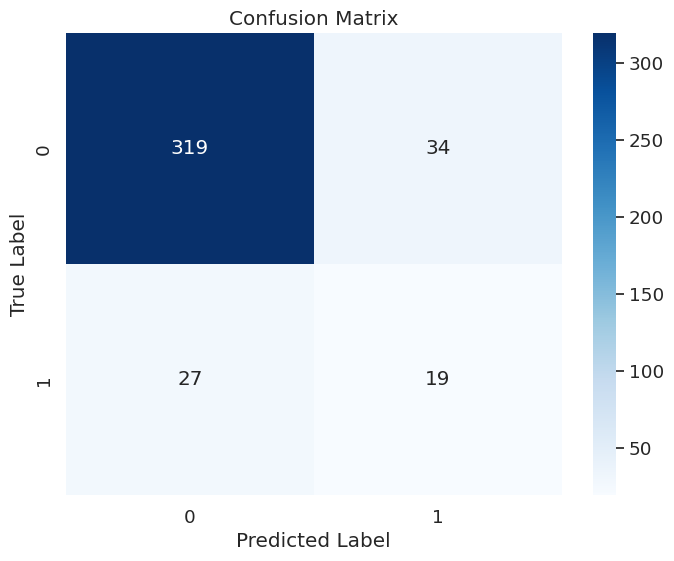

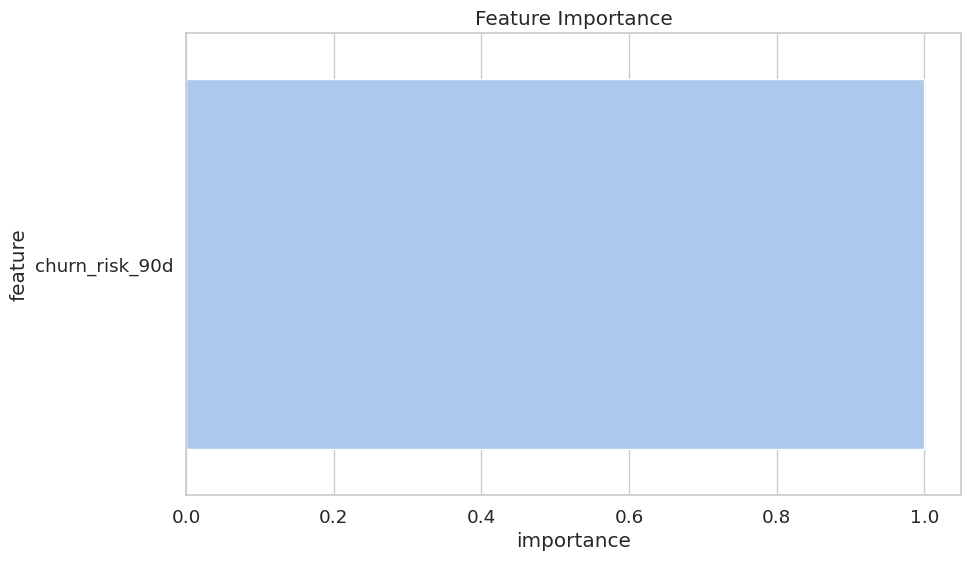

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data for Random Forest
rf_features = ['churn_risk_90d']

X = predictions_clean[rf_features]
y = predictions_clean['Churned']

# Split that shit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:,1]

# Print all the juicy metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Feature importance
importance_df = pd.DataFrame({
    'feature': rf_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()

Training model with SMOTE and hyperparameter tuning...

Best parameters: {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 459}

Classification Report with SMOTE and Tuning:
              precision    recall  f1-score   support

       False       0.95      0.77      0.85       353
        True       0.29      0.70      0.41        46

    accuracy                           0.76       399
   macro avg       0.62      0.73      0.63       399
weighted avg       0.87      0.76      0.80       399


ROC AUC Score: 0.8215297450424928


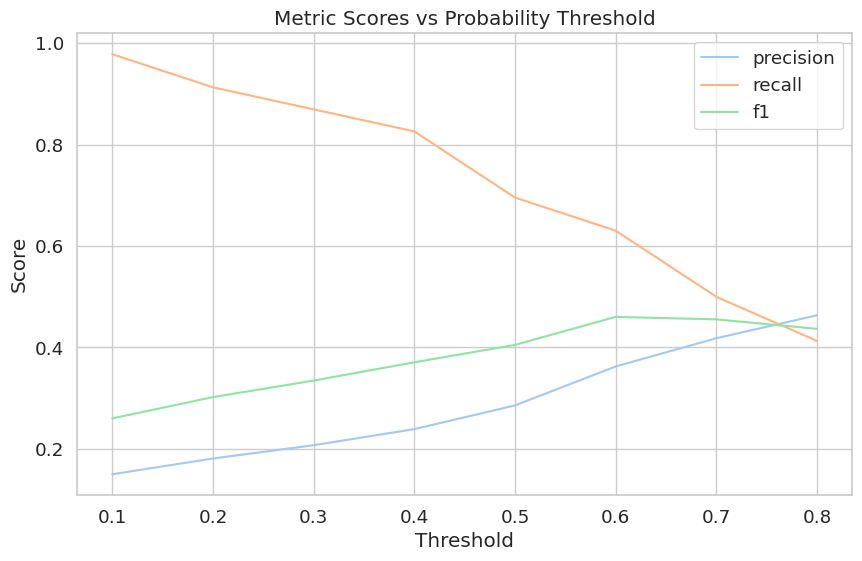


Metrics by Threshold:
   threshold  precision  recall     f1
0        0.1      0.150   0.978  0.260
1        0.2      0.181   0.913  0.302
2        0.3      0.207   0.870  0.335
3        0.4      0.239   0.826  0.371
4        0.5      0.286   0.696  0.405
5        0.6      0.362   0.630  0.460
6        0.7      0.418   0.500  0.455
7        0.8      0.463   0.413  0.437


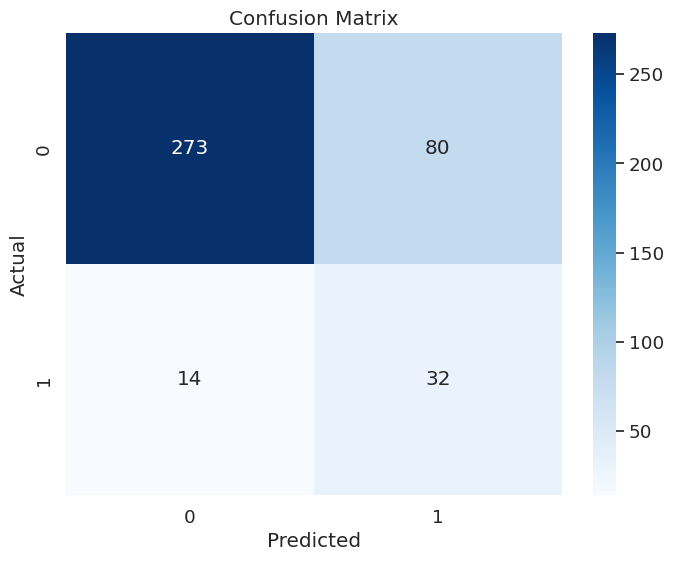

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# First, let's balance our dataset with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Define hyperparameter space
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create and train Random Forest with random search
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

print("Training model with SMOTE and hyperparameter tuning...")
rf_random.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_tuned = rf_random.predict(X_test)
y_pred_proba_tuned = rf_random.predict_proba(X_test)[:,1]

# Print results
print("\nBest parameters:", rf_random.best_params_)
print("\nClassification Report with SMOTE and Tuning:")
print(classification_report(y_test, y_pred_tuned))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba_tuned))

# Analyze different probability thresholds
thresholds = np.arange(0.1, 0.9, 0.1)
results = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_tuned >= threshold).astype(int)
    results.append({
        'threshold': threshold,
        'precision': precision_score(y_test, y_pred_threshold),
        'recall': recall_score(y_test, y_pred_threshold),
        'f1': f1_score(y_test, y_pred_threshold)
    })

# Plot threshold analysis
results_df = pd.DataFrame(results)
plt.figure(figsize=(10,6))
for metric in ['precision', 'recall', 'f1']:
    plt.plot(results_df['threshold'], results_df[metric], label=metric)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metric Scores vs Probability Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Print threshold metrics
print("\nMetrics by Threshold:")
print(results_df.round(3))

# Plot confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#Final DF

In [ ]:
predictions_clean.head()

UserID  survival_prob_90d  churn_risk_90d  survival_prob_180d  \
0   C10000           0.676717        0.323283            0.737001   
12  C10001           0.845747        0.154253            0.877284   
24  C10002           0.691082        0.308918            0.749199   
36  C10003           0.799830        0.200170            0.839838   
48  C10004           0.869067        0.130933            0.896131   

    churn_risk_180d  survival_prob_365d  churn_risk_365d   risk_group  \
0          0.262999            0.832078         0.167922    High Risk   
12         0.122716            0.924162         0.075838  Medium Risk   
24         0.250801            0.840347         0.159653    High Risk   
36         0.160162            0.900194         0.099806    High Risk   
48         0.103869            0.936072         0.063928  Medium Risk   

    Churned risk_category  
0     False   Medium Risk  
12    False      Low Risk  
24    False   Medium Risk  
36    False      Low Risk  
48    False      Low Risk

In [ ]:
# First, let's merge predictions with the original merged_df
merged_df_with_predictions = merged_df.merge(predictions_clean, on='UserID', how='left')

# Let's check what we got
print("\nShape of final dataframe:", merged_df_with_predictions.shape)
print("\nColumns in final dataframe:")
print(merged_df_with_predictions.columns.tolist())

# Quick look at the result
print("\nSample of final dataframe with predictions and categorical variables:")
print(merged_df_with_predictions.head())


Shape of final dataframe: (1994, 61)

Columns in final dataframe:
['UserID', 'FiscalPeriod', 'TenureInMonths', 'SegmentName', 'MonthsSinceContractEnd', 'Age', 'ContractRiskScore', 'latest_device', 'latest_topup', 'dominant_device', 'dominant_topup', 'device_count', 'topup_count', 'device_changes', 'topup_changes', 'has_device_changed', 'unique_topup_methods', 'has_contract_changed', 'has_segment_changed', 'contract_30 DAY', 'contract_24 MONTH', 'contract_12 MONTH', 'contract_18 MONTH', 'contract_PREPAID', 'TimeDelta', 'MaxDuration', 'MinDuration', 'Channel_Call', 'Channel_Retail', 'Reason_Billing', 'Reason_Coverage', 'Reason_Service', 'Reason_Upgrade', 'DiscountAmount', 'DurationMonths', 'DiscountCount', 'IsCurrentDiscount', 'PreviousDiscount', 'spend_avg_change', 'spend_trend_slope', 'spend_trend_direction', 'spend_last_value', 'usage_avg_change', 'usage_trend_slope', 'usage_trend_direction', 'usage_last_value', 'InsuranceInd', 'TVInd', 'FriendReferralInd', 'FriendReferralsLastMonth'

In [ ]:
# Drop one of the Churned columns (keeping 'Churned_x' and renaming it)
merged_df_with_predictions = merged_df_with_predictions.drop('Churned_y', axis=1)
merged_df_with_predictions = merged_df_with_predictions.rename(columns={'Churned_x': 'Churned'})

In [ ]:
merged_df_with_predictions.head()

UserID  FiscalPeriod  TenureInMonths SegmentName  MonthsSinceContractEnd  \
0  C10000        202410             136    BILL PAY                    38.0   
1  C10001        202410             294    BILL PAY                    11.0   
2  C10002        202410             291    BILL PAY                    30.0   
3  C10003        202410             289    BILL PAY                    10.0   
4  C10004        202410             277    BILL PAY                     9.0   

    Age  ContractRiskScore   latest_device latest_topup dominant_device  ...  \
0  65.0           1.153460  4TH GENERATION      UNKNOWN  4TH GENERATION  ...   
1  53.0           2.657974  5TH GENERATION      UNKNOWN  5TH GENERATION  ...   
2  58.0           2.657974  4TH GENERATION      UNKNOWN  4TH GENERATION  ...   
3  53.0           2.657974  4TH GENERATION      UNKNOWN  4TH GENERATION  ...   
4  71.0           2.657974  5TH GENERATION      UNKNOWN  5TH GENERATION  ...   

  CancellationDate  Churned  survival_prob_90d  churn_risk_90d  \
0              NaT        0           0.676717        0.323283   
1              NaT        0           0.845747        0.154253   
2              NaT        0           0.691082        0.308918   
3              NaT        0           0.799830        0.200170   
4              NaT        0           0.869067        0.130933   

   survival_prob_180d  churn_risk_180d  survival_prob_365d  churn_risk_365d  \
0            0.737001         0.262999            0.832078         0.167922   
1            0.877284         0.122716            0.924162         0.075838   
2            0.749199         0.250801            0.840347         0.159653   
3            0.839838         0.160162            0.900194         0.099806   
4            0.896131         0.103869            0.936072         0.063928   

    risk_group  risk_category  
0    High Risk    Medium Risk  
1  Medium Risk       Low Risk  
2    High Risk    Medium Risk  
3    High Risk       Low Risk  
4  Medium Risk       Low Risk  

[5 rows x 60 columns]

In [ ]:
# First, let's handle the categorical columns properly in merged_df_with_predictions
merged_df_with_predictions_encoded = merged_df_with_predictions.copy()

# Define our categorical columns
categorical_columns = {
    'SegmentName': 'MISSING',
    'latest_device': 'MISSING',
    'latest_topup': 'MISSING',
    'dominant_device': 'MISSING',
    'dominant_topup': 'MISSING',
    'spend_trend_direction': 'MISSING',
    'usage_trend_direction': 'MISSING'
}

# Fill NaN values with 'MISSING' for each categorical column
for col, missing_value in categorical_columns.items():
    merged_df_with_predictions_encoded[col] = merged_df_with_predictions_encoded[col].fillna(missing_value)

# Now perform one-hot encoding
for col in categorical_columns.keys():
    dummies = pd.get_dummies(merged_df_with_predictions_encoded[col], prefix=col)
    merged_df_with_predictions_encoded = pd.concat([merged_df_with_predictions_encoded, dummies], axis=1)
    merged_df_with_predictions_encoded = merged_df_with_predictions_encoded.drop(col, axis=1)

print("\nShape after encoding:", merged_df_with_predictions_encoded.shape)
print("\nMissing values after encoding:")
print(merged_df_with_predictions_encoded.isnull().sum())

# Let's see what our encoded dataframe looks like
print("\nFirst few rows of encoded dataframe:")
print(merged_df_with_predictions_encoded.head())


Shape after encoding: (1994, 85)

Missing values after encoding:
UserID                                0
FiscalPeriod                          0
TenureInMonths                        0
MonthsSinceContractEnd              595
Age                                   0
                                   ... 
spend_trend_direction_Increasing      0
spend_trend_direction_MISSING         0
usage_trend_direction_Decreasing      0
usage_trend_direction_Increasing      0
usage_trend_direction_MISSING         0
Length: 85, dtype: int64

First few rows of encoded dataframe:
   UserID  FiscalPeriod  TenureInMonths  MonthsSinceContractEnd   Age  \
0  C10000        202410             136                    38.0  65.0   
1  C10001        202410             294                    11.0  53.0   
2  C10002        202410             291                    30.0  58.0   
3  C10003        202410             289                    10.0  53.0   
4  C10004        202410             277                     9.0  7

In [ ]:
# Handle remaining missing values
merged_df_with_predictions_encoded['MonthsSinceContractEnd'] = merged_df_with_predictions_encoded['MonthsSinceContractEnd'].fillna(-1)

# Verify no more missing values
print("Missing values after final cleaning:")
print(merged_df_with_predictions_encoded.isnull().sum().sum())

# Let's create some key insights about our encoded data
print("\nDataset Overview:")
print(f"Total records: {len(merged_df_with_predictions_encoded)}")
print(f"Total features: {len(merged_df_with_predictions_encoded.columns)}")

# Let's look at the distribution of some key binary columns
binary_cols = [col for col in merged_df_with_predictions_encoded.columns
               if merged_df_with_predictions_encoded[col].dtype == bool]

print("\nDistribution of encoded categorical variables:")
for col in binary_cols[:10]:  # showing first 10 as example
    true_count = merged_df_with_predictions_encoded[col].sum()
    percentage = (true_count / len(merged_df_with_predictions_encoded)) * 100
    print(f"{col}: {true_count} ({percentage:.2f}%)")

Missing values after final cleaning:
29485

Dataset Overview:
Total records: 1994
Total features: 85

Distribution of encoded categorical variables:
has_device_changed: 322 (16.15%)
has_contract_changed: 105 (5.27%)
has_segment_changed: 39 (1.96%)
contract_30 DAY: 199 (9.98%)
contract_24 MONTH: 561 (28.13%)
contract_12 MONTH: 126 (6.32%)
contract_18 MONTH: 2 (0.10%)
contract_PREPAID: 1211 (60.73%)
SegmentName_BILL PAY: 783 (39.27%)
SegmentName_PREPAY: 1211 (60.73%)


In [ ]:
# Let's see which columns still have missing values
print("Columns with missing values:")
missing_cols = merged_df_with_predictions_encoded.isnull().sum()
print(missing_cols[missing_cols > 0])

# Let's handle these systematically:

# 1. For numerical columns, let's check their characteristics
numerical_cols = merged_df_with_predictions_encoded.select_dtypes(include=['float64', 'int64']).columns
print("\nNumerical columns with missing values:")
print(merged_df_with_predictions_encoded[numerical_cols].isnull().sum()[
    merged_df_with_predictions_encoded[numerical_cols].isnull().sum() > 0
])

# Define appropriate fill values based on the meaning of each column
fill_values = {
    'TimeDelta': 0,  # No interaction time
    'MaxDuration': 0,  # No interaction duration
    'MinDuration': 0,  # No interaction duration
    'Channel_Call': 0,  # No call interaction
    'Channel_Retail': 0,  # No retail interaction
    'Reason_Billing': 0,  # No billing reason
    'Reason_Coverage': 0,  # No coverage reason
    'Reason_Service': 0,  # No service reason
    'Reason_Upgrade': 0,  # No upgrade reason
    'DiscountAmount': 0,  # No discount
    'DurationMonths': 0,  # No duration
    'DiscountCount': 0,  # No discounts
    'IsCurrentDiscount': 0,  # No current discount
    'PreviousDiscount': 0,  # No previous discount
    'spend_avg_change': 0,  # No spend change
    'spend_trend_slope': 0,  # No trend
    'spend_last_value': 0,  # No last value
    'usage_avg_change': 0,  # No usage change
    'usage_trend_slope': 0,  # No trend
    'usage_last_value': 0,  # No last value
    'MonthsSinceContractEnd': -1  # Indicating missing/not applicable
}

# Fill missing values
merged_df_with_predictions_encoded = merged_df_with_predictions_encoded.fillna(fill_values)

# Verify all missing values are handled
print("\nMissing values after complete cleaning:")
print(merged_df_with_predictions_encoded.isnull().sum().sum())

# Show some statistics of the cleaned numerical columns
print("\nStatistics of key numerical columns after cleaning:")
key_cols = ['MonthsSinceContractEnd', 'spend_avg_change', 'usage_avg_change']
print(merged_df_with_predictions_encoded[key_cols].describe())

Columns with missing values:
TimeDelta            1981
MaxDuration          1929
MinDuration          1929
Channel_Call         1929
Channel_Retail       1929
Reason_Billing       1929
Reason_Coverage      1929
Reason_Service       1929
Reason_Upgrade       1929
DiscountAmount       1872
DurationMonths       1872
DiscountCount        1872
IsCurrentDiscount    1872
PreviousDiscount     1872
spend_avg_change      157
spend_trend_slope     157
spend_last_value      157
usage_avg_change      147
usage_trend_slope     147
usage_last_value      147
CancellationDate     1800
dtype: int64

Numerical columns with missing values:
TimeDelta            1981
MaxDuration          1929
MinDuration          1929
DiscountAmount       1872
DurationMonths       1872
DiscountCount        1872
IsCurrentDiscount    1872
PreviousDiscount     1872
spend_avg_change      157
spend_trend_slope     157
spend_last_value      157
usage_avg_change      147
usage_trend_slope     147
usage_last_value      147
dtype: i

In [ ]:
# Create a complete copy of our dataframe
clean_df = merged_df_with_predictions_encoded.copy()

# 1. Handle all interaction-related columns (fill with 0 for no interaction)
interaction_cols = [
    'TimeDelta', 'MaxDuration', 'MinDuration',
    'Channel_Call', 'Channel_Retail',
    'Reason_Billing', 'Reason_Coverage', 'Reason_Service', 'Reason_Upgrade'
]
clean_df[interaction_cols] = clean_df[interaction_cols].fillna(0)

# 2. Handle all discount-related columns (fill with 0 for no discounts)
discount_cols = [
    'DiscountAmount', 'DurationMonths', 'DiscountCount',
    'IsCurrentDiscount', 'PreviousDiscount'
]
clean_df[discount_cols] = clean_df[discount_cols].fillna(0)

# 3. Handle trend-related columns (fill with 0 for no trend)
trend_cols = [
    'spend_avg_change', 'spend_trend_slope', 'spend_last_value',
    'usage_avg_change', 'usage_trend_slope', 'usage_last_value'
]
clean_df[trend_cols] = clean_df[trend_cols].fillna(0)

# Drop CancellationDate column
clean_df = clean_df.drop('CancellationDate', axis=1)

# Verify our cleaning
print("Final missing value count:", clean_df.isnull().sum().sum())
print("\nShape of clean dataset:", clean_df.shape)

Final missing value count: 0

Shape of clean dataset: (1994, 84)


#VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# First, let's get only numerical columns
numerical_cols = clean_df.select_dtypes(include=['float64', 'int64']).columns
X = clean_df[numerical_cols]

# Calculate VIF for each numerical feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort by VIF value
vif_data = vif_data.sort_values('VIF', ascending=False)

# Display VIF values
print("VIF Values for Numerical Features:")
print(vif_data)

# Identify features with high VIF (typically > 5 or 10)
print("\nFeatures with VIF > 5:")
print(vif_data[vif_data['VIF'] > 5])

VIF Values for Numerical Features:
                     Feature           VIF
17          PreviousDiscount           inf
9       unique_topup_methods  4.503600e+15
16         IsCurrentDiscount  7.505999e+14
15             DiscountCount  1.876500e+14
6                topup_count  9.007199e+13
0               FiscalPeriod  5.416210e+01
14            DurationMonths  3.634258e+01
13            DiscountAmount  1.021420e+01
7             device_changes  5.289615e+00
5               device_count  5.258386e+00
8              topup_changes  4.436135e+00
4          ContractRiskScore  2.011293e+00
1             TenureInMonths  1.691788e+00
20          spend_last_value  1.665638e+00
2     MonthsSinceContractEnd  1.443586e+00
3                        Age  1.322455e+00
12               MinDuration  1.301822e+00
11               MaxDuration  1.285816e+00
26         FriendReferralInd  1.213773e+00
23          usage_last_value  1.143199e+00
25                     TVInd  1.130484e+00
24              Ins

Average Tenure for Churned Customers: 65.57 months
Average Tenure for Non-Churned Customers: 75.68 months

Detailed Statistics:
         count       mean        std  min  max
Churned                                       
0         1800  75.677778  64.409427    0  334
1          194  65.567010  55.710467    0  298


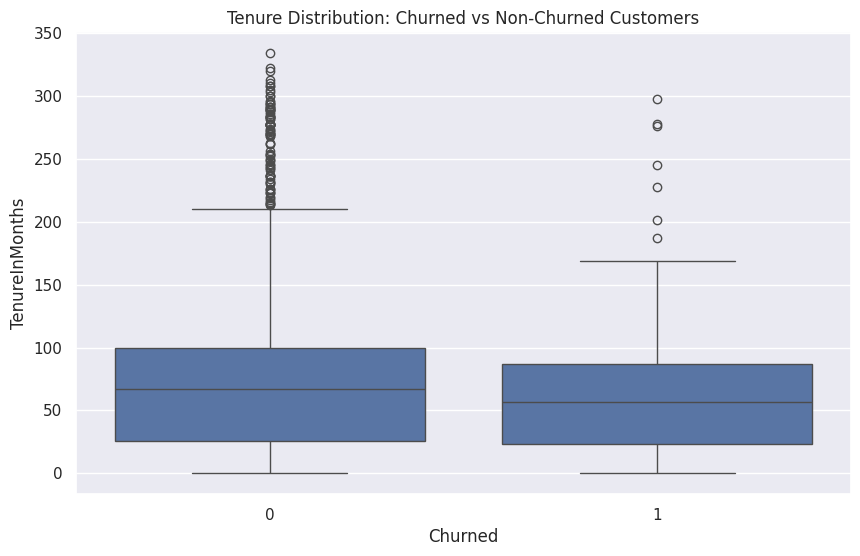

In [ ]:
# Calculate average tenure for each group
churned_avg = clean_df_survival[clean_df_survival['Churned'] == 1]['TenureInMonths'].mean()
not_churned_avg = clean_df_survival[clean_df_survival['Churned'] == 0]['TenureInMonths'].mean()

# Get more detailed statistics
tenure_stats = clean_df_survival.groupby('Churned')['TenureInMonths'].agg(['count', 'mean', 'std', 'min', 'max'])

print("Average Tenure for Churned Customers:", round(churned_avg, 2), "months")
print("Average Tenure for Non-Churned Customers:", round(not_churned_avg, 2), "months")
print("\nDetailed Statistics:")
print(tenure_stats)

# Optional: Visualize the difference
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Churned', y='TenureInMonths', data=clean_df_survival)
plt.title('Tenure Distribution: Churned vs Non-Churned Customers')
plt.show()

In [ ]:
# Drop these highly correlated features but keep IsCurrentDiscount
cols_to_drop = [
    'DiscountCount',
    'PreviousDiscount',
    'DiscountAmount',
    'unique_topup_methods',
    'topup_count'
]

clean_df_no_collin = clean_df.drop(cols_to_drop, axis=1)

# Recalculate VIF
numerical_cols = clean_df_no_collin.select_dtypes(include=['float64', 'int64']).columns
X = clean_df_no_collin[numerical_cols]

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort by VIF value
vif_data = vif_data.sort_values('VIF', ascending=False)

print("Updated VIF Values (keeping IsCurrentDiscount):")
print(vif_data)

Updated VIF Values (keeping IsCurrentDiscount):
                     Feature        VIF
0               FiscalPeriod  52.039599
6             device_changes   5.263776
5               device_count   5.218980
11            DurationMonths   3.460918
12         IsCurrentDiscount   3.160121
4          ContractRiskScore   1.962810
15          spend_last_value   1.661854
1             TenureInMonths   1.632333
2     MonthsSinceContractEnd   1.429816
7              topup_changes   1.323059
3                        Age   1.318800
10               MinDuration   1.297886
9                MaxDuration   1.280662
21         FriendReferralInd   1.209167
18          usage_last_value   1.142667
19              InsuranceInd   1.127272
20                     TVInd   1.116186
14         spend_trend_slope   1.111667
17         usage_trend_slope   1.099992
22  FriendReferralsLastMonth   1.055076
23                   Churned   1.041321
8                  TimeDelta   1.025556
13          spend_avg_change   1

In [ ]:
# Let's create a subset of survival-related columns
survival_cols = [
    'survival_prob_90d', 'churn_risk_90d',
    'survival_prob_180d', 'churn_risk_180d',
    'survival_prob_365d', 'churn_risk_365d'
]

# Create a DataFrame with just these columns
X_survival = clean_df[survival_cols]

# Calculate VIF for survival columns
vif_survival = pd.DataFrame()
vif_survival["Feature"] = survival_cols
vif_survival["VIF"] = [variance_inflation_factor(X_survival.values, i)
                       for i in range(X_survival.shape[1])]

# Sort by VIF value
vif_survival = vif_survival.sort_values('VIF', ascending=False)

print("VIF Values for Survival-related Features:")
print(vif_survival)

# Let's also check their correlation matrix
correlation_matrix = X_survival.corr()
print("\nCorrelation Matrix for Survival Features:")
print(correlation_matrix)

VIF Values for Survival-related Features:
              Feature        VIF
2  survival_prob_180d  44.772572
0   survival_prob_90d   5.265248
4  survival_prob_365d   1.319148
5     churn_risk_365d   0.051129
3     churn_risk_180d   0.032847
1      churn_risk_90d   0.006378

Correlation Matrix for Survival Features:
                    survival_prob_90d  churn_risk_90d  survival_prob_180d  \
survival_prob_90d            1.000000       -1.000000            0.998421   
churn_risk_90d              -1.000000        1.000000           -0.998421   
survival_prob_180d           0.998421       -0.998421            1.000000   
churn_risk_180d             -0.998421        0.998421           -1.000000   
survival_prob_365d           0.984837       -0.984837            0.992898   
churn_risk_365d             -0.984837        0.984837           -0.992898   

                    churn_risk_180d  survival_prob_365d  churn_risk_365d  
survival_prob_90d         -0.998421            0.984837        -0.984

In [ ]:
# Let's keep only one set of predictions, preferably the 90-day ones as they're:
# 1. More immediate/relevant
# 2. Have lower VIF values
# 3. Still highly correlated with longer-term predictions

cols_to_drop = [
    'survival_prob_180d', 'churn_risk_180d',
    'survival_prob_365d', 'churn_risk_365d'
]

# And since survival_prob_90d and churn_risk_90d are perfect inverses,
# we only need to keep one of them (let's keep survival_prob_90d)
cols_to_drop.append('churn_risk_90d')

clean_df_survival = clean_df.drop(cols_to_drop, axis=1)

In [ ]:
clean_df_survival.describe()

FiscalPeriod  TenureInMonths  MonthsSinceContractEnd          Age  \
count    1994.000000     1994.000000             1994.000000  1994.000000   
mean   202408.625376       74.694082               33.253761    47.381143   
std         9.838361       63.673281               46.558153    14.685400   
min    202312.000000        0.000000              -23.000000    18.000000   
25%    202410.000000       26.000000               -1.000000    37.000000   
50%    202410.000000       66.000000                9.000000    46.000000   
75%    202410.000000       99.000000               65.000000    55.000000   
max    202410.000000      334.000000              289.000000   100.000000   

       ContractRiskScore  device_count  topup_count  device_changes  \
count        1994.000000   1994.000000  1994.000000     1994.000000   
mean            4.153282      1.166499     1.470913        1.164995   
std             1.711351      0.385853     0.767115        0.493163   
min             0.000000      1.000000     1.000000        0.000000   
25%             2.657974      1.000000     1.000000        1.000000   
50%             5.466399      1.000000     1.000000        1.000000   
75%             5.466399      1.000000     2.000000        1.000000   
max             5.466399      3.000000     5.000000        6.000000   

       topup_changes  unique_topup_methods  ...  spend_last_value  \
count    1994.000000           1994.000000  ...       1994.000000   
mean        1.795386              1.470913  ...         23.639255   
std         1.407905              0.767115  ...         19.749083   
min         0.000000              1.000000  ...          0.000000   
25%         1.000000              1.000000  ...         14.553800   
50%         1.000000              1.000000  ...         16.642200   
75%         2.000000              2.000000  ...         31.530975   
max         8.000000              5.000000  ...        303.320000   

       usage_avg_change  usage_trend_slope  usage_last_value  InsuranceInd  \
count      1.994000e+03       1.994000e+03      1.994000e+03   1994.000000   
mean       1.293308e+05       9.621037e+07      1.186667e+11      0.045637   
std        3.045254e+06       9.972583e+08      2.412791e+11      0.208749   
min       -5.376688e-01      -1.077937e+10      0.000000e+00      0.000000   
25%        2.298568e-02      -1.281409e+07      9.810918e+09      0.000000   
50%        1.201131e-01       1.158881e+07      4.559678e+10      0.000000   
75%        3.818139e-01       1.215933e+08      1.261234e+11      0.000000   
max        9.432329e+07       2.626675e+10      3.979612e+12      1.000000   

             TVInd  FriendReferralInd  FriendReferralsLastMonth      Churned  \
count  1994.000000        1994.000000               1994.000000  1994.000000   
mean      0.128385           0.410231                  0.214142     0.097292   
std       0.334602           0.491999                  1.163408     0.296429   
min       0.000000           0.000000                  0.000000     0.000000   
25%       0.000000           0.000000                  0.000000     0.000000   
50%       0.000000           0.000000                  0.000000     0.000000   
75%       0.000000           1.000000                  0.000000     0.000000   
max       1.000000           1.000000                 15.000000     1.000000   

       survival_prob_90d  
count        1994.000000  
mean            0.842109  
std             0.132219  
min             0.000482  
25%             0.780691  
50%             0.870842  
75%             0.943046  
max             1.000000  

[8 rows x 30 columns]

In [ ]:
# Check unique values in risk_category
print("Unique values in risk_category:", clean_df_survival['risk_category'].unique())

Unique values in risk_category: ['Medium Risk' 'Low Risk' 'High Risk']


In [ ]:
# Do the one-hot encoding for risk_category
risk_dummies = pd.get_dummies(clean_df_survival['risk_category'], prefix='risk')
clean_df_survival = pd.concat([clean_df_survival.drop('risk_category', axis=1), risk_dummies], axis=1)

In [ ]:
# Drop FiscalPeriod
clean_df_survival = clean_df_survival.drop('FiscalPeriod', axis=1)

In [ ]:
# Convert these categorical columns to numeric
categorical_cols = [
    'Channel_Call', 'Channel_Retail',
    'Reason_Billing', 'Reason_Coverage',
    'Reason_Service', 'Reason_Upgrade'
]

# Convert to numeric (they should be binary 0/1)
for col in categorical_cols:
    clean_df_survival[col] = clean_df_survival[col].astype(int)

In [ ]:
clean_df_survival.columns

Index(['UserID', 'TenureInMonths', 'MonthsSinceContractEnd', 'Age',
       'ContractRiskScore', 'device_count', 'topup_count', 'device_changes',
       'topup_changes', 'has_device_changed', 'unique_topup_methods',
       'has_contract_changed', 'has_segment_changed', 'contract_30 DAY',
       'contract_24 MONTH', 'contract_12 MONTH', 'contract_18 MONTH',
       'contract_PREPAID', 'TimeDelta', 'MaxDuration', 'MinDuration',
       'Channel_Call', 'Channel_Retail', 'Reason_Billing', 'Reason_Coverage',
       'Reason_Service', 'Reason_Upgrade', 'DiscountAmount', 'DurationMonths',
       'DiscountCount', 'IsCurrentDiscount', 'PreviousDiscount',
       'spend_avg_change', 'spend_trend_slope', 'spend_last_value',
       'usage_avg_change', 'usage_trend_slope', 'usage_last_value',
       'InsuranceInd', 'TVInd', 'FriendReferralInd',
       'FriendReferralsLastMonth', 'Churned', 'survival_prob_90d',
       'risk_group', 'SegmentName_BILL PAY', 'SegmentName_PREPAY',
       'latest_device_1ST G

In [ ]:
# Check current risk-related columns
print("Current risk-related columns:")
risk_cols = [col for col in clean_df_survival.columns if 'risk' in col.lower()]
print(risk_cols)

# Drop only risk_group
clean_df_survival = clean_df_survival.drop('risk_group', axis=1)

# Verify after dropping
print("\nRisk-related columns after dropping:")
risk_cols = [col for col in clean_df_survival.columns if 'risk' in col.lower()]
print(risk_cols)

Current risk-related columns:
['ContractRiskScore', 'risk_group', 'risk_High Risk', 'risk_Low Risk', 'risk_Medium Risk']

Risk-related columns after dropping:
['ContractRiskScore', 'risk_High Risk', 'risk_Low Risk', 'risk_Medium Risk']


# Model Building using STree Models for Churn

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 1. Prepare Features and Target
X = clean_df_survival.drop(['Churned', 'UserID'], axis=1)
y = clean_df_survival['Churned']

After Resampling:
Churned
1    1398
0     946
Name: count, dtype: int64

Training and evaluating RandomForest...

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       353
           1       0.36      0.57      0.44        46

    accuracy                           0.83       399
   macro avg       0.65      0.72      0.67       399
weighted avg       0.87      0.83      0.85       399

ROC-AUC Score for RandomForest: 0.8369565217391304


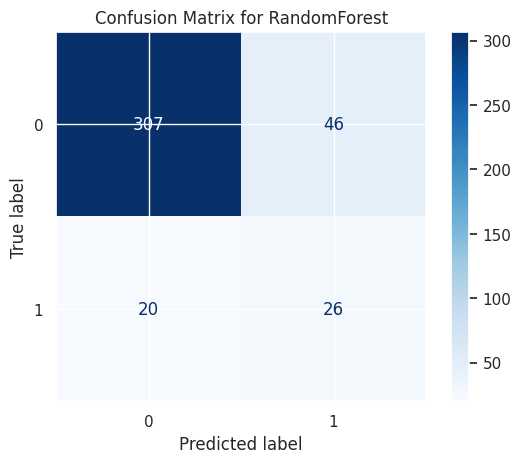

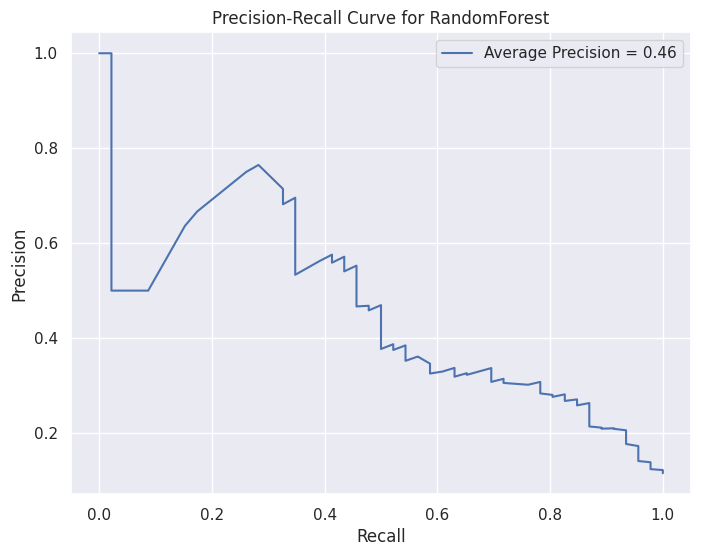

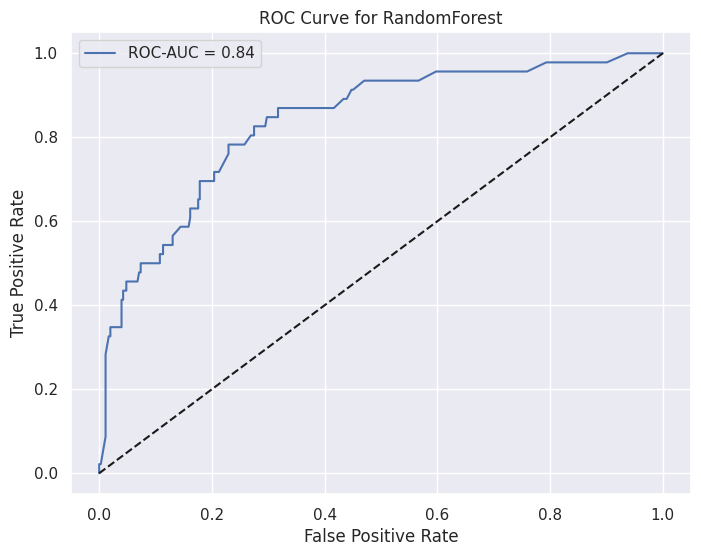

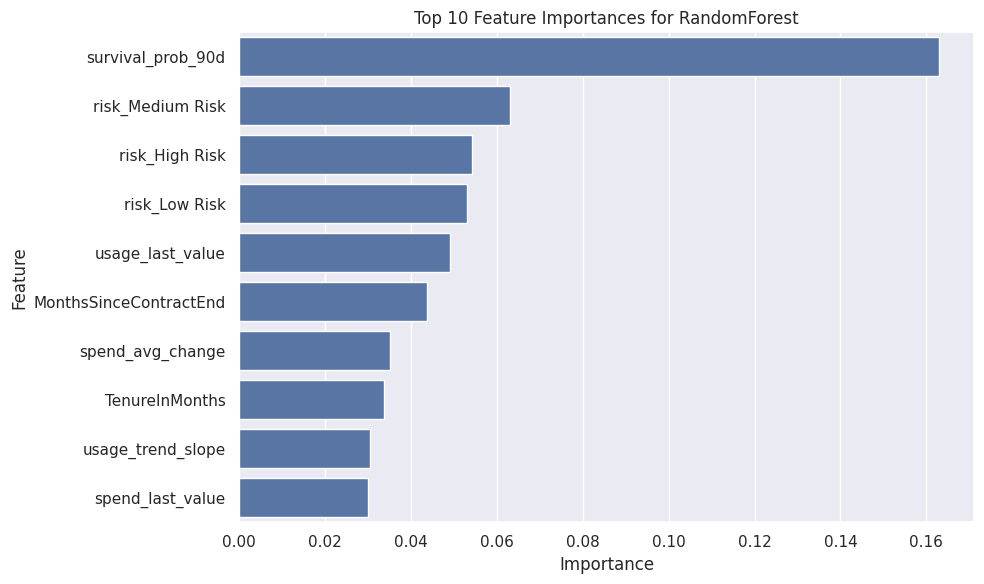


Training and evaluating GradientBoosting...

Classification Report for GradientBoosting:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       353
           1       0.36      0.63      0.46        46

    accuracy                           0.83       399
   macro avg       0.65      0.74      0.68       399
weighted avg       0.88      0.83      0.85       399

ROC-AUC Score for GradientBoosting: 0.8260253725828304


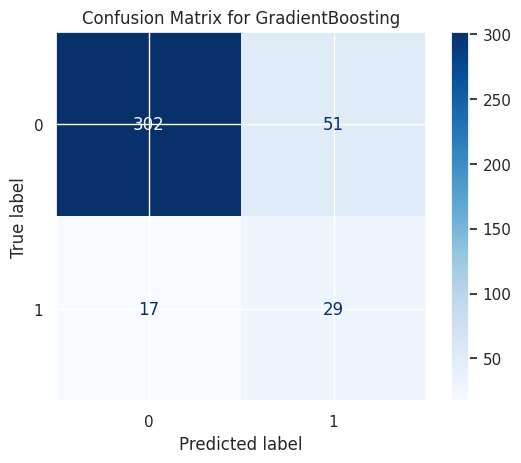

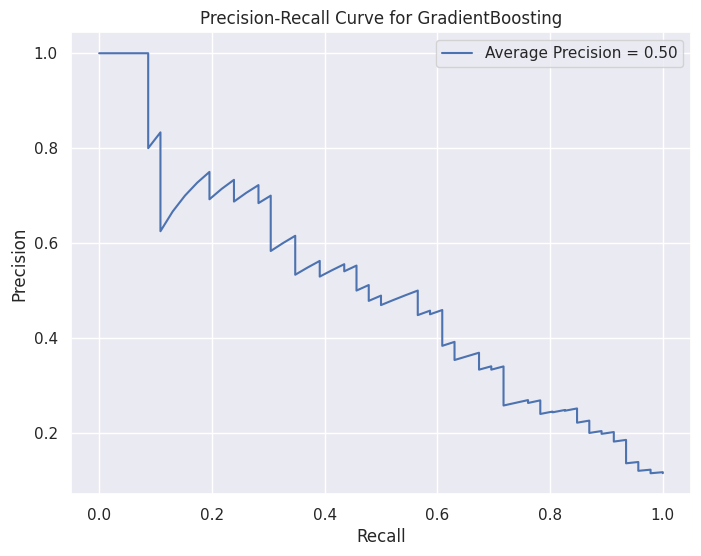

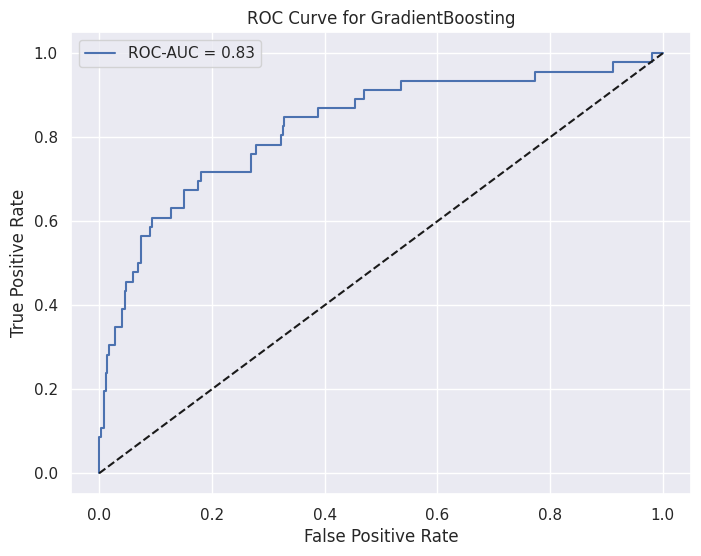

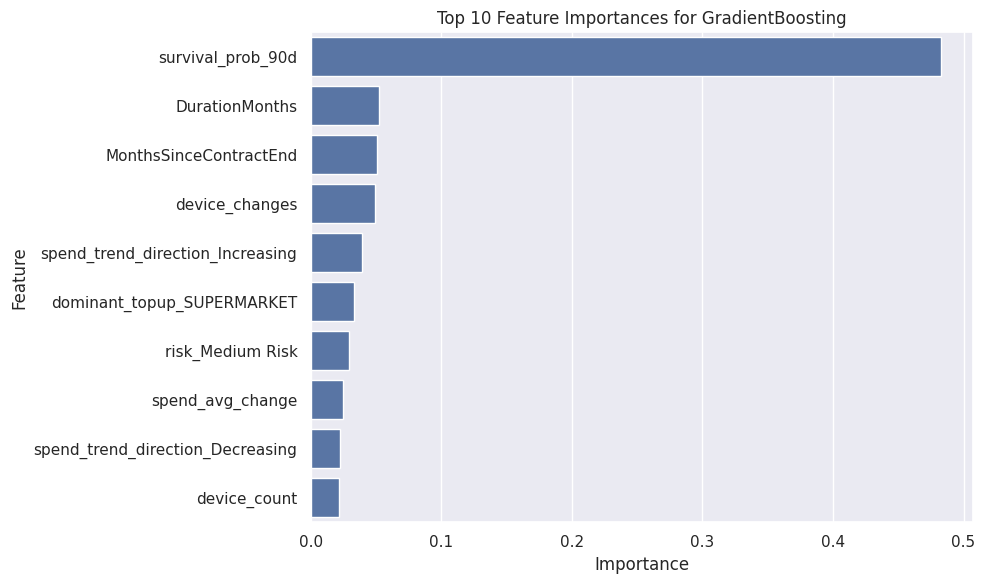


Training and evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1398, number of negative: 946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3260
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596416 -> initscore=0.390555
[LightGBM] [Info] Start training from score 0.390555

Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       353
           1       0.46      0.57      0.51        46

    accuracy                           0.87       399
   macro avg       0.70      0.74      0.72       399
weighted avg       0.8

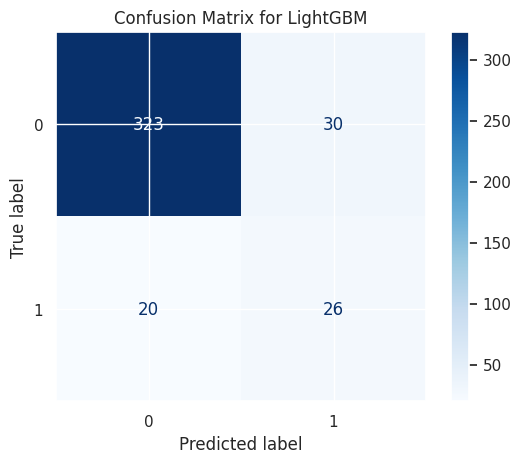

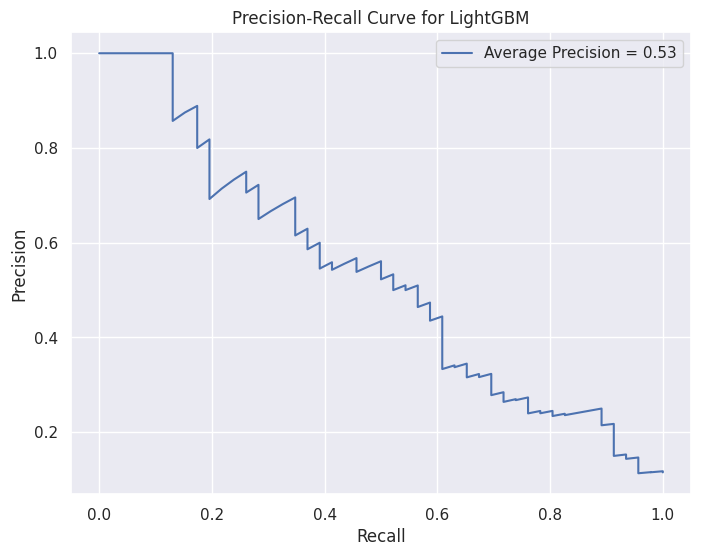

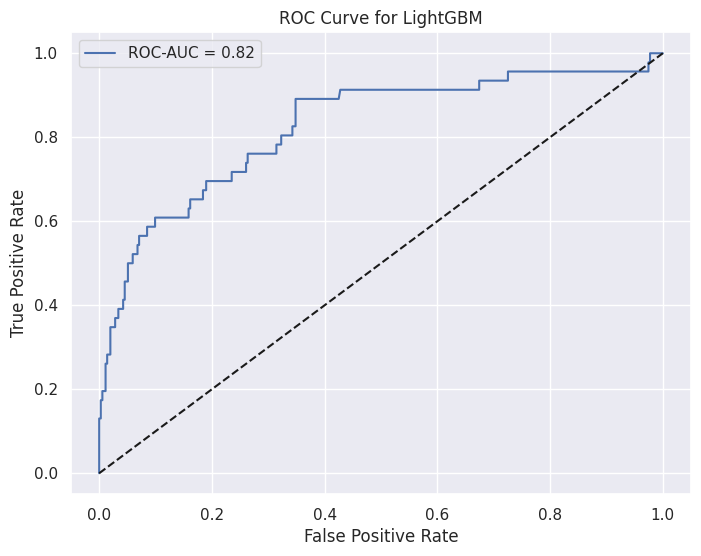

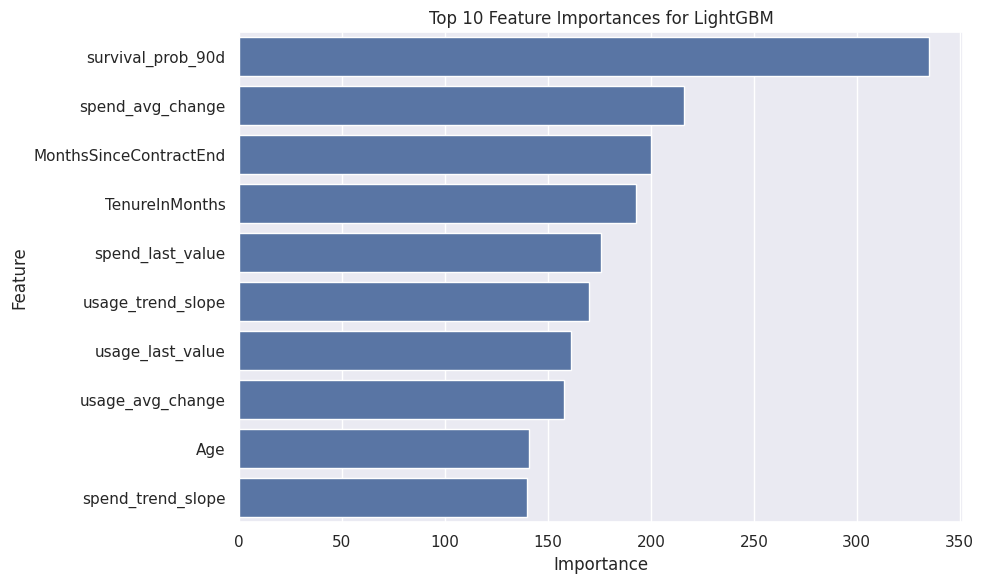


Training and evaluating XGBoost...

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       353
           1       0.45      0.54      0.50        46

    accuracy                           0.87       399
   macro avg       0.70      0.73      0.71       399
weighted avg       0.88      0.87      0.88       399

ROC-AUC Score for XGBoost: 0.8140780884345362


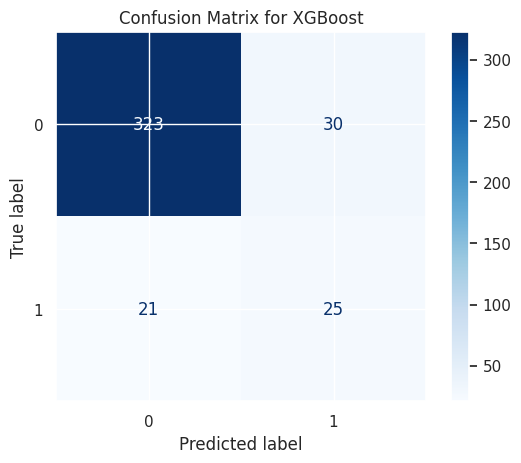

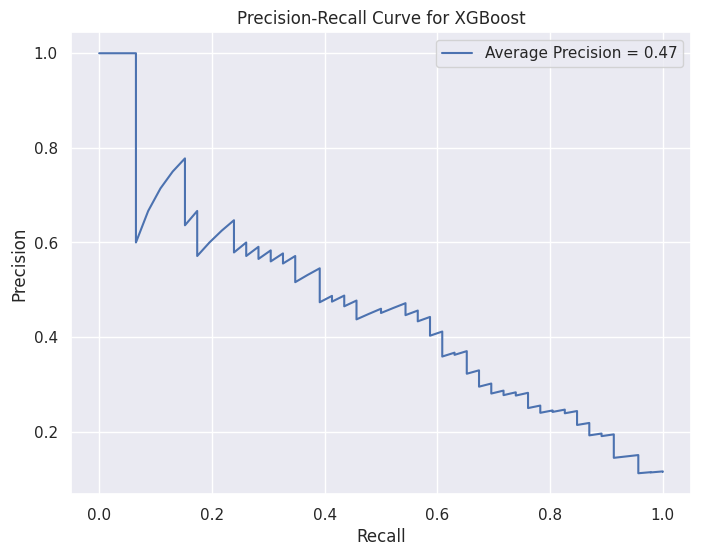

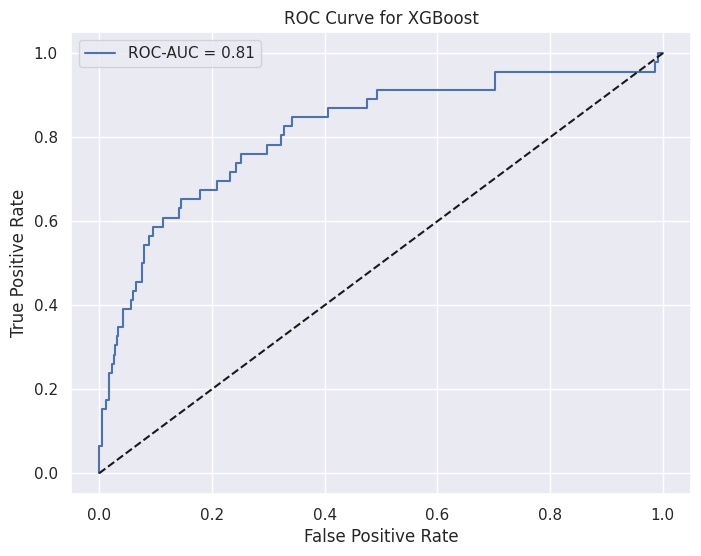

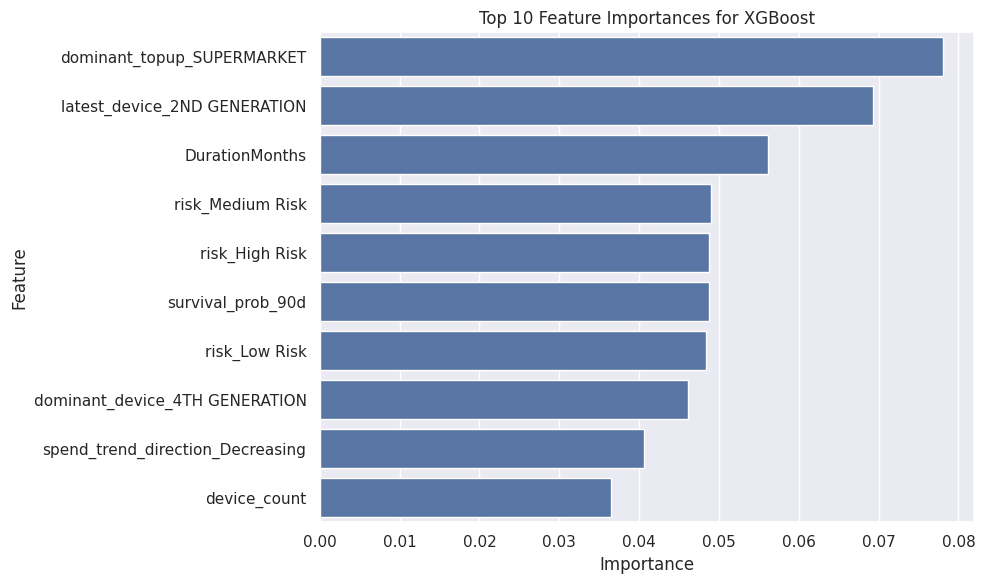


Comparison of Model Performance:
              Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0          LightGBM  0.874687   0.464286  0.565217  0.509804  0.824886   
1           XGBoost  0.872180   0.454545  0.543478  0.495050  0.814078   
2  GradientBoosting  0.829574   0.362500  0.630435  0.460317  0.826025   
3      RandomForest  0.834586   0.361111  0.565217  0.440678  0.836957   

   Average Precision  
0           0.530776  
1           0.465274  
2           0.503557  
3           0.461883  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lightgbm as lgb
import xgboost as xgb

from imblearn.combine import SMOTEENN

X = clean_df_survival.drop(['Churned', 'UserID'], axis=1)
y = clean_df_survival['Churned']

# Define binary and non-binary columns
binary_columns = [col for col in X.columns if X[col].nunique() == 2]
non_binary_columns = [col for col in X.columns if col not in binary_columns]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale only non-binary columns
scaler = StandardScaler()
X_train[non_binary_columns] = scaler.fit_transform(X_train[non_binary_columns])
X_test[non_binary_columns] = scaler.transform(X_test[non_binary_columns])

# Now we can proceed with SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smoteenn.fit_resample(X_train, y_train)

print("After Resampling:")
print(pd.Series(y_train_res).value_counts())

# 4. Compute class weights
classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_res)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# 5. Calculate scale_pos_weight correctly
scale_pos_weight = len(y_train_res[y_train_res == False]) / len(y_train_res[y_train_res == True])

# 6. Define Models
models = [
    ('RandomForest', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('GradientBoosting', GradientBoostingClassifier(random_state=42)),
    ('LightGBM', lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=42)),
    ('XGBoost', xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False,
                                 eval_metric='logloss', random_state=42))
]

# 7. Initialize results DataFrame
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
                              'ROC-AUC', 'Average Precision'])

# 8. Train and evaluate models
for name, model in models:
    print(f"\nTraining and evaluating {name}...")

    # Train the model
    model.fit(X_train_res, y_train_res)

    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)

    # Create new row and concatenate to results
    new_row = pd.DataFrame({
        'Model': [name],
        'Accuracy': [acc],
        'Precision': [prec],
        'Recall': [rec],
        'F1-Score': [f1],
        'ROC-AUC': [roc_auc],
        'Average Precision': [avg_prec]
    })

    results = pd.concat([results, new_row], ignore_index=True)

    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"ROC-AUC Score for {name}: {roc_auc}")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Plot Precision-Recall Curve
    precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)

    plt.figure(figsize=(8,6))
    plt.plot(recall_vals, precision_vals, label=f'Average Precision = {avg_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {name}')
    plt.legend()
    plt.show()

    # Plot ROC Curve
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend()
    plt.show()

    # Feature Importance Plots
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10,6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
        plt.title(f'Top 10 Feature Importances for {name}')
        plt.tight_layout()
        plt.show()

    elif hasattr(model, 'coef_'):
        coef = model.coef_[0]
        feature_names = X_train.columns
        coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
        coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

        plt.figure(figsize=(10,6))
        sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10))
        plt.title(f'Top 10 Coefficient Features for {name}')
        plt.tight_layout()
        plt.show()

# 9. Display Final Results
print("\nComparison of Model Performance:")
print(results.sort_values(by='F1-Score', ascending=False).reset_index(drop=True))

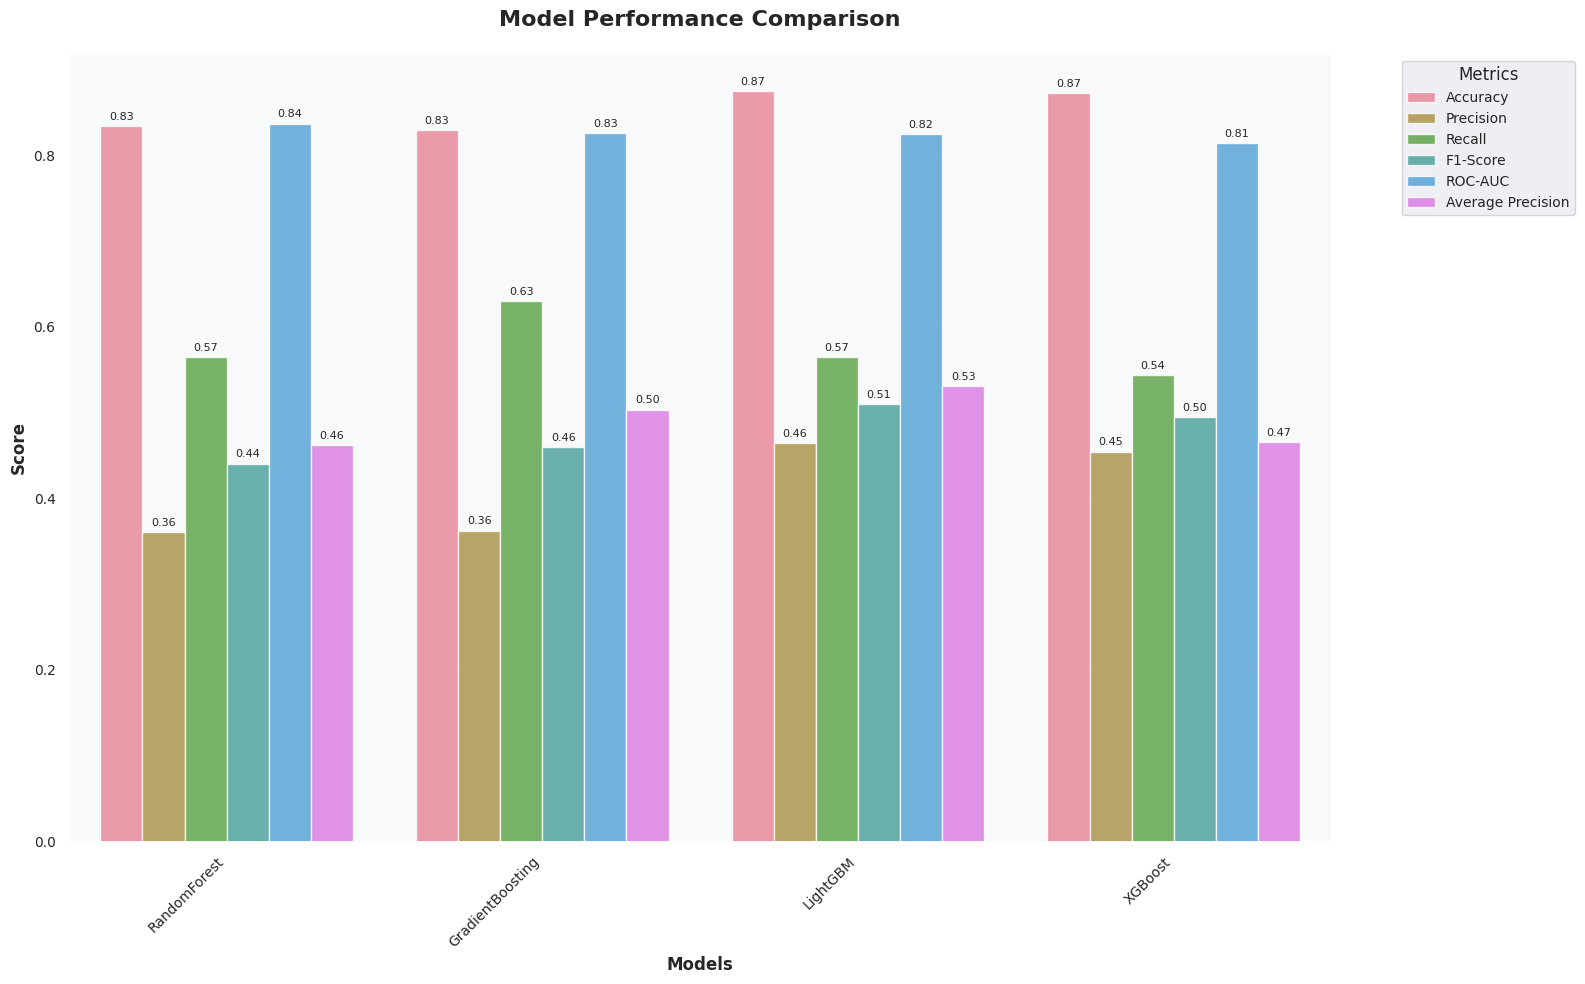


🏆 Best Models per Metric:
📊 Accuracy            : LightGBM        (0.875)
📊 Precision           : LightGBM        (0.464)
📊 Recall              : GradientBoosting (0.630)
📊 F1-Score            : LightGBM        (0.510)
📊 ROC-AUC             : RandomForest    (0.837)
📊 Average Precision   : LightGBM        (0.531)


In [ ]:
def create_model_comparison_plot(results_df):
    # Set the style
    sns.set_style("darkgrid")

    # Set color palette - using a custom colorful palette
    colors = sns.color_palette("husl", n_colors=6)

    # Melt the dataframe for easier plotting
    melted_results = results_df.melt(id_vars=['Model'],
                                   value_vars=['Accuracy', 'Precision', 'Recall',
                                             'F1-Score', 'ROC-AUC', 'Average Precision'])

    # Create the comparison plot with enhanced styling
    plt.figure(figsize=(16, 10))

    # Create the bar plot with enhanced aesthetics
    ax = sns.barplot(x='Model', y='value', hue='variable', data=melted_results,
                    palette=colors, alpha=0.8)

    # Enhance the plot
    plt.title('Model Performance Comparison', pad=20, fontsize=16, fontweight='bold')
    plt.xlabel('Models', fontsize=12, fontweight='bold')
    plt.ylabel('Score', fontsize=12, fontweight='bold')

    # Rotate x-labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    # Enhance legend
    plt.legend(title='Metrics', title_fontsize=12, fontsize=10,
              bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add value labels on the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, rotation=0, fontsize=8)

    # Add grid for better readability
    plt.grid(True, alpha=0.3)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Add a subtle background color
    ax.set_facecolor('#f8f9fa')

    # Show plot
    plt.show()

    # Create styled table with enhanced formatting
    styled_results = results_df.style.background_gradient(
        cmap='RdYlBu_r',
        subset=results_df.columns[1:]
    ).set_properties(**{
        'text-align': 'center',
        'font-size': '11pt',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px'
    }).format({col: '{:.3f}' for col in results_df.columns[1:]})

    display(styled_results)

    # Print best model summary with enhanced formatting
    print("\n" + "="*50)
    print("🏆 Best Models per Metric:")
    print("="*50)
    for column in results_df.columns[1:]:
        best_model = results_df.loc[results_df[column].idxmax()]
        print(f"📊 {column:<20}: {best_model['Model']:<15} ({best_model[column]:.3f})")
    print("="*50)

# Set the overall theme
sns.set_theme(style="darkgrid")

# Create the comparison
create_model_comparison_plot(results)

In [ ]:
# Try hyperparameter tuning for LightGBM
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 5, 7],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 30, 50]
}

lgb_model = lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
grid_search = GridSearchCV(
    lgb_model,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train_res, y_train_res)

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1398, number of negative: 946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3260
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596416 -> initscore=0.390555
[LightGBM] [Info] Start training from score 0.390555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1398, number of negative: 946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3260
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596416 -> initscore=0.390555
[LightGBM] [Info] Start training from score 0.390555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

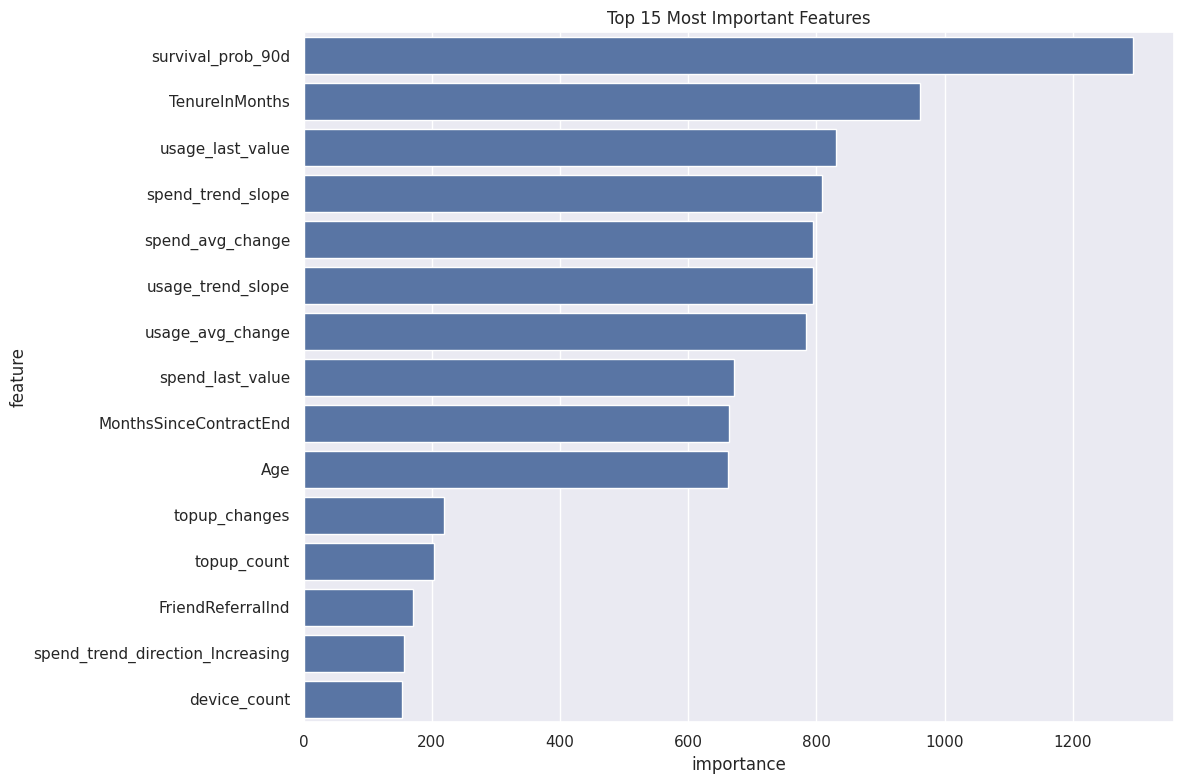

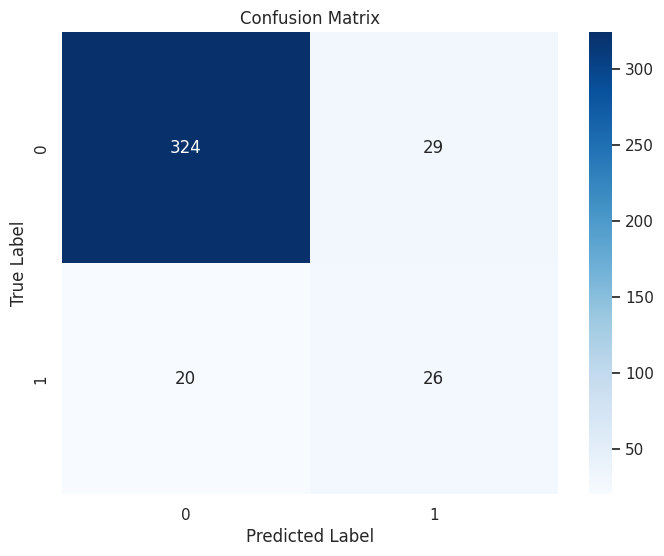

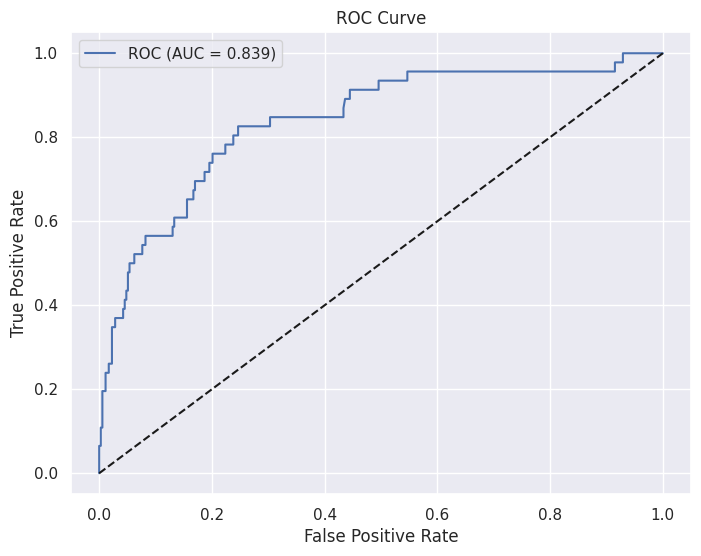

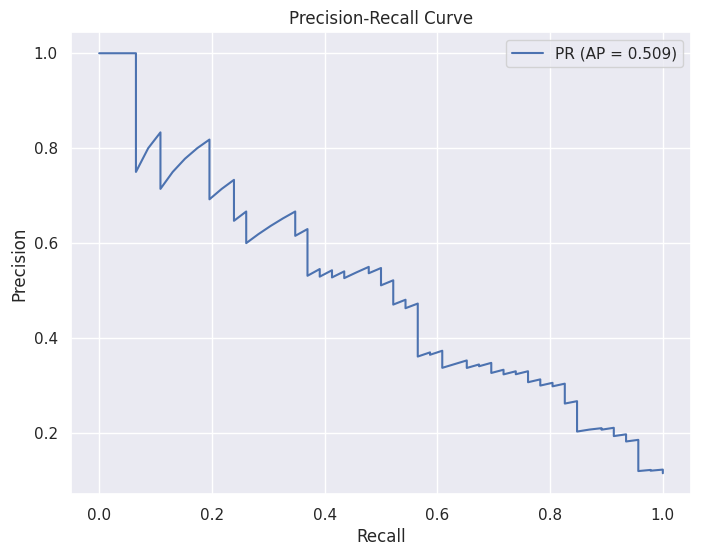

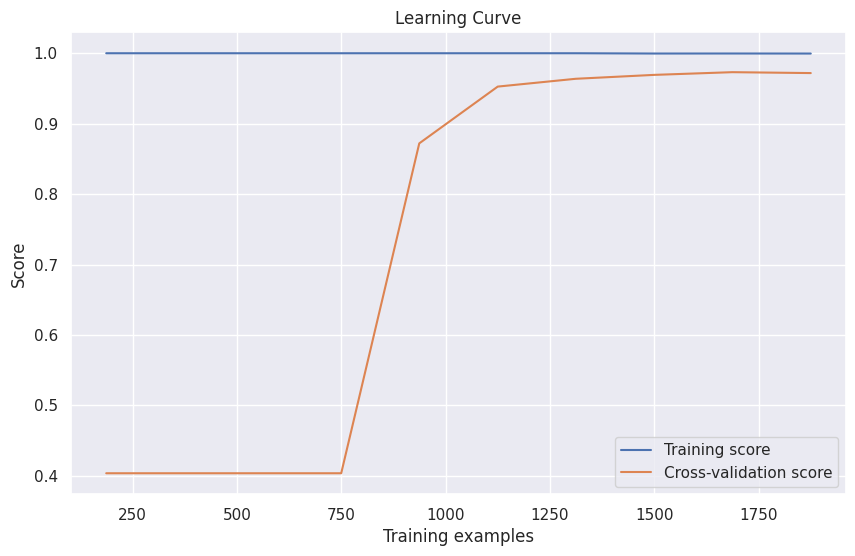


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       353
           1       0.47      0.57      0.51        46

    accuracy                           0.88       399
   macro avg       0.71      0.74      0.72       399
weighted avg       0.89      0.88      0.88       399


Top 10 Most Important Features:
               feature  importance
     survival_prob_90d        1293
        TenureInMonths         962
      usage_last_value         831
     spend_trend_slope         808
      spend_avg_change         795
     usage_trend_slope         794
      usage_avg_change         783
      spend_last_value         672
MonthsSinceContractEnd         664
                   Age         662


In [ ]:
# 1. Train the best model with the found parameters
best_lgb = lgb.LGBMClassifier(
    learning_rate=0.1,
    max_depth=-1,
    min_child_samples=20,
    n_estimators=200,
    num_leaves=63,
    random_state=42
)
best_lgb.fit(X_train_res, y_train_res)

# Make predictions
y_pred = best_lgb.predict(X_test)
y_proba = best_lgb.predict_proba(X_test)[:, 1]

# 2. Feature Importance Plot
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_lgb.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

# 3. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 5. Precision-Recall Curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f'PR (AP = {average_precision_score(y_test, y_proba):.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 6. Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_lgb, X_train_res, y_train_res,
    cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# 7. Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 8. Feature Importance Table
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))